In [1]:
from utils import SpatialTransform
from data_modules.inrmorph import load_data, get_time_points
from data_modules.inrmorph import CoordsImageTest
from models.inrmorph import InrMorph
import pandas as pd
from matplotlib.animation import FuncAnimation
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import wandb
import glob
import seaborn as snsnb hn bh
import numpy as np
from torch.utils.data import DataLoader
import os
import csv
import torch
import matplotlib.pyplot as plt
import neurite as ne
from config import get_datapath, NetworkType, GradientType, SimilarityMetric
os.environ["CUDA_VISIBLE_DEVICES"] = '7'
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
def set_wandb_logger():
    try:
        with open('result/logger_name.txt', 'r') as f:
            lines = f.readlines()
            lines = [line.strip() for line in lines if line.strip()]
            if lines:
                logger_name = lines[-1]
            else:
                logger_name = None
    except FileNotFoundError:
        print("The file 'logger_name.txt' does not exist.")
        logger_name = None
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        logger_name = None

    run = wandb.init(
        project="inrmorph",
        entity="aishalawal",
        name="visualizations_" + logger_name
    )
    return run, logger_name


def jacobian_determinant(coords, deformation_field):
    jac = compute_jacobian_matrix(coords, deformation_field)
    return torch.det(jac)


def compute_jacobian_matrix(coords, deformation_field):
    dim = coords.shape[1]
    # print("in jac", coords.shape, deformation_field.shape, dim)
    jacobian_matrix = torch.zeros(coords.shape[0], dim, dim)

    for i in range(dim):
        jacobian_matrix[:, i, :] = gradient(coords, deformation_field[:, i])
        # print("jacobian matrix", jacobian_matrix.shape)
    return jacobian_matrix


def gradient(coords, output, grad_outputs=None):
    # print("in grad", coords.shape, output.shape)

    grad_outputs = torch.ones_like(output)

    grad = torch.autograd.grad(output, [coords], grad_outputs=grad_outputs, create_graph=True)[0]

    return grad


def jacobain_determinant_numerical_approx(deformation_field):
    dx, dy, dz = torch.gradient(deformation_field, dim=(0, 1, 2))  # Gradients w.r.t x, y, z

    #each dx, dy, dz is of shape (260, 260, 250, 3), where the last dimension gives (∂x/∂x, ∂x/∂y, ∂x/∂z) and so on
    #we form the Jacobian matrix for each voxel
    jacobian_matrix = torch.stack([dx, dy, dz], dim=-1)  #shape: (260, 260, 250, 3, 3)

    #compute the determinant of the Jacobian matrix at each voxel
    jacobian_determinant = torch.det(jacobian_matrix)

    return jacobian_determinant

def analytic_rate_of_change(jacobian_determinant, time):
    voxelwise_derivatives = torch.autograd.grad(
                outputs=jacobian_determinant,
                inputs=time,
                grad_outputs=torch.ones_like(jacobian_determinant),
                create_graph=True,
            )[0]
    return voxelwise_derivatives

In [4]:
#training here and testing later
transform = SpatialTransform()
validation_batch_size = 1
spatial_reg = 0
temporal_reg = 0
monotonicity_reg = 1
spatial_reg_type = "spatial_jacobaian_matrix_penalty"
patch_size = [32, 32, 32]
# batch_size = 338000
batch_size = 211250
# batch_size = 13520000
project_name = "inrmorph"

#data loader
datapath = get_datapath() + "CN/098_S_4506/resampled/"
print(datapath)
data = sorted(glob.glob(datapath + "I*.nii"))
datamask = sorted(glob.glob(datapath + "/masks/I*.nii"))

images = [load_data(img, True) for img in data]
masks = [load_data(mask, False) for mask in datamask]
I0 = images[0]
It = images
I0_mask = masks[0]
image_vector = CoordsImageTest(I0.shape, scale_factor=1)  #defining some fixed coordinates for the image
test_generator = DataLoader(dataset=image_vector, batch_size=batch_size, shuffle=False)

observed_time_points = get_time_points(data)
# time = [ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8., 10., 11., 12., 13., 14., 15.,
#         23., 24., 25., 26., 30., 35., 37., 40., 48., 50.]
time = np.arange(0, 13.5, 0.5).tolist()
time = torch.tensor(time, device=device, dtype=torch.float32)
normalized_time_points = time / 12
# time_expand = time.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(-1, *I0.shape)


os.environ["WANDB_NOTEBOOK_NAME"] = "inrmorph"
#load model and artifact
run, logger_name = set_wandb_logger()
print(f"Evaluating for run with model name:{logger_name} and observed tmepoints {observed_time_points} and data path {datapath}")
model = InrMorph(I0, I0, patch_size, spatial_reg, temporal_reg, monotonicity_reg, spatial_reg_type, 4, NetworkType.SIREN, SimilarityMetric.NCC,
                 GradientType.ANALYTIC_GRADIENT, normalized_time_points, 1e-4, 1e-4, 30, 5, 64, 256).to(device)
artifact = run.use_artifact(f'aishalawal/inrmorph/{logger_name}:best', type='model')
artifact_dir = artifact.download()
model.load_state_dict(torch.load(artifact_dir + "/model.ckpt", weights_only=True)["state_dict"])
model.eval()
print(model)
print("Number of parameters", sum(p.numel() for p in model.parameters() if p.requires_grad))
print("Model successfully loaded")

/srv/thetis2/as2614/inrmorph/data/CN/098_S_4506/resampled/


Evaluating for run with model name:versionexp_default_CN_098_S_4506 and observed tmepoints [0, 4, 7] and data path /srv/thetis2/as2614/inrmorph/data/CN/098_S_4506/resampled/
NetworkType.SIREN


wandb:   1 of 1 files downloaded.  


InrMorph(
  (t_mapping): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=10, out_features=64, bias=True)
  )
  (mapping): Siren(
    (layers): Sequential(
      (0): Linear(in_features=3, out_features=256, bias=True)
      (1): Linear(in_features=320, out_features=320, bias=True)
      (2): Linear(in_features=384, out_features=384, bias=True)
      (3): Linear(in_features=448, out_features=448, bias=True)
      (4): Linear(in_features=512, out_features=512, bias=True)
      (5): Linear(in_features=576, out_features=3, bias=True)
    )
  )
)
Number of parameters 717847
Model successfully loaded


In [5]:
result_path = "result/" + logger_name
if not os.path.exists(result_path):
    os.makedirs(result_path)
stack_total_deformation_field = []
stack_total_jac_det = []
stack_total_rate_of_change = []
stack_tdf = []
stack_moved_images = []
for idx, t in enumerate(time):
    tm = normalized_time_points[idx]
    for k, coords in enumerate(test_generator):
        coords = coords.squeeze().to(device, dtype=torch.float32).requires_grad_(True)
        # time_gradient = tm.expand(batch_size).requires_grad_(True)
        displacement_vector = model.test_step(coords, tm).squeeze().to(device)
        deformation_field = torch.add(displacement_vector, coords)

        jac_det = jacobian_determinant(coords, deformation_field)  #shape is batch_size
        # rate_of_change = analytic_rate_of_change(jac_det, time_gradient) 
        
        coords = coords.cpu().detach()
        deformation_field = deformation_field.cpu().detach()
        jac_det = jac_det.cpu().detach()
        # rate_of_change = rate_of_change.cpu().detach()

        if k == 0:

            total_jac_det = jac_det
            total_deformation_field = deformation_field
            # total_rate_of_change = rate_of_change
        else:
            total_jac_det = torch.cat((total_jac_det, jac_det))
            total_deformation_field = torch.cat((total_deformation_field, deformation_field), 0)
            # total_rate_of_change = torch.cat((total_rate_of_change, rate_of_change))

    total_deformation_field = total_deformation_field.view(-1, 3).unsqueeze(0)
    stack_total_deformation_field.append(total_deformation_field)

    # moving followup images to baseline space
    if t in observed_time_points:
        id = observed_time_points.index(t)
        moved = transform.trilinear_interpolation(total_deformation_field.to(device), It[id].to(device)).view(
            It[id].shape)
        stack_moved_images.append(moved.cpu().numpy().squeeze())

    stack_total_jac_det.append(total_jac_det.view(I0.shape))
    # stack_total_rate_of_change.append(total_rate_of_change.view(I0.shape))
    stack_tdf.append(total_deformation_field.view(*I0.shape, 3))
    print(f"Time step {t} done")

# convert to numpy for plotting
I0 = I0.cpu().numpy()
I0_mask = I0_mask.cpu().numpy()
It = [img.cpu().numpy() for img in It]

Time step 0.0 done
Time step 0.5 done
Time step 1.0 done
Time step 1.5 done
Time step 2.0 done
Time step 2.5 done
Time step 3.0 done
Time step 3.5 done
Time step 4.0 done
Time step 4.5 done
Time step 5.0 done
Time step 5.5 done
Time step 6.0 done
Time step 6.5 done
Time step 7.0 done
Time step 7.5 done
Time step 8.0 done
Time step 8.5 done
Time step 9.0 done
Time step 9.5 done
Time step 10.0 done
Time step 10.5 done
Time step 11.0 done
Time step 11.5 done
Time step 12.0 done
Time step 12.5 done
Time step 13.0 done


In [6]:
#copies
stack_total_jac_det_copy = stack_total_jac_det.copy()
# stack_total_rate_of_change_copy = stack_total_rate_of_change.copy()
stack_tdf_copy = stack_tdf.copy()
stack_moved_images_copy = stack_moved_images.copy()
stack_total_deformation_field_copy = stack_total_deformation_field.copy()

In [7]:
# #####HOLDOUT EXPERIMENT###
# def image_masking(img, mask, tdf=False):
#     img = (img - np.min(img)) / (np.max(img) - np.min(img))
#     if tdf == True:
#         return img
#     return img * mask
# image_mask_2d = I0_mask[:, :, 120].cpu().numpy()
# holdout = load_data("result/holdout_eval/residual.nii.gz", True)[:, :, 120].cpu().numpy()
# holdout = image_masking(holdout, image_mask_2d)
# plt.imshow(holdout, cmap="gray")
# # plt.title(r"$I_{14}' = (I_{14} \circ \phi_{t=" + str(14) + "})$")
# plt.title("Residual")

# # plt.colorbar

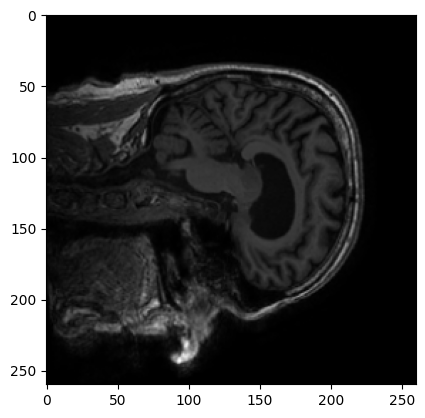

In [8]:
plt.imshow(I0[110, :, :], cmap="gray")

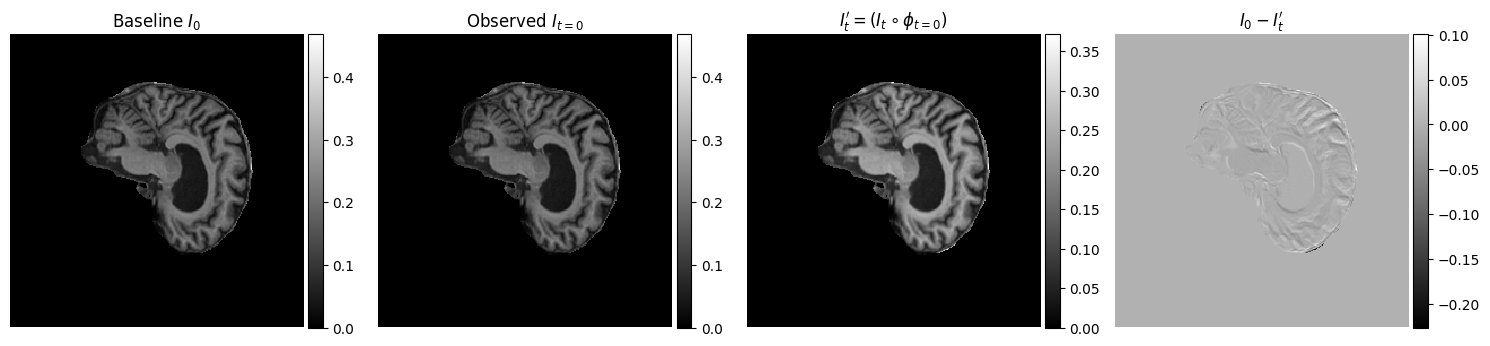

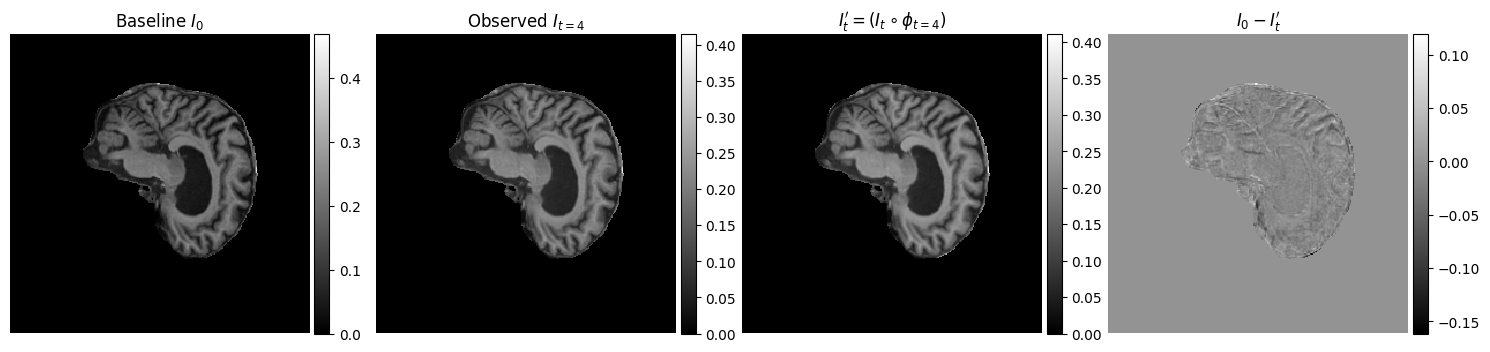

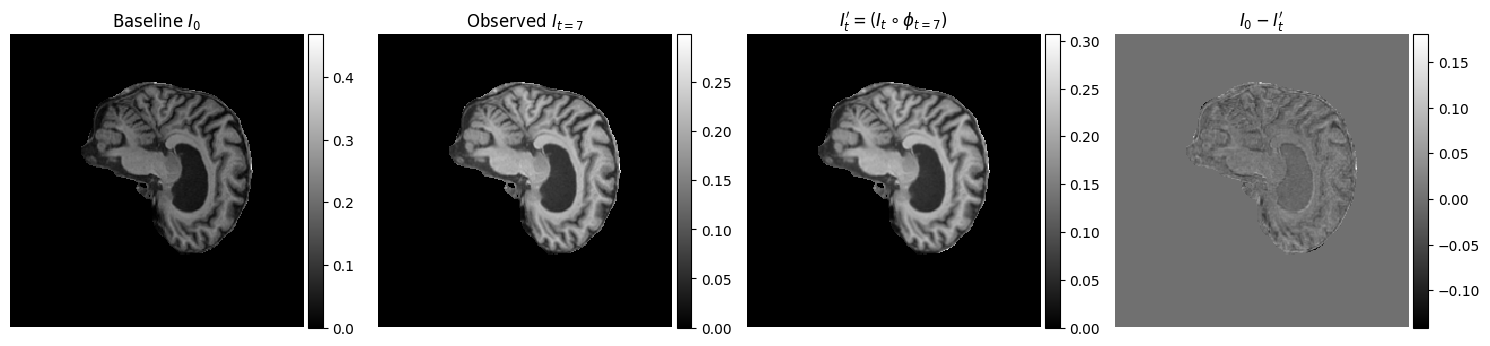

In [9]:
#visualising residuals
def image_masking(img, mask, tdf=False):
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    if tdf == True:
        return img
    return img * mask


num_slice = 110
image_mask_2d = I0_mask[num_slice, :, :]
I0_2d = I0[num_slice, :, :]
masked_I0 = image_masking(I0_2d, image_mask_2d, False)

video_images = []
video_titles = []
for idx, t in enumerate(observed_time_points):
    if t in time:
        img = It[idx]
        It_2d = img[num_slice, :, :]
        moved_2d = stack_moved_images[idx][num_slice, :, :]
        tdf_2d = stack_tdf[idx][num_slice, :, :].cpu().numpy()
        masked_It = image_masking(It_2d, image_mask_2d, False)

        masked_moved = image_masking(moved_2d, image_mask_2d, False)
        masked_tdf = image_masking(tdf_2d, image_mask_2d, True)
        residual = masked_I0 - masked_moved

        # images = [masked_I0, masked_It, masked_moved,  residual , masked_tdf[..., 2]] 
        images = [masked_I0, masked_It, masked_moved, residual]

        titles = [
            r'Baseline $I_0$',
            r'Observed $I_{t=' + str(t) + '}$',
            r"$I_{t}' = (I_t \circ \phi_{t=" + str(t) + "})$",
            r"$I_0 - I_{t}'$",
        ]
        video_images.append(images)
        video_titles.append(titles)
        ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

        wandb.log({"Transformed images": [wandb.Image(image, caption=title) for image, title in zip(images, titles)]})

### EVALUATING |J| maps

/tmp/ipykernel_748110/3350422351.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.9])  # Adjust layout to fit title and colorbar


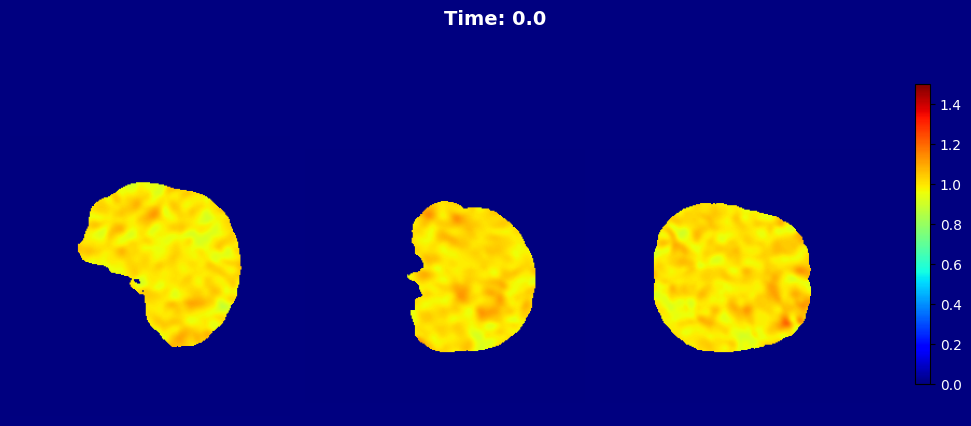

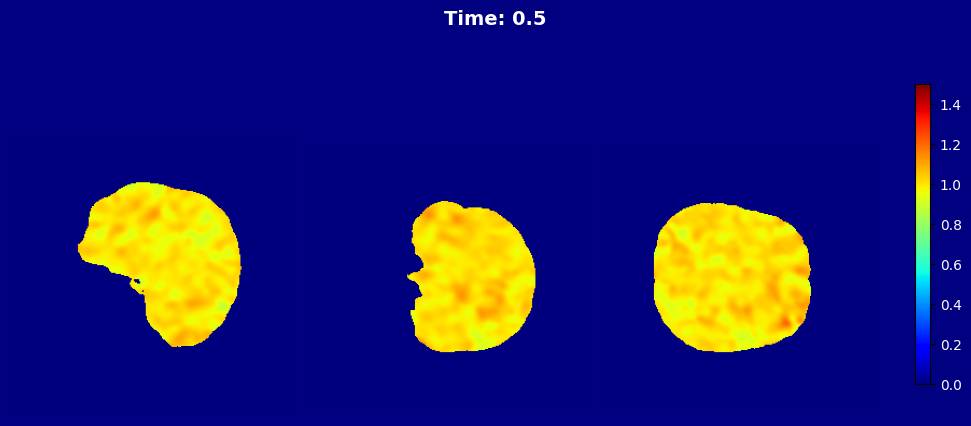

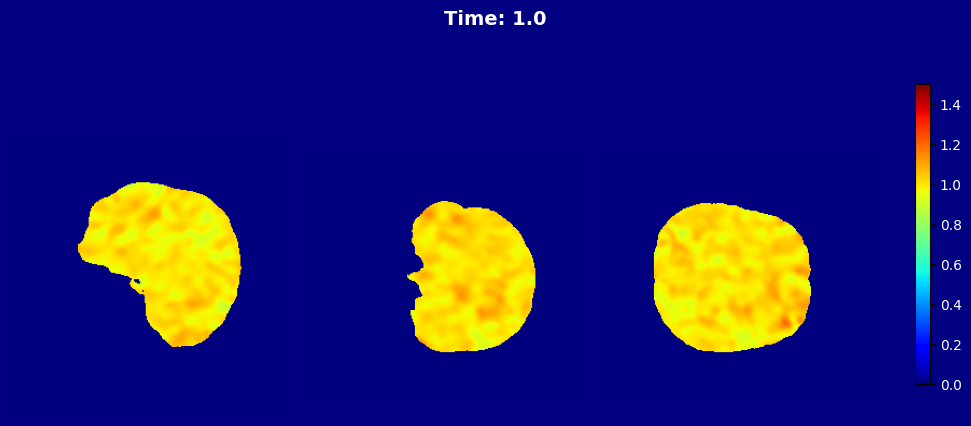

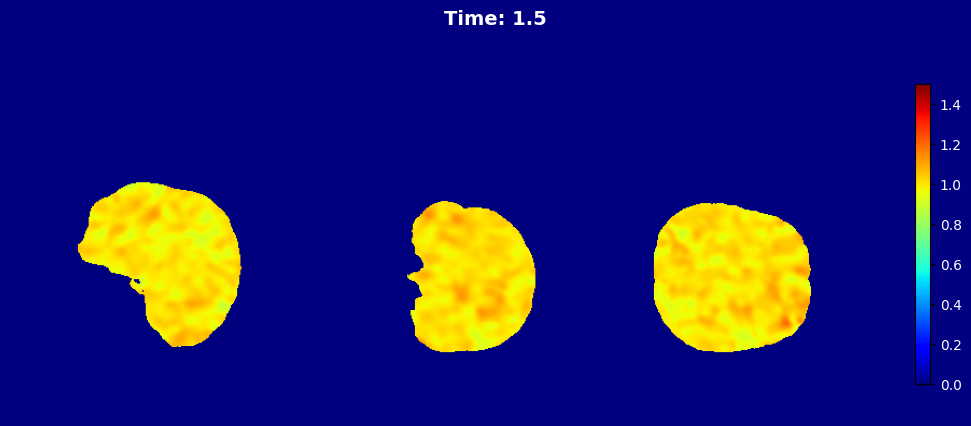

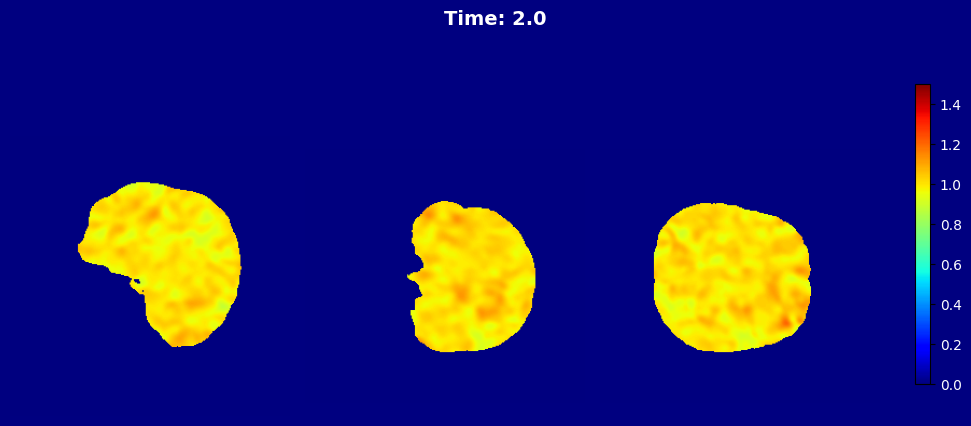

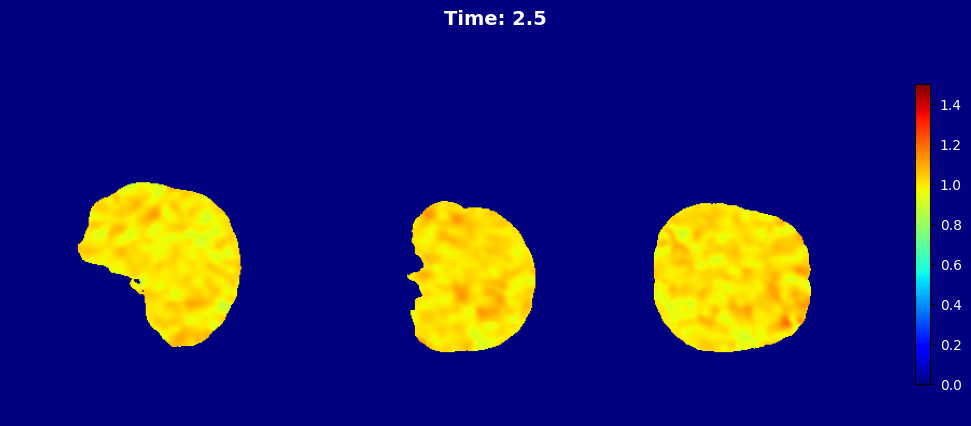

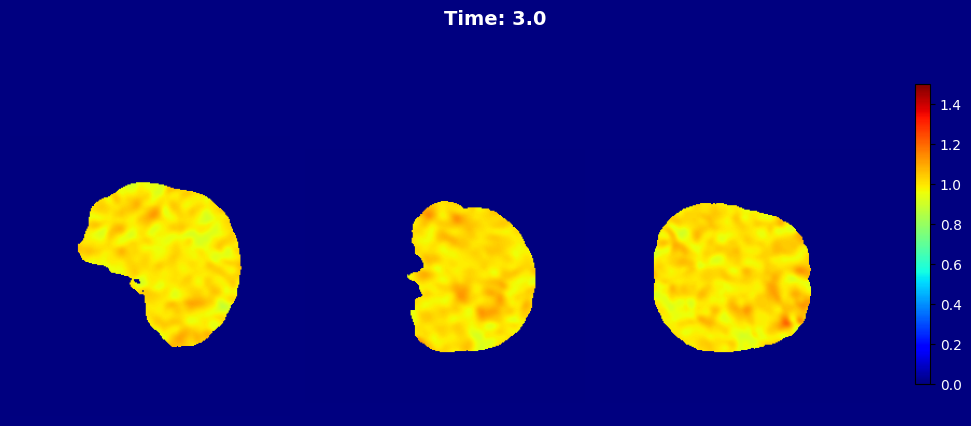

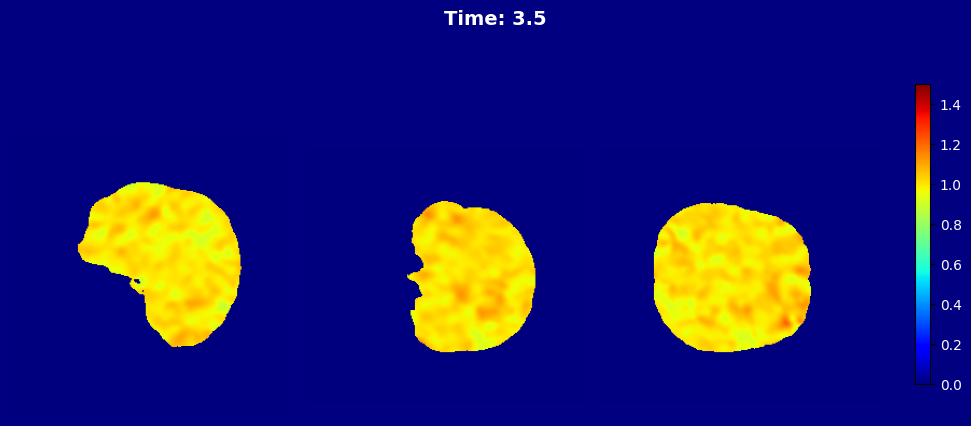

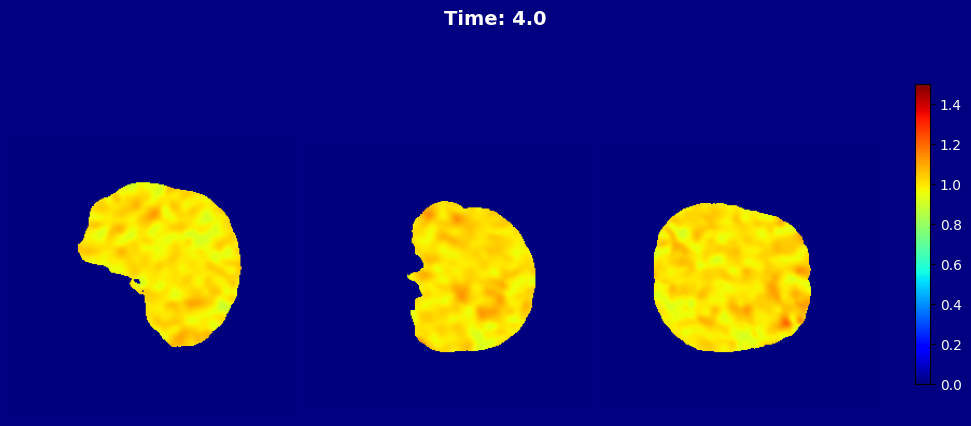

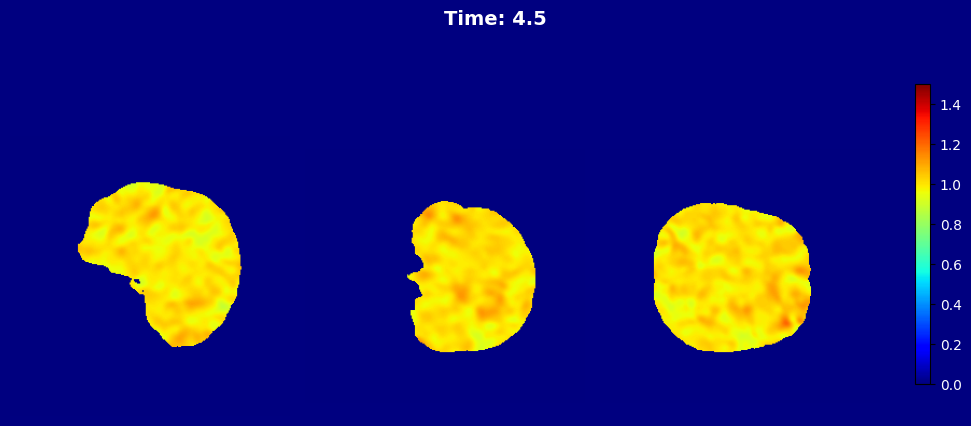

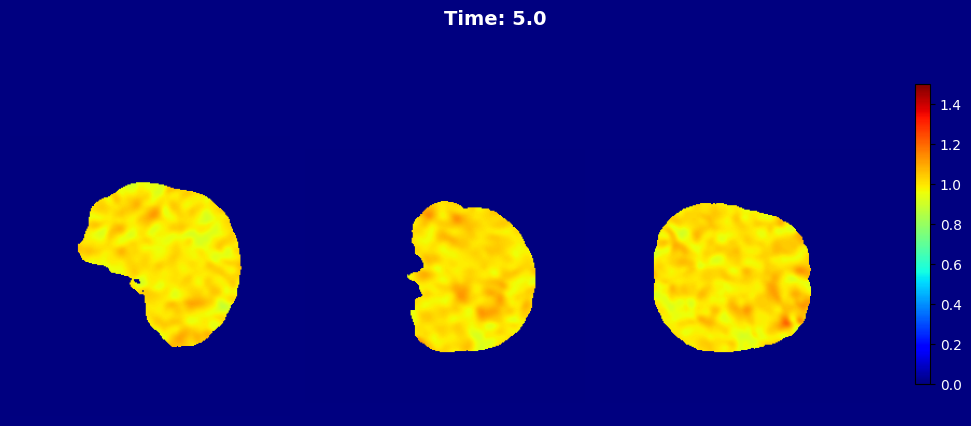

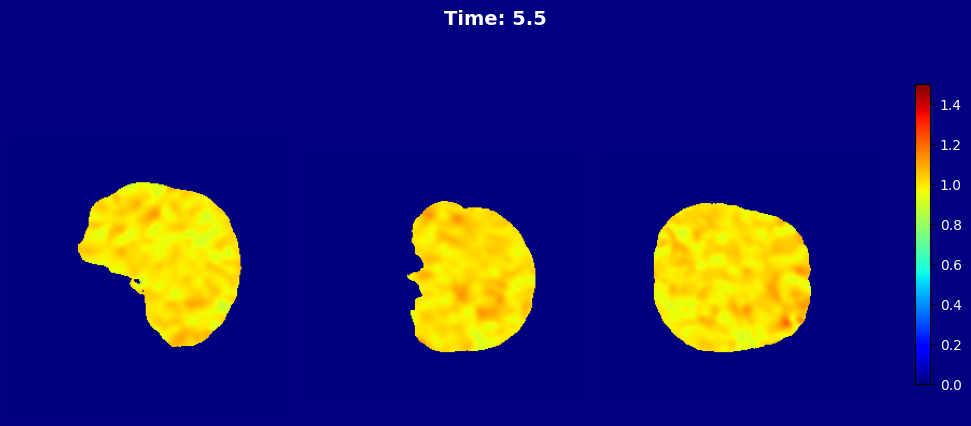

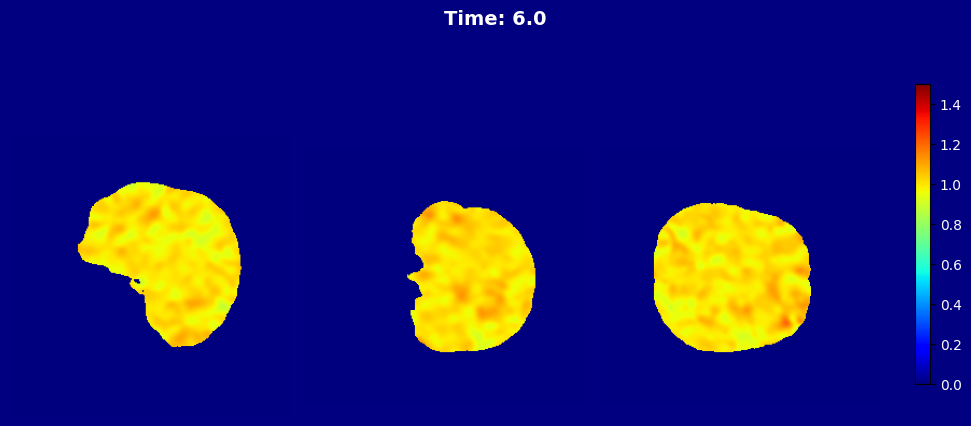

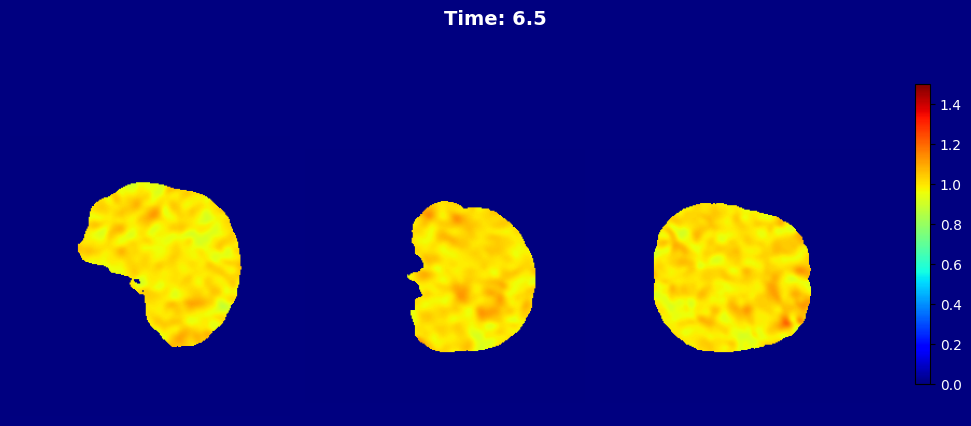

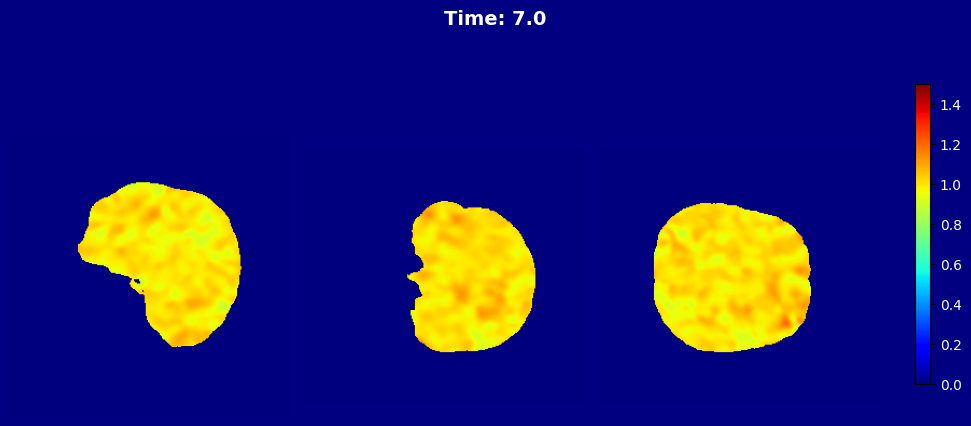

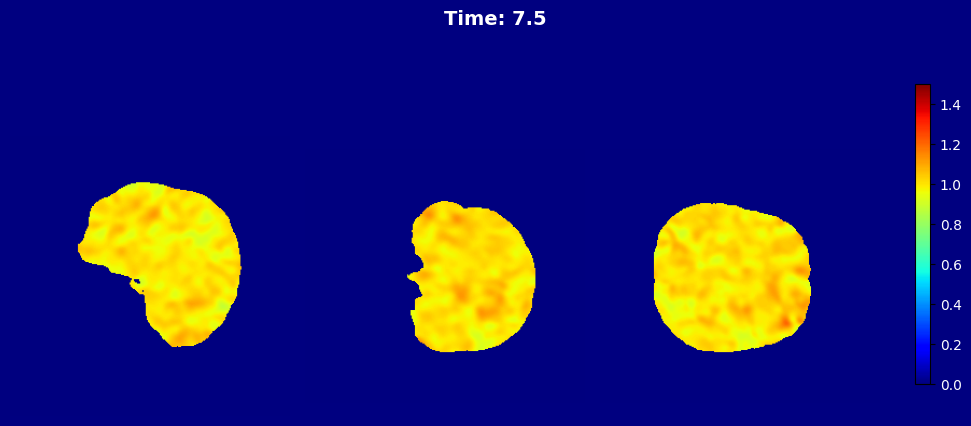

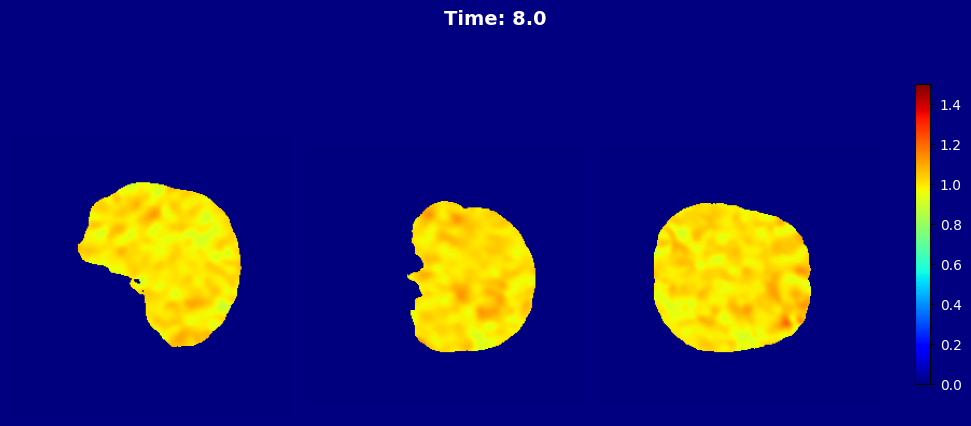

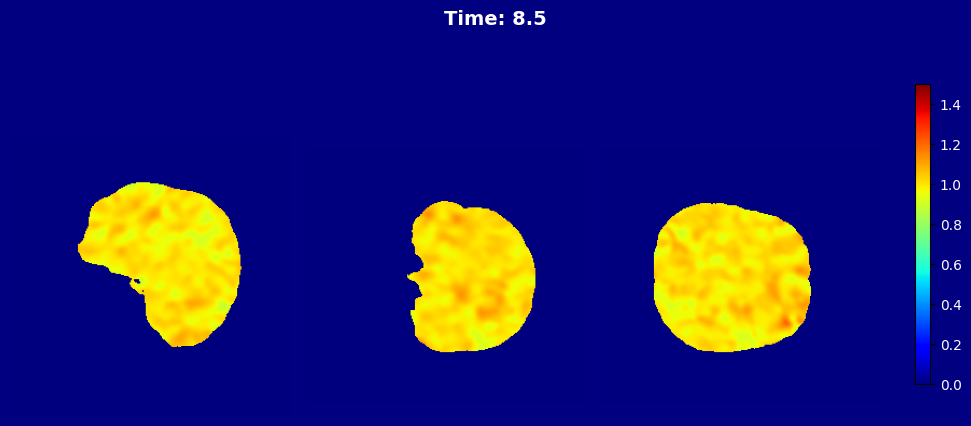

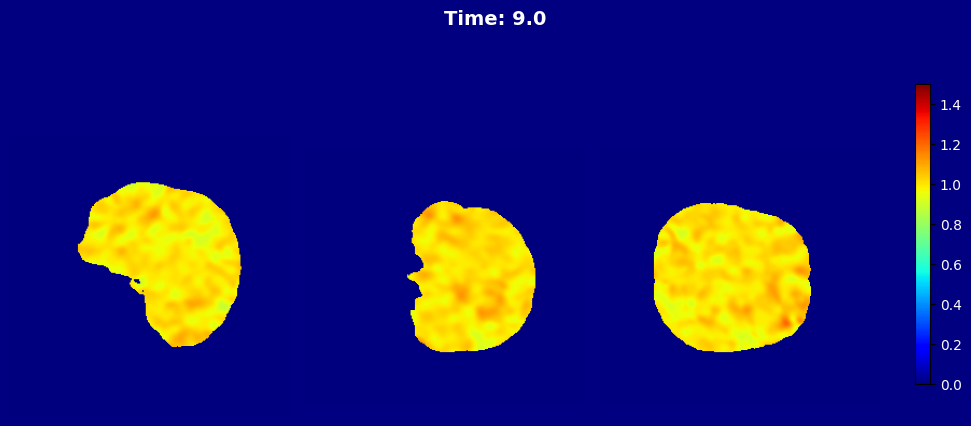

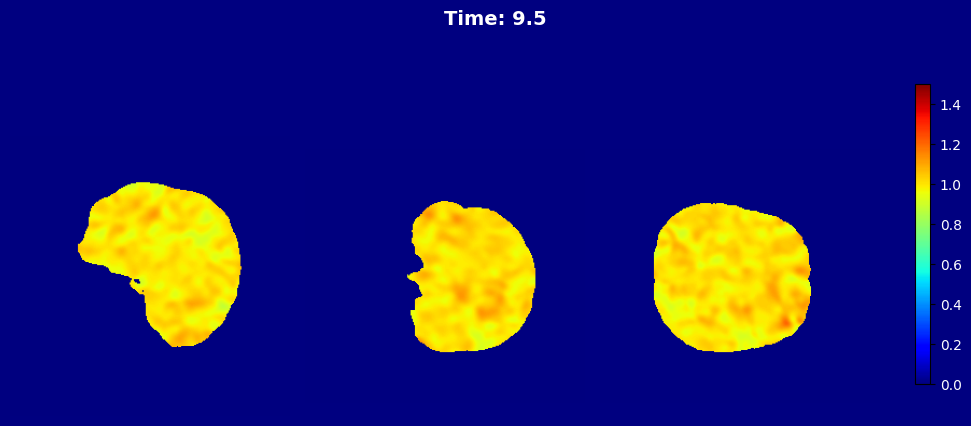

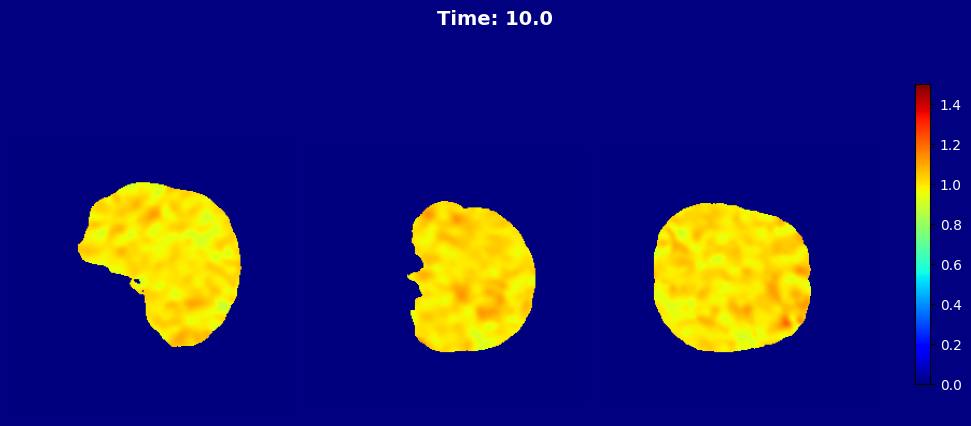

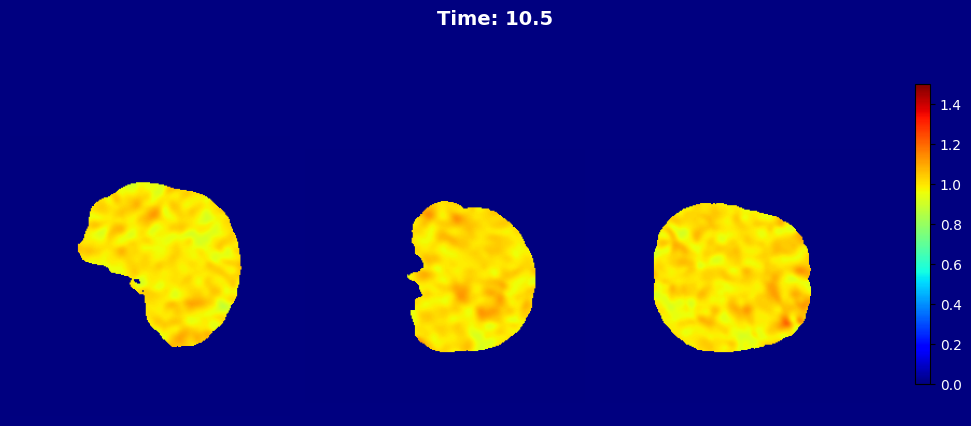

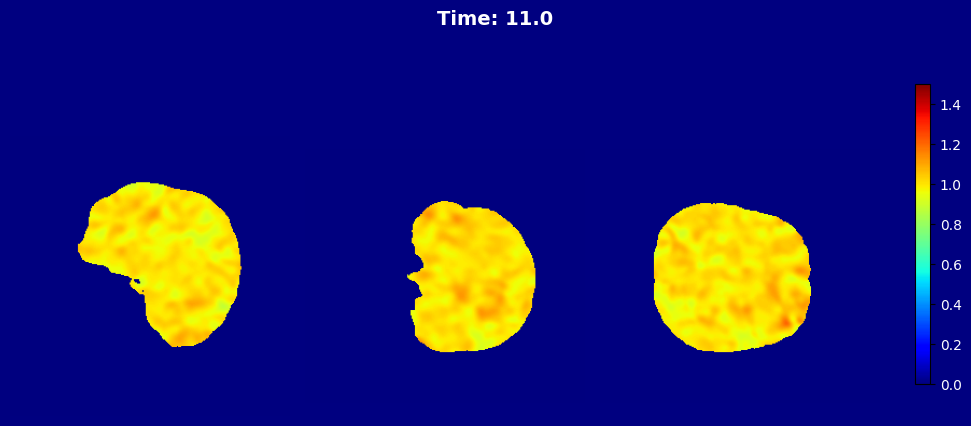

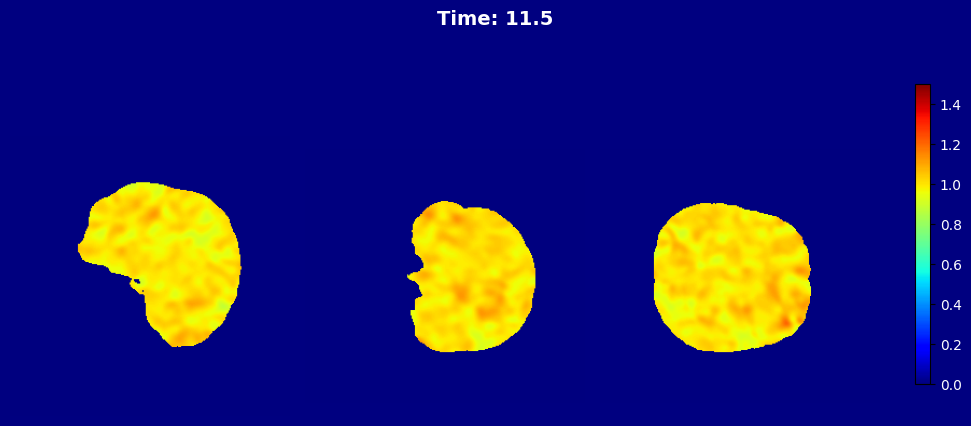

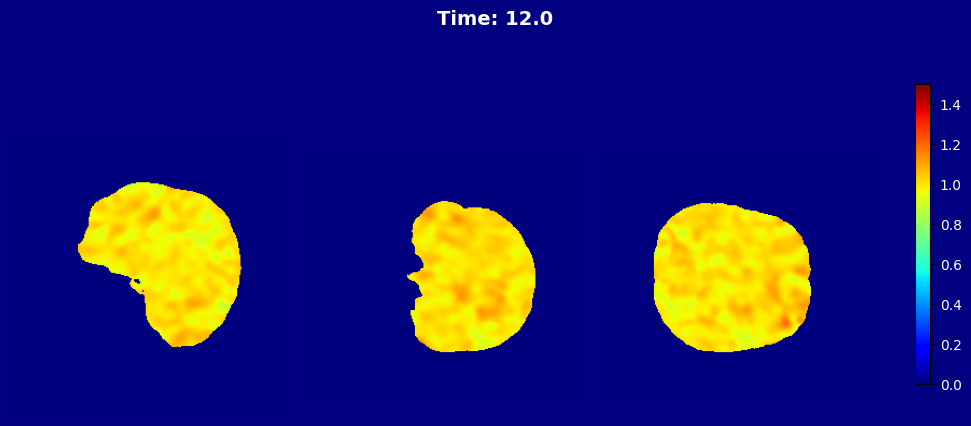

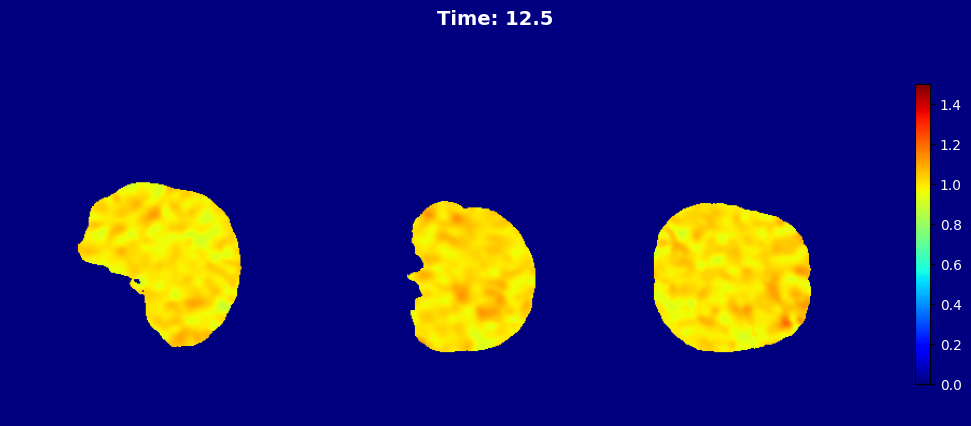

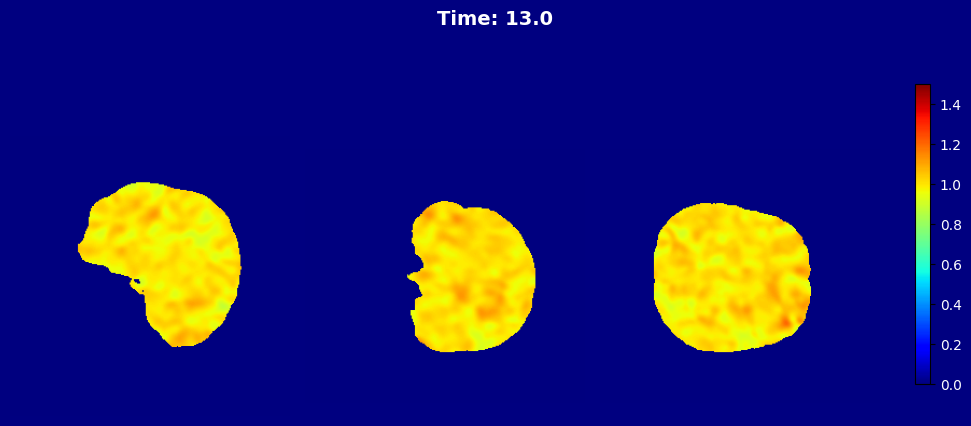

In [10]:
def preview_image(jacobian_det, mask, time, normalize_by="volume", cmap="jet", figsize=(10, 5), threshold=None):
    """
    Display three orthogonal slices of the given 3D image and the corresponding I0 slices.

    jacobian_det is assumed to be of shape (H,W,D)
    """

    
    # Set colorbar range and background color
    vmin, vmax = 0, 1.5  # Fixed range for the colorbar
    background_color = (0, 0, 0.5)  # Dark blue background color (RGB normalized)

    # Define region for visualization based on mask
    rows, cols, dep = np.where(mask > 0)
    x1, x2 = min(rows), max(rows)
    y1, y2 = min(cols), max(cols)
    z1, z2 = min(dep), max(dep)

    x, y, z = 110, 130, 160
    jac_det_slices = (jacobian_det[x, :, :], jacobian_det[:, y, :], jacobian_det[:, :, z])

    fig, axs = plt.subplots(1, 3, figsize=figsize, facecolor=background_color)

    fig.suptitle(f"Time: {time}", fontsize=14, weight='bold', y=0.95, color="white")

    # Display each slice
    for idx, img in enumerate(jac_det_slices):
        ax = axs[idx]
        ax.axis("off")
        ax.set_facecolor(background_color)
        im = ax.imshow(img, origin="upper", cmap=cmap, vmin=vmin, vmax=vmax)

        # Optional: Apply threshold overlay
        if threshold is not None:
            red_overlay = np.zeros(img.shape + (4,))
            red_overlay[img <= threshold] = [1, 0, 0, 1]  # Red for below threshold
            ax.imshow(red_overlay, origin="upper")

    # Single colorbar for all slices
    cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.6])  # Position for colorbar, narrower and more compact
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelcolor='white')  # White color for colorbar ticks

    # Adjust layout for even tighter spacing
    plt.subplots_adjust(wspace=0.01, left=0.05, right=0.85)  # Minimal space between slices and set tighter margins

    plt.tight_layout(rect=[0, 0, 0.9, 0.9])  # Adjust layout to fit title and colorbar
    wandb.log({"Jacobian Maps": wandb.Image(fig)})
    plt.show()
    return fig


# Loop through time points
video_jacobian_maps = []
for idx, selected_time in enumerate(time):
    det = stack_total_jac_det[idx] * I0_mask
    fig = preview_image(det, I0_mask, selected_time, normalize_by="slice", threshold=-1)
    video_jacobian_maps.append(fig)

In [ ]:
def preview_image(jacobian_det, mask, I0, time, normalize_by="volume", cmap=None, figsize=(12, 12), threshold=None):
    """
    Display three orthogonal slices of the given 3D image and the corresponding I0 slices.

    jacobian_det is assumed to be of shape (H,W,D)

    If a number is provided for threshold, then pixels for which the value
    is below the threshold will be shown in red
    """
    if normalize_by == "slice":
        vmin = None
        vmax = None

    elif normalize_by == "volume":
        vmin = jacobian_det.min().item()
        # vmax = jacobian_det.max().item()
        vmax = jacobian_det.max().item()

    else:
        raise (ValueError(f"Invalid value '{normalize_by}' given for normalize_by"))

    # half-way slices
    rows, cols, dep = np.where(mask > 0)
    x1, x2, = min(rows), max(rows)
    y1, y2 = min(cols), max(cols)
    z1, z2 = min(dep), max(dep)

    # x, y, z = np.array(jacobian_det.shape) // 2
    x = 120
    y = 125
    z = 120
    jac_det_slices = (jacobian_det[x, :, :], jacobian_det[:, y, :], jacobian_det[:, :, z])

    I0_slices = (I0[x, :, :], I0[:, y, :], I0[:, :, z])

    # jac_det_slices = (jacobian_det[x, y1:y2, z1:z2], jacobian_det[x1:x2, y, z1:z2], jacobian_det[x1:x2, y1:y2, z])

    # I0_slices = (I0[x, y1:y2, z1:z2], I0[x1:x2, y, z1:z2], I0[x1:x2, y1:y2, z])
    fig, axs = plt.subplots(2, 3, figsize=figsize)

    for i, (img, I0_slice) in enumerate(zip(jac_det_slices, I0_slices)):
        ax = axs[0, i]
        ax.axis("off")
        gg = ax.imshow(img, origin="upper", cmap="RdBu")  #cmap coolwarm, RdBu, jet

        if threshold is not None:
            red = np.zeros(img.shape + (4,))  # RGBA array
            red[img <= threshold] = [1, 0, 0, 1]
            ax.imshow(red, origin="upper")

        # Add colorbar for the image slice
        cbar = fig.colorbar(gg, ax=ax, fraction=0.046, pad=0.05)
        # cbar.ax.tick_params(labelsize=8)

        ax = axs[1, i]
        ax.axis("off")
        hh = ax.imshow(I0_slice, origin="upper", cmap="gray")

        # Add colorbar for the I0 slice
        cbar = fig.colorbar(hh, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
        fig.tight_layout()

        text = f"""
        Time: {time}
        Number of folds: {(det <= 0).sum()}
        Number of expansion: {(det > 1).sum()}
        Number of contraction: {((det > 0) & (det < 1)).sum()}
        Number of voxels without change: {(det == 1).sum()}
        |J| min, max and mean: {float(det.min().item()):.2f}, {float(det.max().item()):.2f}, {float(det.mean().item()):.3f}
        
        """
    ax.set_facecolor("yellow")
    plt.figtext(0.7, 0.90, text, ha="left", fontsize=10,
                bbox={"facecolor": "white", "edgecolor": "white", "alpha": 0, "pad": 5, "linewidth": 3})
    wandb.log({"Jacobian Maps": wandb.Image(fig)})
    plt.show()
    return fig


video_jacobian_maps = []
for idx, selected_time in enumerate(time):
    det = stack_total_jac_det[idx]
    mvd = stack_moved_images[idx]
    mvd = (mvd - np.min(mvd)) / (np.max(mvd) - np.min(mvd))
    mvd = mvd * I0_mask
    fig = preview_image(det, I0_mask, mvd, selected_time, normalize_by="slice", threshold=0)
    video_jacobian_maps.append(fig)
plt.close(fig)


In [ ]:
def preview_image(jacobian_det, mask, I0, time, normalize_by="slice", cmap="jet", alpha=0.5, figsize=(12, 12),
                  threshold=None):
    """
    Display three orthogonal slices of the given 3D image with an overlay of the masked Jacobian determinant map.

    jacobian_det is assumed to be of shape (H, W, D)

    If a number is provided for threshold, then pixels for which the value
    is below the threshold will be shown in red
    """
    if normalize_by == "slice":
        vmin, vmax = None, None
    elif normalize_by == "volume":
        vmin = jacobian_det.min().item()
        vmax = jacobian_det.max().item()
    else:
        raise ValueError(f"Invalid value '{normalize_by}' given for normalize_by")

    #half-way slices
    x, y, z = 120, 125, 120
    jac_det_slices = (jacobian_det[x, :, :], jacobian_det[:, y, :], jacobian_det[:, :, z])
    I0_slices = (I0[x, :, :], I0[:, y, :], I0[:, :, z])
    mask_slices = (mask[x, :, :], mask[:, y, :], mask[:, :, z])

    fig, axs = plt.subplots(1, 3, figsize=figsize)

    for i, (jac_slice, I0_slice, mask_slice) in enumerate(zip(jac_det_slices, I0_slices, mask_slices)):
        #plot the base grayscale image (unmasked)
        ax = axs[i]
        jac_slice = 1 / jac_slice  #invert the Jacobian determinant for correct visualization
        ax.imshow(I0_slice, origin="upper", cmap="gray")

        #mask the Jacobian map
        jac_slice_masked = np.ma.masked_where(mask_slice == 0, jac_slice)
        #make min and max values per slice
        vmin = jac_slice_masked.min()
        vmax = jac_slice_masked.max()
        #overlay the masked Jacobian map
        overlay = ax.imshow(jac_slice_masked, origin="upper", cmap=cmap, alpha=alpha, vmin=vmin, vmax=vmax)
        #add colorbar for the overlay
        cbar = fig.colorbar(overlay, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)

        # # Optional: apply threshold for highlighting areas in red
        # if threshold is not None:
        #     red = np.zeros(jac_slice.shape + (4,))  # RGBA array
        #     red[jac_slice <= threshold] = [1, 0, 0, 1]
        #     ax.imshow(red, origin="upper")

    fig.tight_layout()
    plt.show()
    return fig


video_jacobian_determinant_maps = []
for idx, selected_time in enumerate(time):
    det = stack_total_jac_det[idx] * I0_mask
    mvd = stack_moved_images[idx]
    mvd = (mvd - np.min(mvd)) / (np.max(mvd) - np.min(mvd))
    mvd = mvd * I0_mask
    fig = preview_image(det, I0_mask, I0, selected_time, normalize_by="slice", threshold=0)
    video_jacobian_determinant_maps.append(fig)
plt.close(fig)

0.0 1.238323450088501 0.09948732703924179


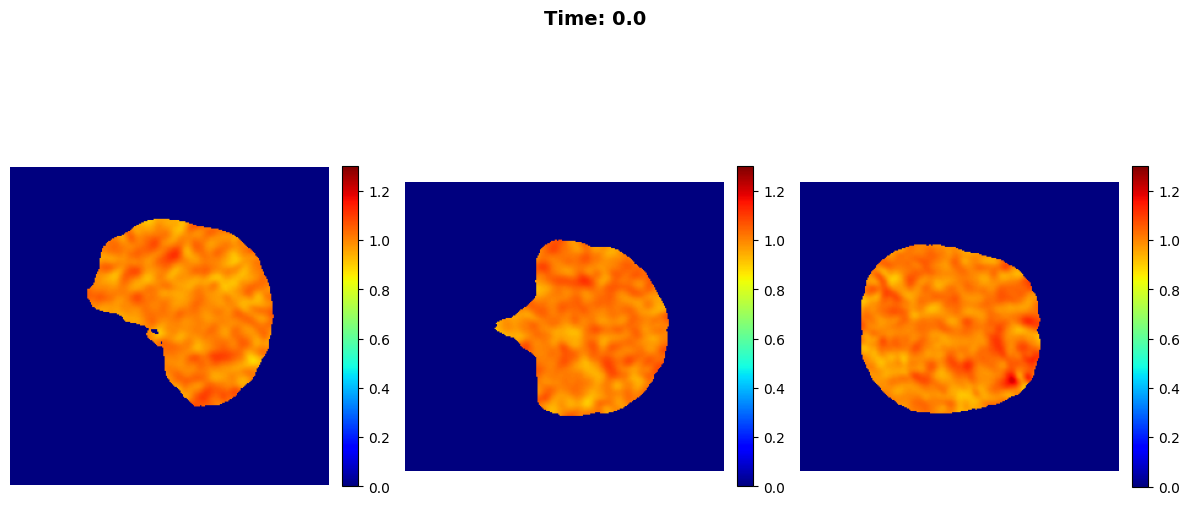

0.0 1.2381958961486816 0.09948737919330597


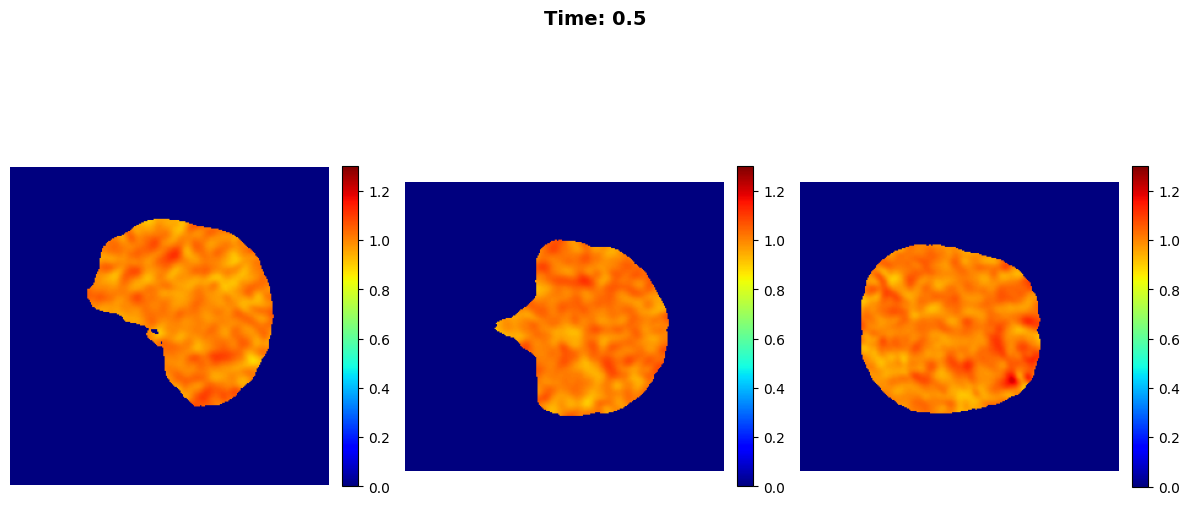

0.0 1.2380467653274536 0.09948743879795074


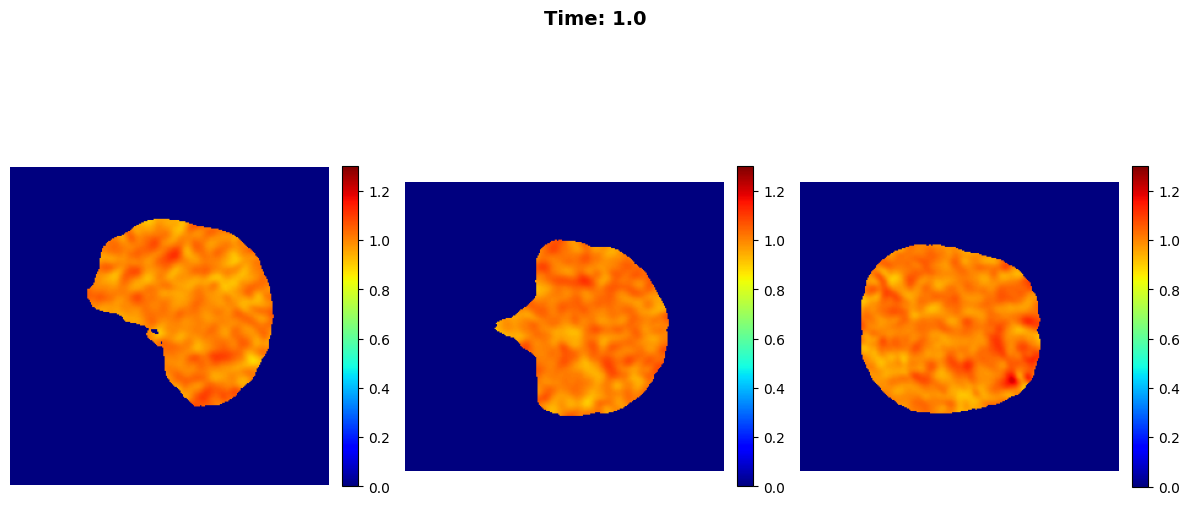

0.0 1.237930178642273 0.09948751330375671


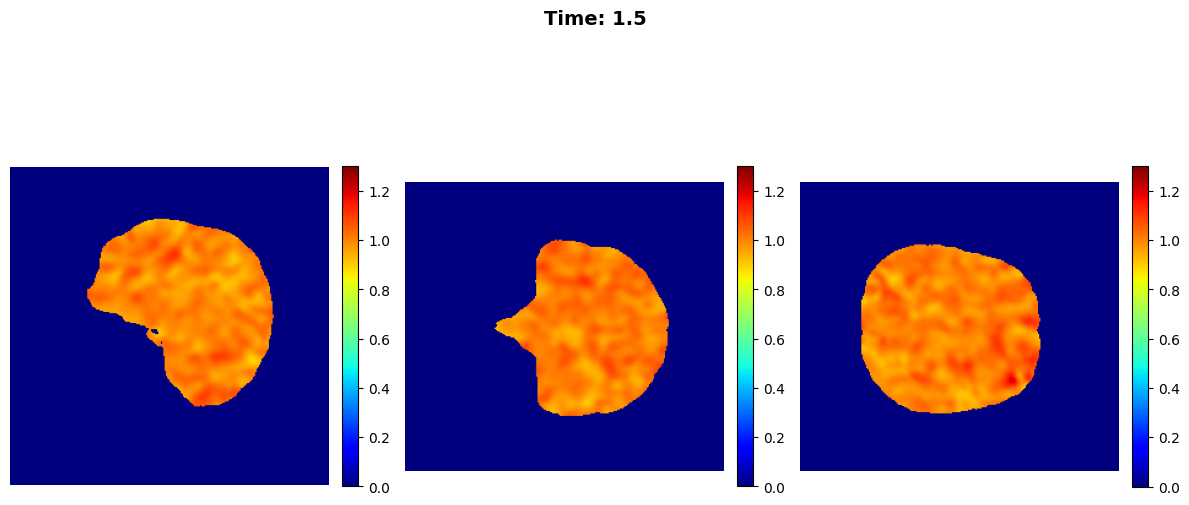

0.0 1.237783670425415 0.0994875431060791


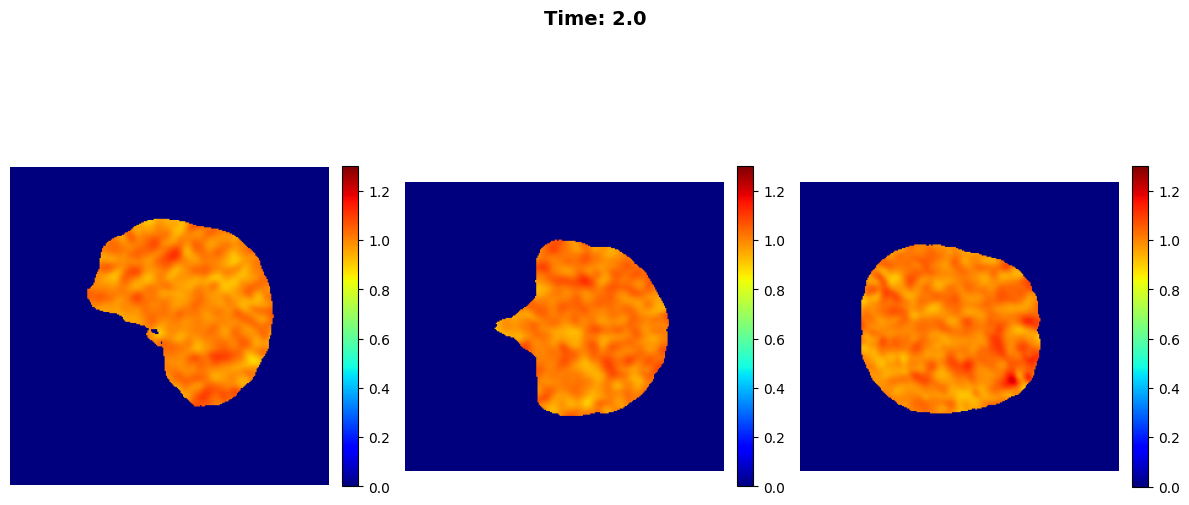

0.0 1.2375762462615967 0.09948758780956268


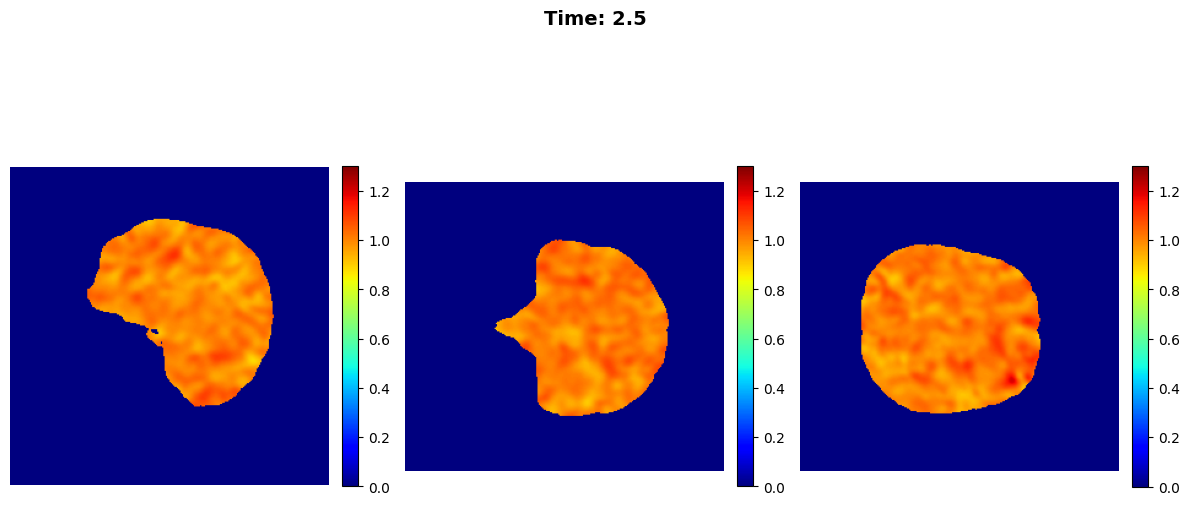

0.0 1.237416386604309 0.09948763251304626


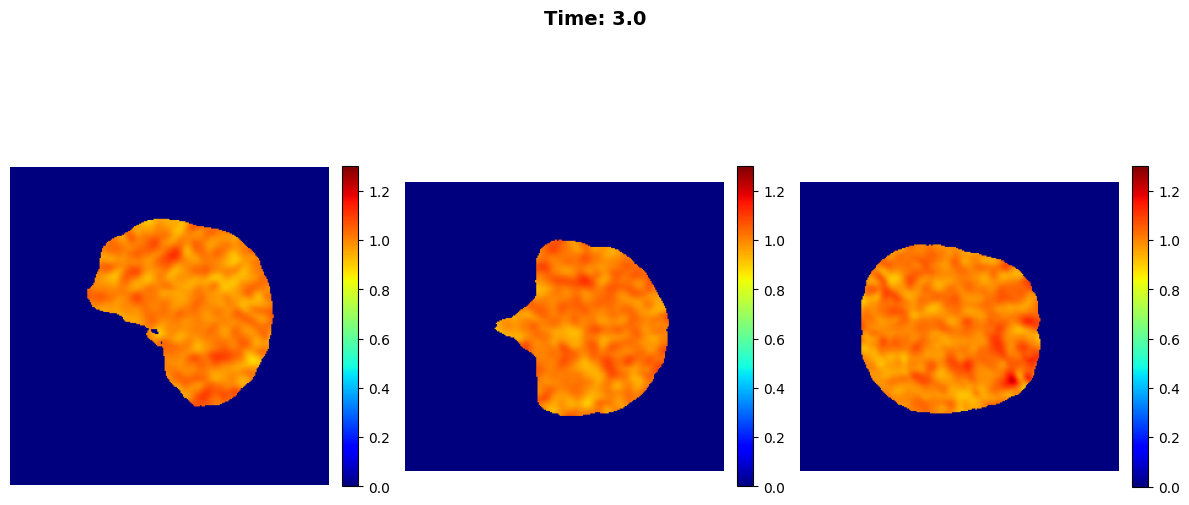

0.0 1.2372905015945435 0.09948767721652985


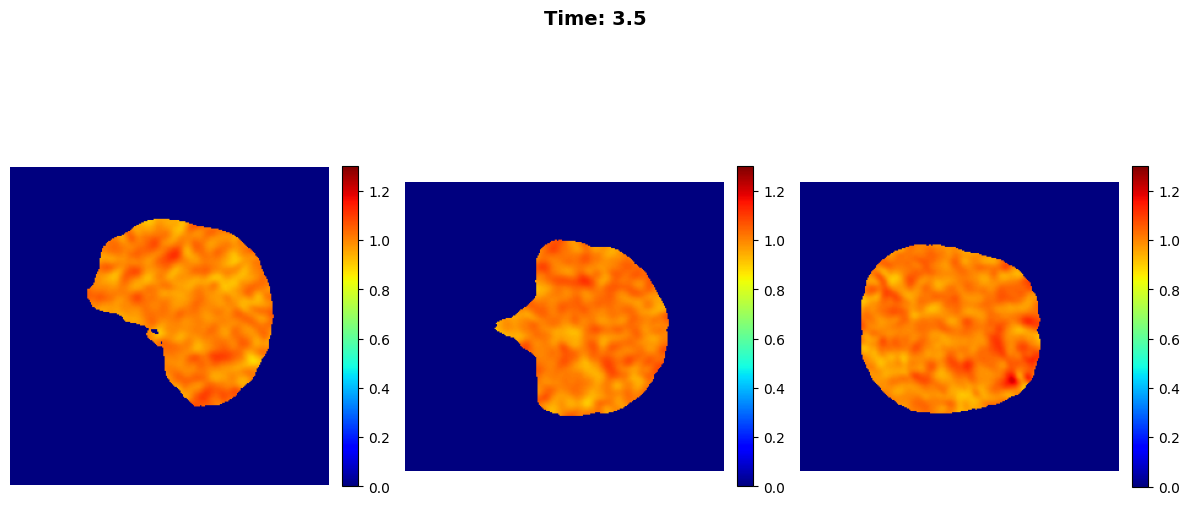

0.0 1.237121343612671 0.09948774427175522


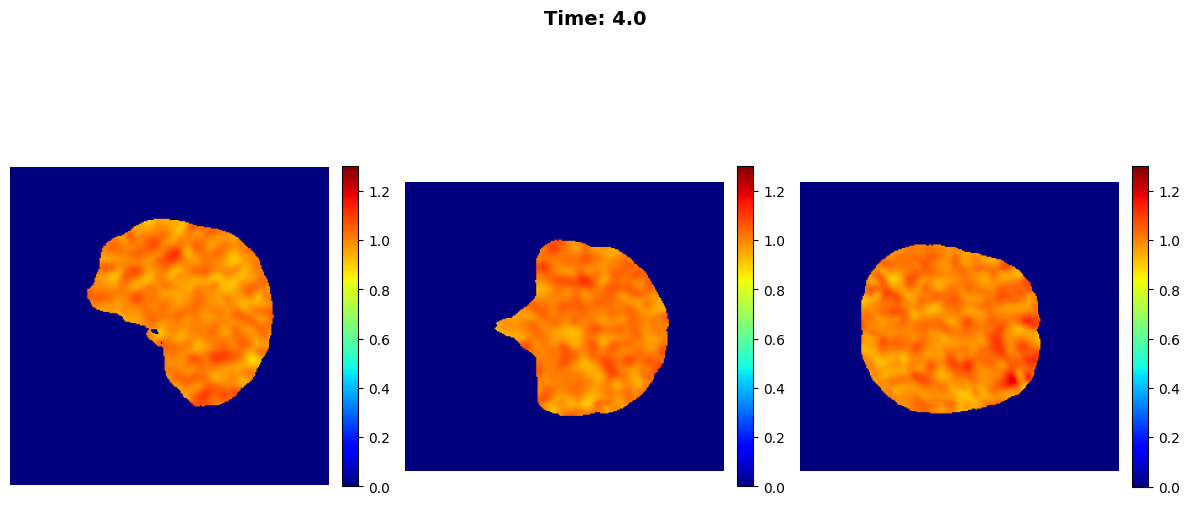

0.0 1.2369180917739868 0.0994877889752388


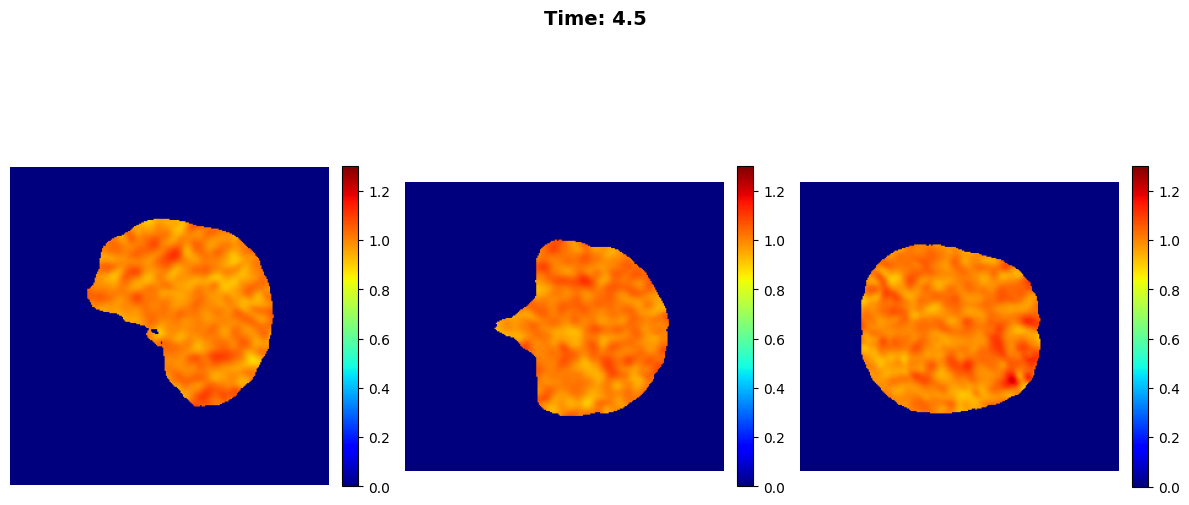

0.0 1.236789345741272 0.09948781877756119


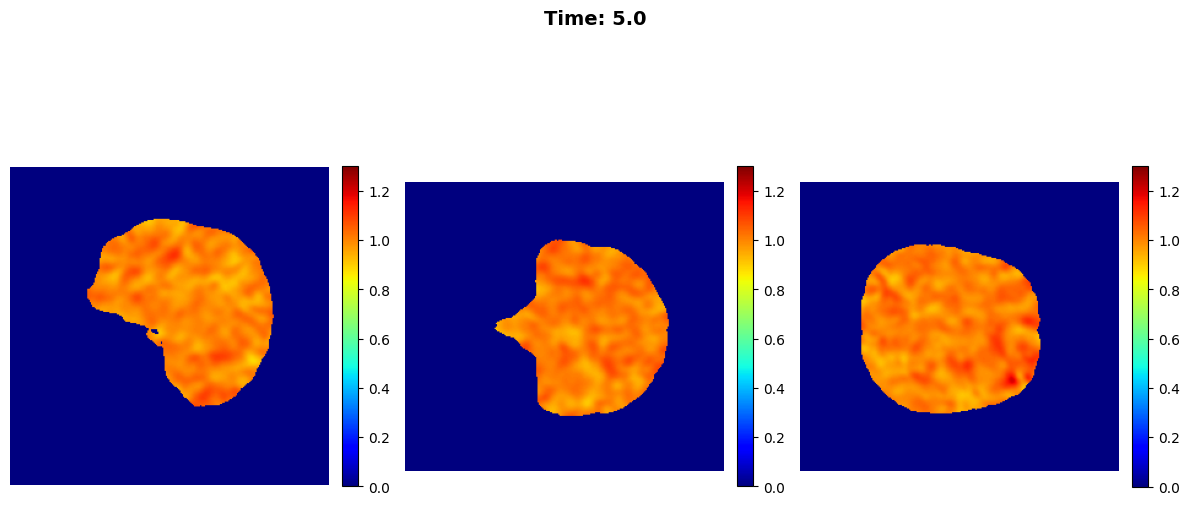

0.0 1.2366347312927246 0.09948786348104477


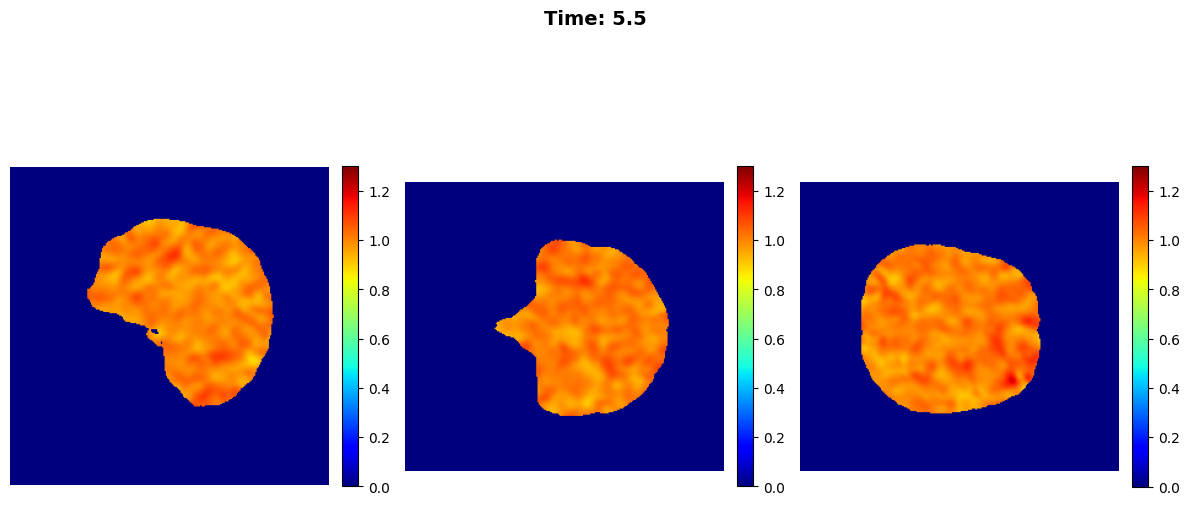

0.0 1.2364252805709839 0.09948791563510895


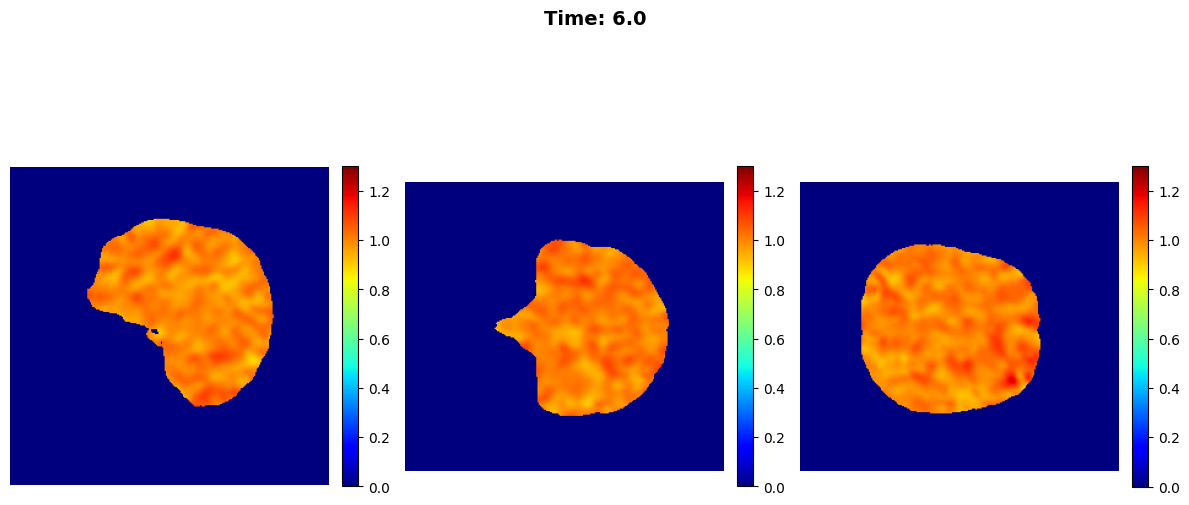

0.0 1.2363276481628418 0.09948796033859253


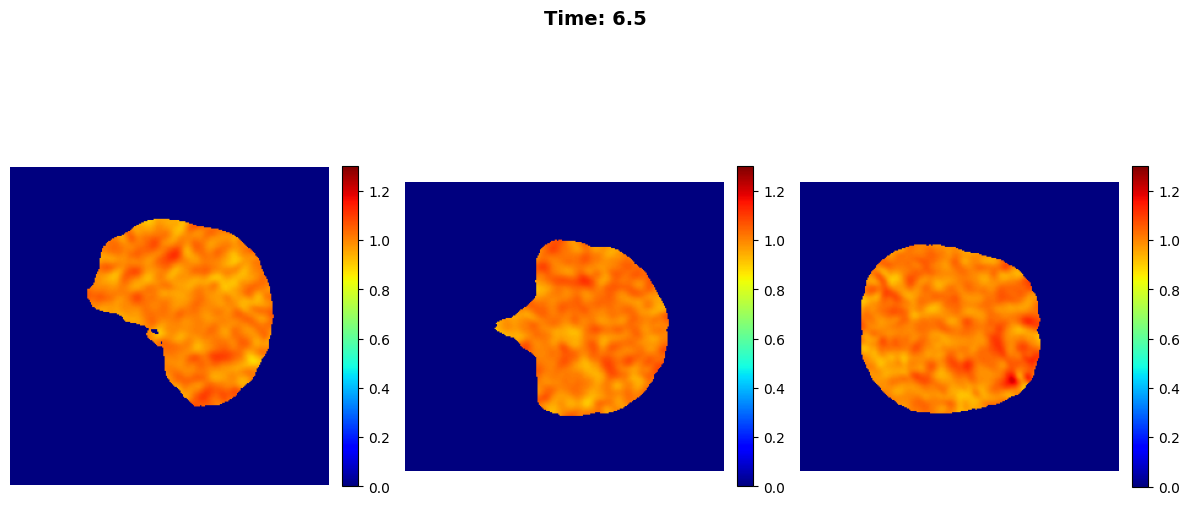

0.0 1.2360517978668213 0.09948798269033432


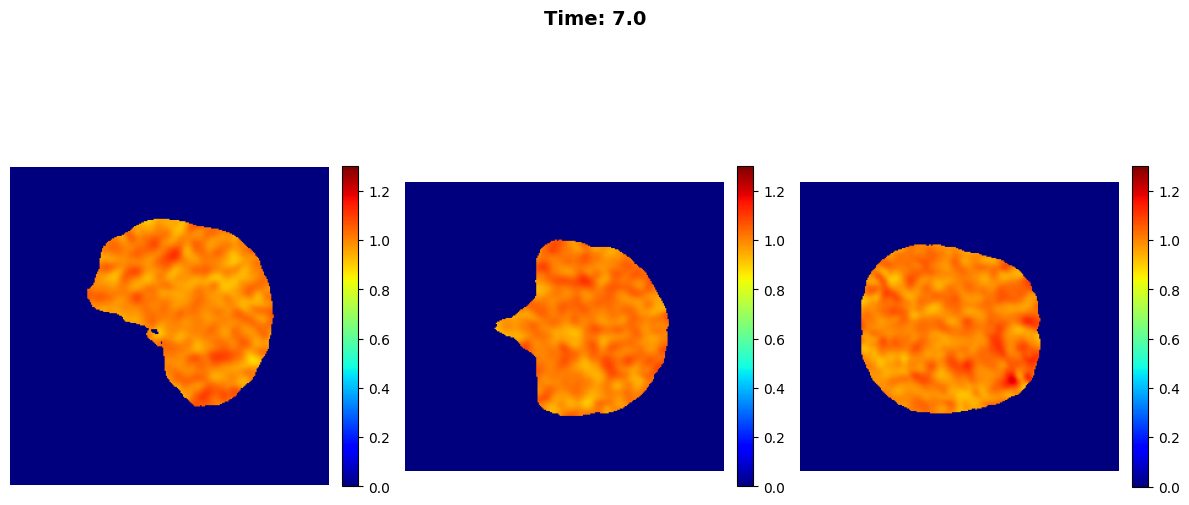

0.0 1.2359766960144043 0.09948801249265671


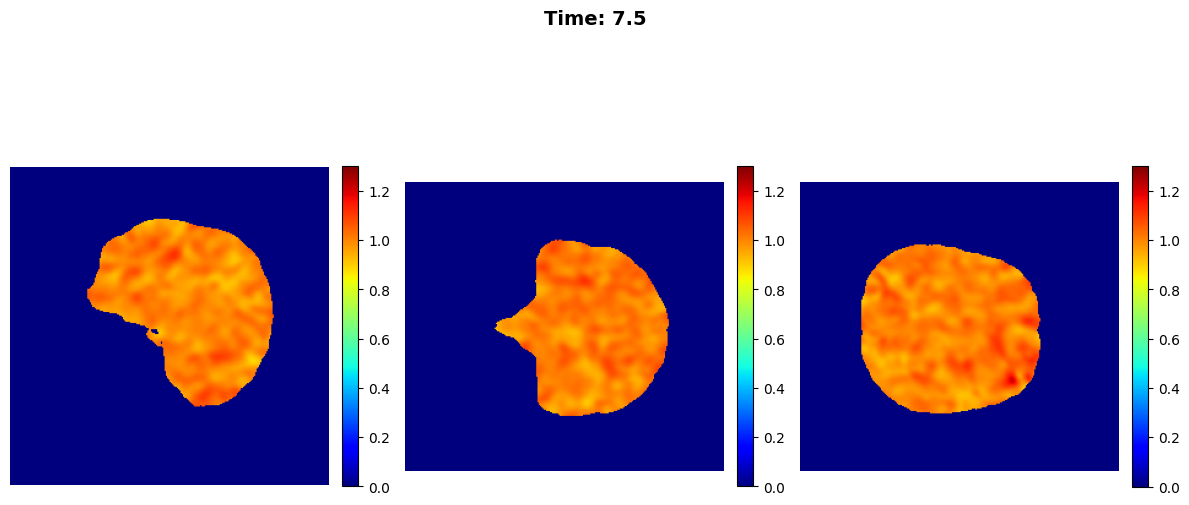

0.0 1.2357927560806274 0.09948807209730148


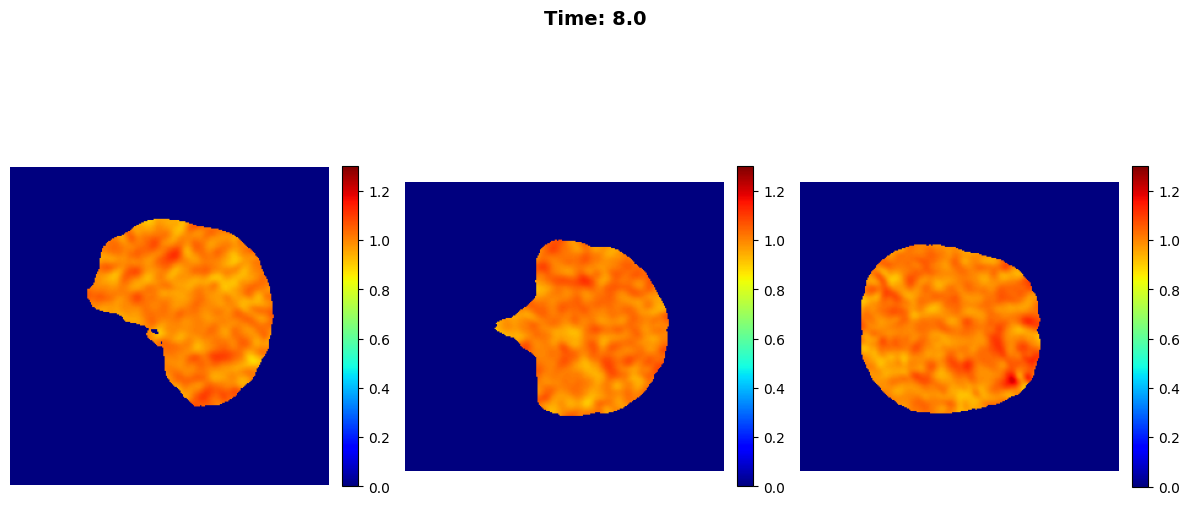

0.0 1.235605001449585 0.09948810189962387


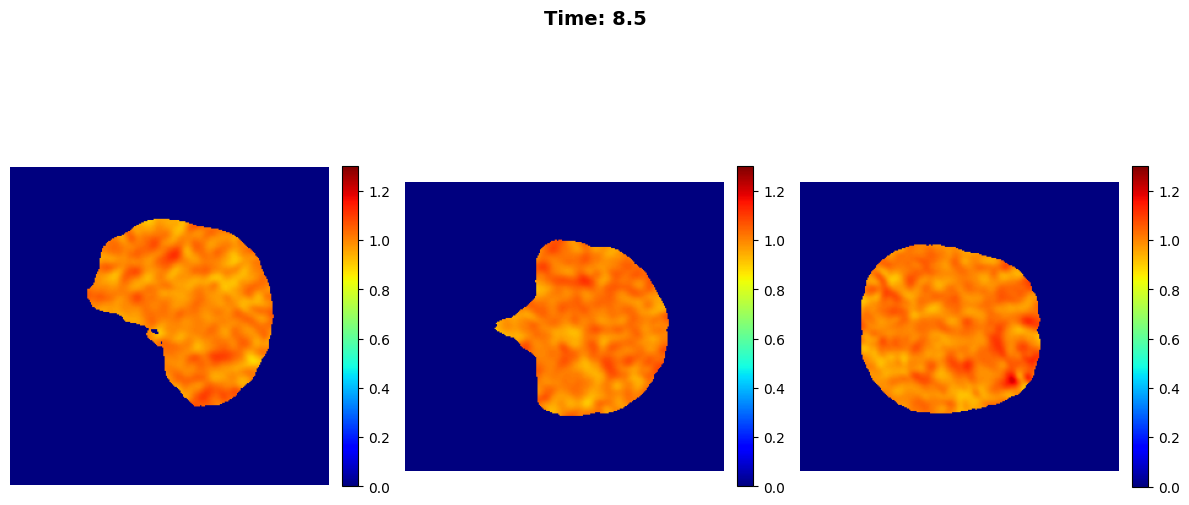

0.0 1.2354027032852173 0.09948812425136566


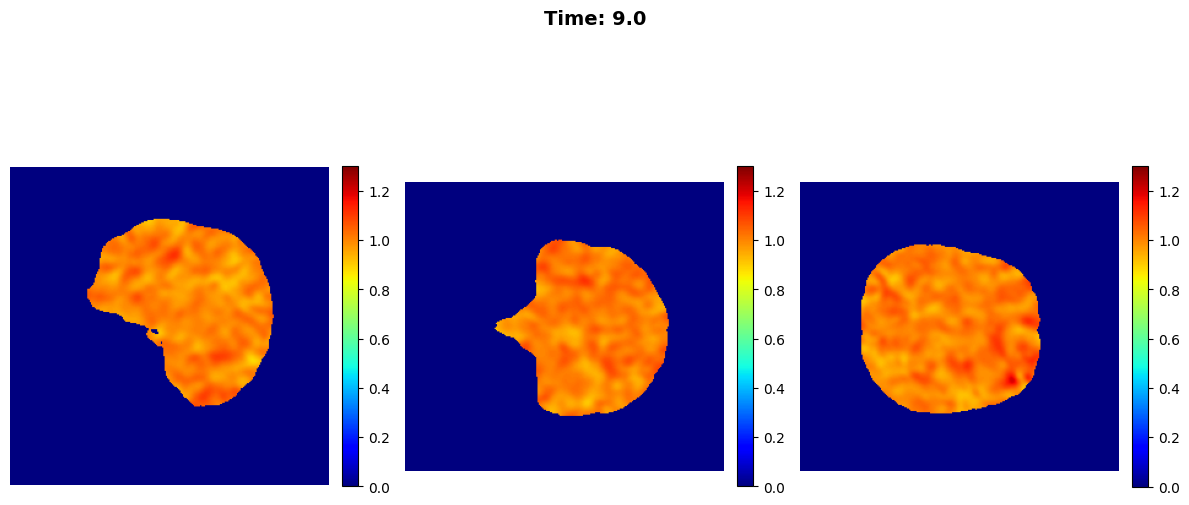

0.0 1.2353355884552002 0.09948813915252686


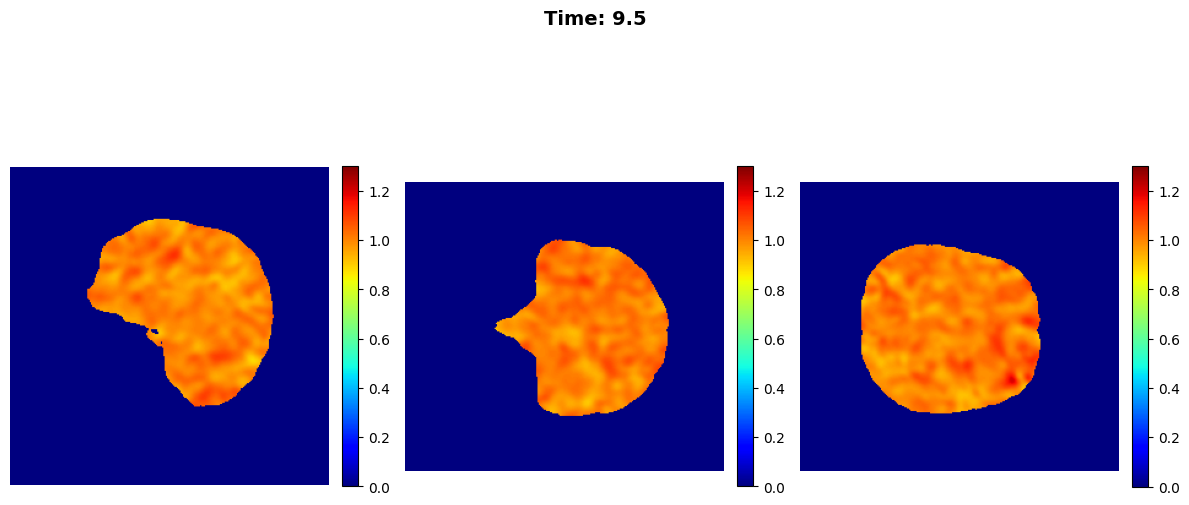

0.0 1.2350884675979614 0.09948817640542984


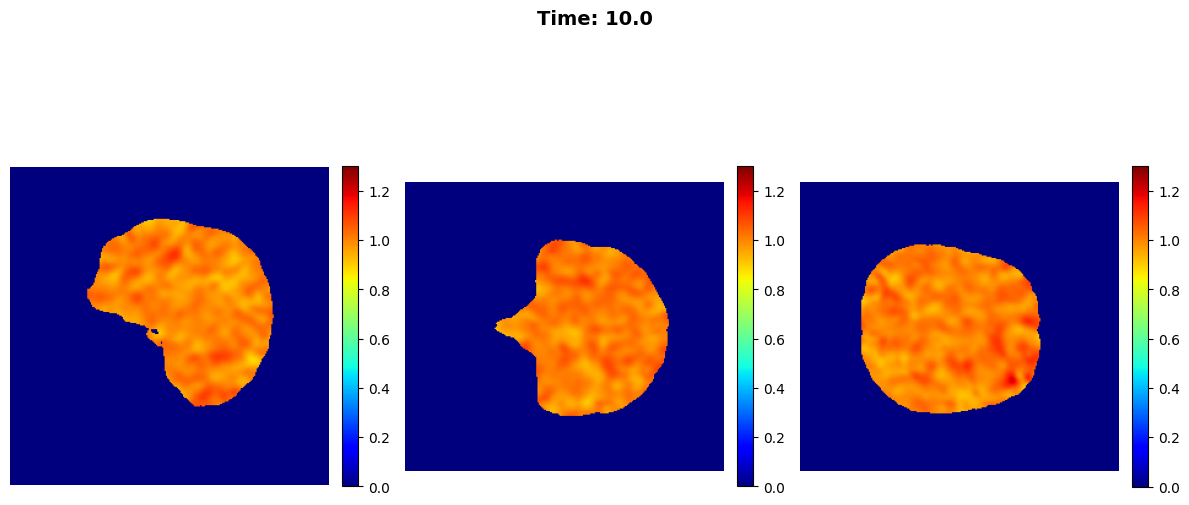

0.0 1.2349865436553955 0.09948819130659103


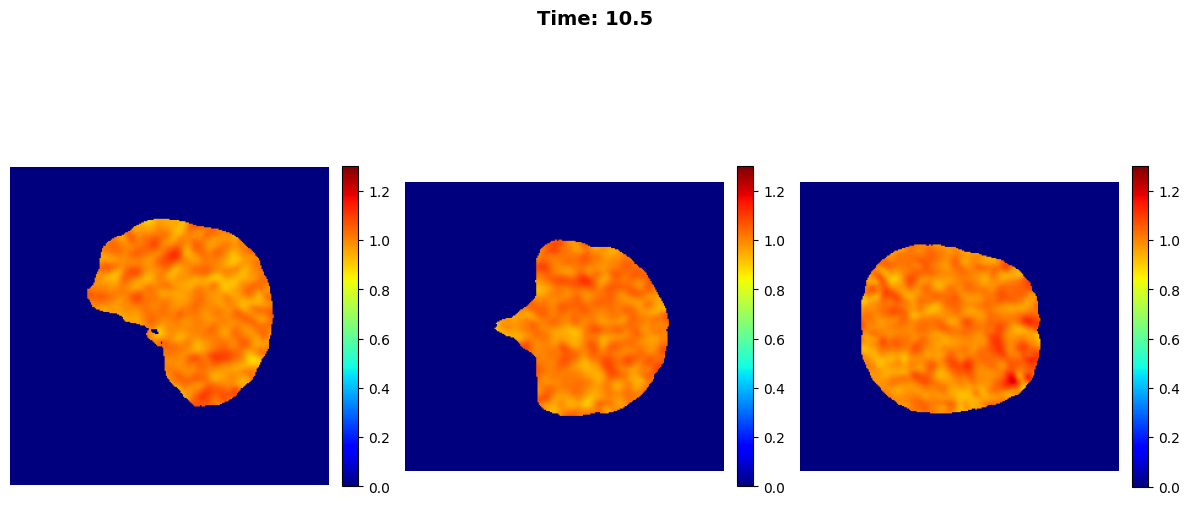

0.0 1.234771490097046 0.09948813170194626


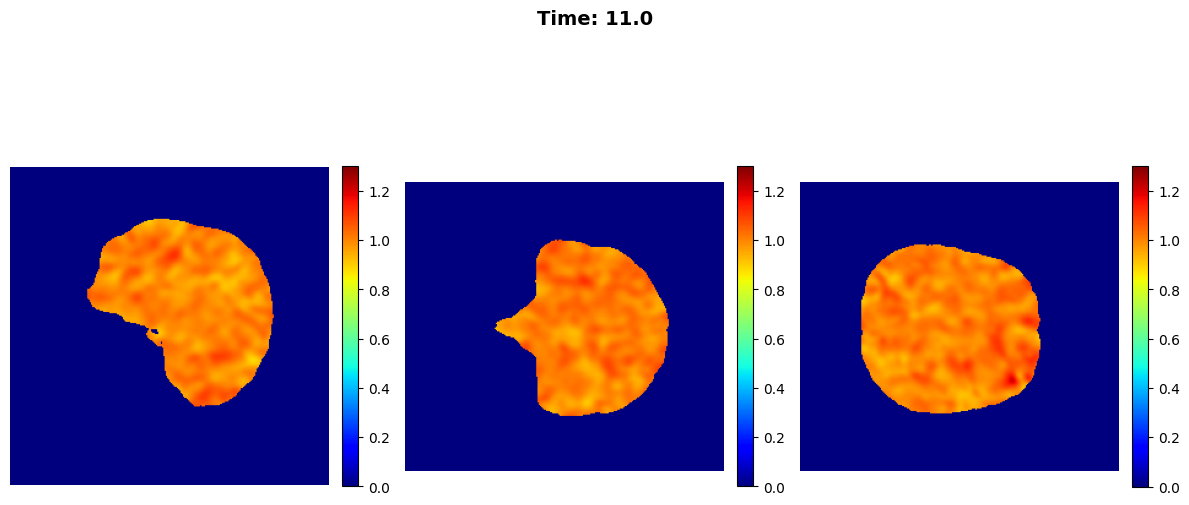

0.0 1.234724760055542 0.09948795288801193


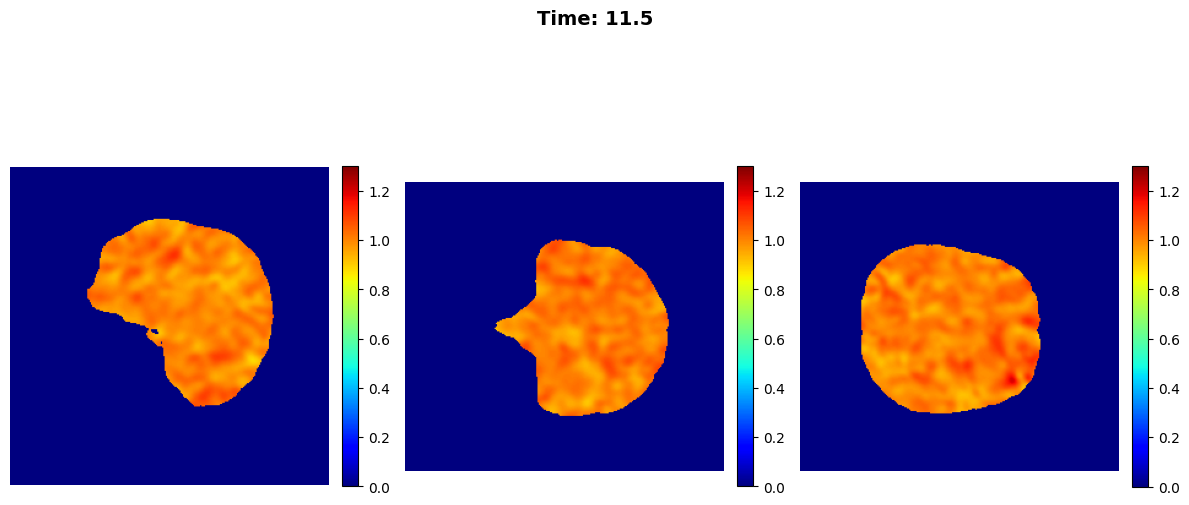

0.0 1.2346824407577515 0.0994877815246582


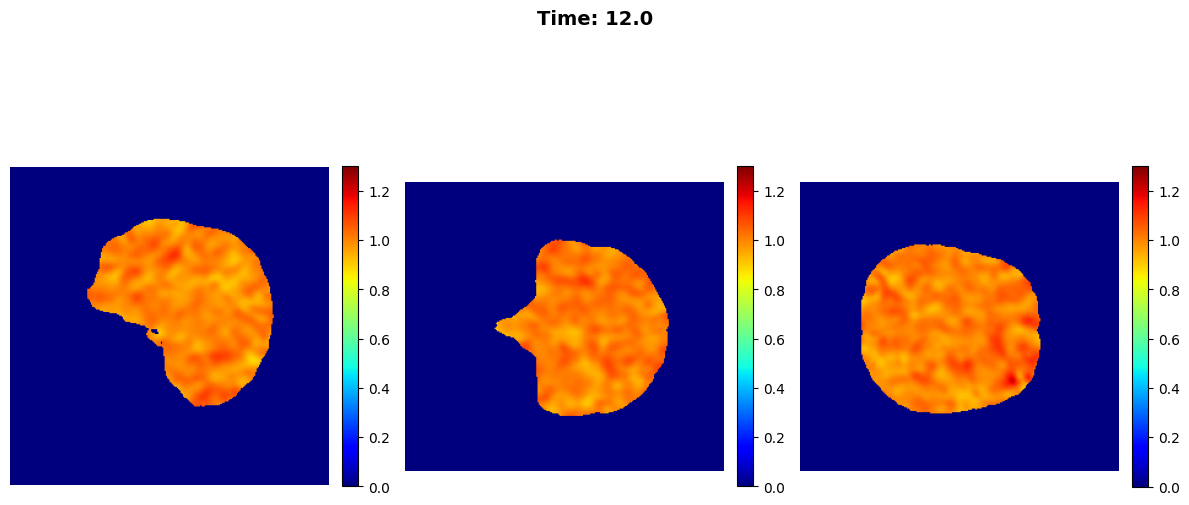

0.0 1.2345664501190186 0.09948761016130447


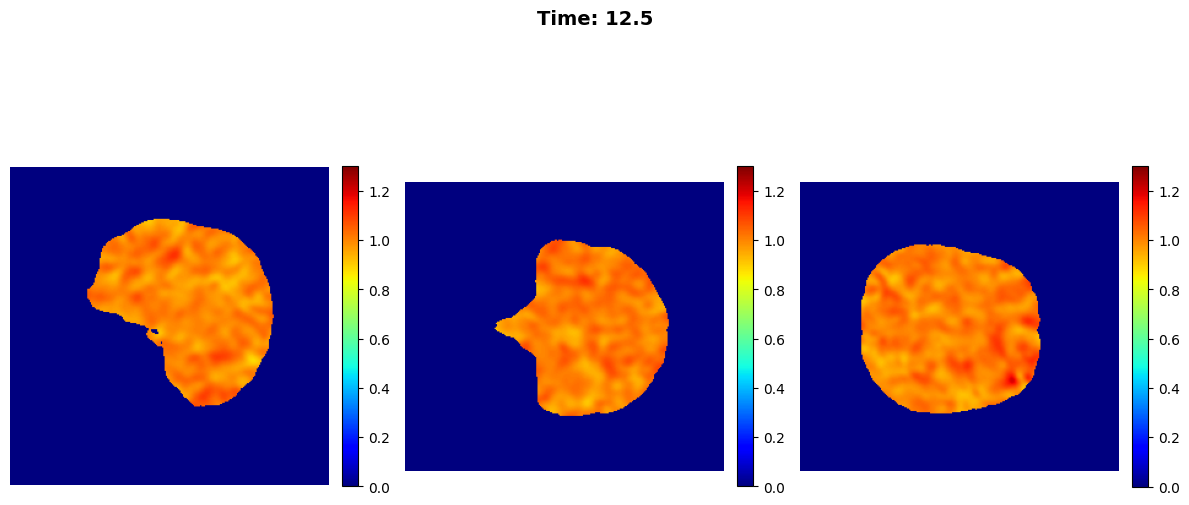

0.0 1.2351690530776978 0.0994865894317627


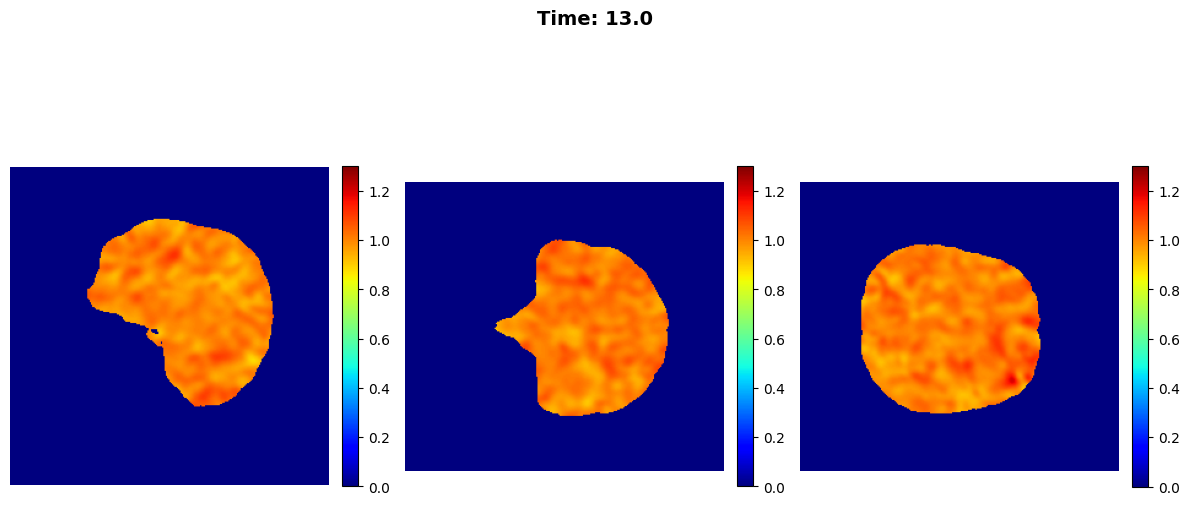

In [11]:
def preview_image(jacobian_det, mask, time, normalize_by="volume", cmap="jet", figsize=(12, 6), threshold=None):
    """
    Display three orthogonal slices of the given 3D image and the corresponding I0 slices.

    jacobian_det is assumed to be of shape (H,W,D)

    If a number is provided for threshold, then pixels for which the value
    is below the threshold will be shown in red
    """
    print(jacobian_det.min().item(), jacobian_det.max().item(), jacobian_det.mean().item())
    if normalize_by == "slice":
        vmin = 0.0
        vmax = 1.3
    elif normalize_by == "volume":
        vmin = jacobian_det.min().item()
        vmax = jacobian_det.max().item()
    else:
        raise ValueError(f"Invalid value '{normalize_by}' given for normalize_by")

    #define region for visualization based on mask
    rows, cols, dep = np.where(mask > 0)
    x1, x2 = min(rows), max(rows)
    y1, y2 = min(cols), max(cols)
    z1, z2 = min(dep), max(dep)

    x, y, z = 110, 120, 160
    jac_det_slices = (jacobian_det[x, :, :], jacobian_det[:, y, :], jacobian_det[:, :, z])

    fig, axs = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(f"Time: {time}", fontsize=14, weight='bold', y=0.95)

    for idx, img in enumerate(jac_det_slices):
        ax = axs[idx]
        ax.axis("off")
        gg = ax.imshow(img, origin="upper", cmap=cmap or "RdBu", vmin=vmin, vmax=vmax)

        if threshold is not None:
            red_overlay = np.zeros(img.shape + (4,))
            red_overlay[img <= threshold] = [1, 0, 0, 1]  #red for below threshold
            ax.imshow(red_overlay, origin="upper")

        # Add colorbar to each subplot
        fig.colorbar(gg, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout(rect=[0, 0, 1, 0.9])  #adjust layout to fit suptitle and subplots

    wandb.log({"Jacobian Maps": wandb.Image(fig)})
    plt.show()
    return fig


video_jacobian_maps = []
for idx, selected_time in enumerate(time):
    det = stack_total_jac_det[idx] * I0_mask
    fig = preview_image(det, I0_mask, selected_time, normalize_by="slice", threshold=-1)
    video_jacobian_maps.append(fig)
plt.close(fig)


### SEGMENTATION MAPS

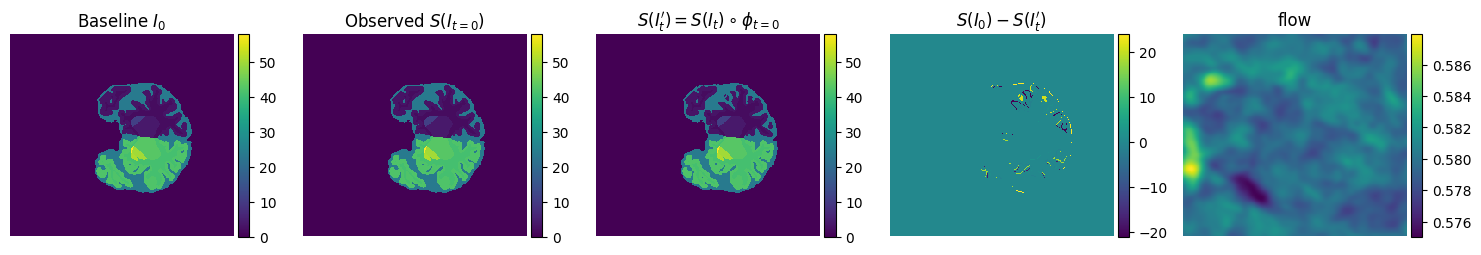

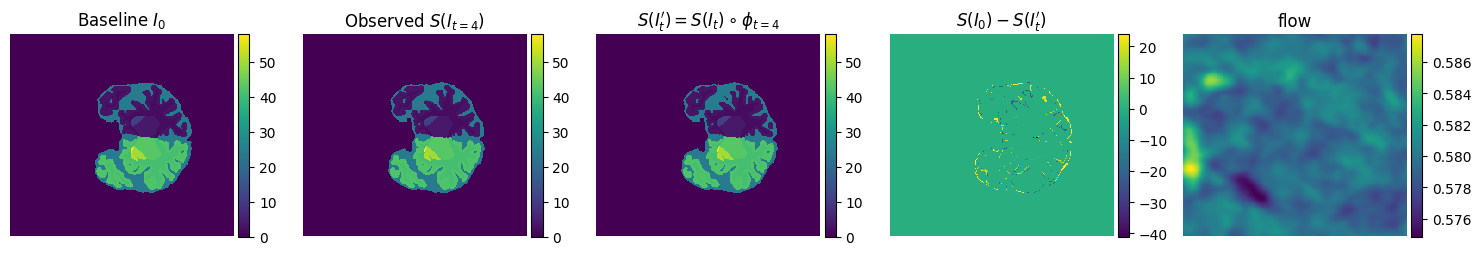

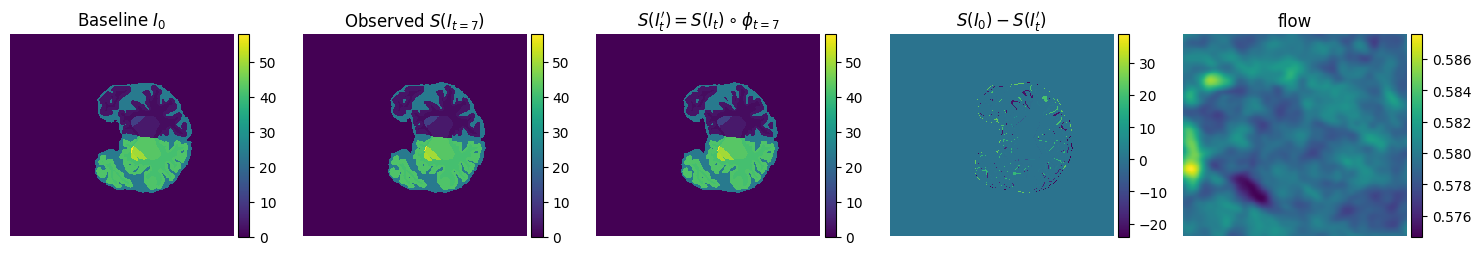

In [12]:
#warp the labbeled I0 with deformation field to compute dice between moved_I0 and It_seg


stack_moved_seg = []
video_images_seg = []
video_titles_seg = []
z = 150
data = sorted(glob.glob(datapath + "../labels/I*"))
labels = [load_data(img, False) for img in data]
I0_seg = labels[0]
It_seg = labels

image_mask_2d_seg = I0_mask[:, z, :]
I0_2d_seg = I0_seg[:, z, :].cpu().numpy()

for idx, selected_time in enumerate(observed_time_points):
    img_seg = It_seg[idx]

    moved_seg = transform.nearest_neighbor_interpolation(stack_total_deformation_field[idx].to(device), img_seg).view(
        img_seg.shape)
    stack_moved_seg.append(moved_seg.cpu().numpy().squeeze())

    It_2d_seg = img_seg[:, z, :].cpu().numpy()
    moved_2d_label = moved_seg[:, z, :].cpu().numpy()

    residual = I0_2d_seg - moved_2d_label

    tdf_2d = stack_tdf[idx][:, z, :].cpu().numpy()
    masked_tdf = image_masking(tdf_2d, image_mask_2d, True)

    images = [I0_2d_seg, It_2d_seg, moved_2d_label, residual, masked_tdf[..., 1]]
    titles = [
        r'Baseline $I_0$',
        r'Observed $S(I_{t=' + str(selected_time) + '})$',
        r"$S(I_{t}') = S(I_t)  \circ \phi_{t=" + str(selected_time) + "}$",
        r"$S(I_0) - S(I_{t}')$",
        'flow'
    ]
    video_images_seg.append(images)
    video_titles_seg.append(titles)

    ne.plot.slices(images, titles=titles, do_colorbars=True, cmaps=['viridis']);

    wandb.log(
        {"Transformed segmentation maps": [wandb.Image(image, caption=title) for image, title in zip(images, titles)]})


In [13]:
structures = [
    "Lateral Ventricle",
    "Thalamus",
    "Caudate",
    "Putamen",
    "Pallidum",
    "Hippocampus",
    "Amygdala"
]


left_structures = [4, 10, 11, 12, 13, 17, 18]
right_structures = [43, 49, 50, 51, 52, 53, 54]
csv_file = result_path +"/dice_metrics.csv"

def dice_score(label1, label2):
    intersection = np.sum(label1[label1 > 0] == label2[label1 > 0])
    dice = (2 * intersection) / (np.sum(label1) + np.sum(label2))
    return dice


def combine_labels(img1, img2, state="Dice Score"):
    total_dice = 0
    structure_dice = {}

    for i, structure in enumerate(structures):
        img1_combined = np.where(np.isin(img1, [left_structures[i], right_structures[i]]), 1, 0)
        img2_combined = np.where(np.isin(img2, [left_structures[i], right_structures[i]]), 1, 0)
        dice = dice_score(img1_combined, img2_combined)
        structure_dice[structure] = dice
        # print(f"{structure}: {dice:.4f}")
        total_dice += dice
    print(f" {state} : {total_dice / len(structures)}")
    return structure_dice, total_dice / len(structures)


def combine_labels(img1, img2, selected_time, state="Dice Score"):
    total_dice = 0
    structure_dice = {}

    for i, structure in enumerate(structures):
        img1_combined = np.where(np.isin(img1, [left_structures[i], right_structures[i]]), 1, 0)
        img2_combined = np.where(np.isin(img2, [left_structures[i], right_structures[i]]), 1, 0)
        dice = dice_score(img1_combined, img2_combined)
        structure_dice[structure] = dice
        # print(f"{structure}: {dice:.4f}")
        total_dice += dice
    print(f"Time = {selected_time}, {state} : {total_dice / len(structures)}")
    return structure_dice, total_dice / len(structures)


def compute_mean_jac_det(moved_label, det, selected_time):
    mean_jacobian_determinants = {}
    for i, structure in enumerate(structures):
        mask = np.where(np.isin(moved_label, [left_structures[i], right_structures[i]]), 1, 0)

        jacobian_values = det[mask > 0]
        mean_jacobian_determinants[structure] = jacobian_values.mean().item()
    return mean_jacobian_determinants


for idx, selected_time in enumerate(observed_time_points):
    file_pattern = f"{datapath}../labels/I{idx}_*.nii"
    matching_files = glob.glob(file_pattern)
    file_path = matching_files[0] 
    It_seg = load_data(file_path, False)
    It_seg = It_seg.cpu().numpy()

    structure_dice_affine, total_dice_affine = combine_labels(I0_seg.cpu().numpy(), It_seg, selected_time,
                                                              "Dice between I0 and It (affine)")
    structure_dice_target_predicted, total_dice_target_predicted = combine_labels(I0_seg.cpu().numpy(),
                                                                                  stack_moved_seg[idx], selected_time,
                                                                                  "Dice at I0 and It\'(target vs predicted)")

    det = stack_total_jac_det[idx]
    mean_jac_det = compute_mean_jac_det(stack_moved_seg[idx], det, selected_time)
    number_of_folds = (det <= 0).sum().item()
    number_of_expansions = (det > 1).sum().item()
    number_of_contractions = ((det > 0) & (det < 1)).sum().item()
    no_volume_change = (det == 1).sum().item()

    if not os.path.exists(csv_file):
        with open(csv_file, 'w') as f:
            writer = csv.writer(f)
            writer.writerow(
                ["subjectID", "time", "structure", "structure_mean_jac_det", "jac_det_mean", "jac_det_min",
                 "jac_det_max", "structure_dice_affine", "structure_dice_target_predicted",
                 "total_dice_affine", "total_dice_target_predicted", "number_of_folds", "number_of_expansions",
                 "number_of_contractions", "no_volume_change", "group"])

    try:

        with open(csv_file, 'a') as f:

            for i, structure in enumerate(structures):
                writer = csv.writer(f)
                rows = [datapath.split("/")[7], selected_time, structure, mean_jac_det[structure], det.mean().item(),
                        det.min().item(), det.max().item(), structure_dice_affine[structure],
                        structure_dice_target_predicted[structure],
                        total_dice_affine, total_dice_target_predicted, number_of_folds, number_of_expansions,
                        number_of_contractions, no_volume_change, datapath.split("/")[6]]
                writer.writerow(rows)



    except FileNotFoundError:
        print(f"Error: Could not write to file {csv_file}")
    wandb.log({"Results": wandb.Table(data=pd.read_csv(csv_file))})

Time = 0, Dice between I0 and It (affine) : 1.0
Time = 0, Dice at I0 and It'(target vs predicted) : 0.9937608543768864
Time = 4, Dice between I0 and It (affine) : 0.9624313589707955
Time = 4, Dice at I0 and It'(target vs predicted) : 0.9596658403394914
Time = 7, Dice between I0 and It (affine) : 0.9590301782766242
Time = 7, Dice at I0 and It'(target vs predicted) : 0.9572596769944958


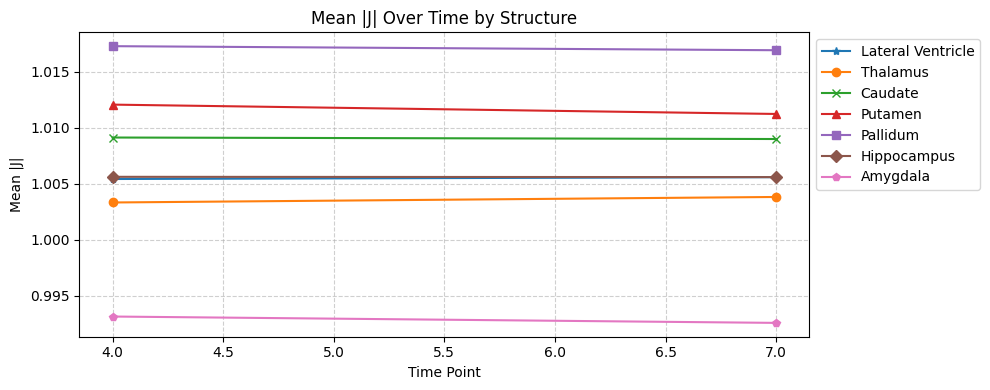

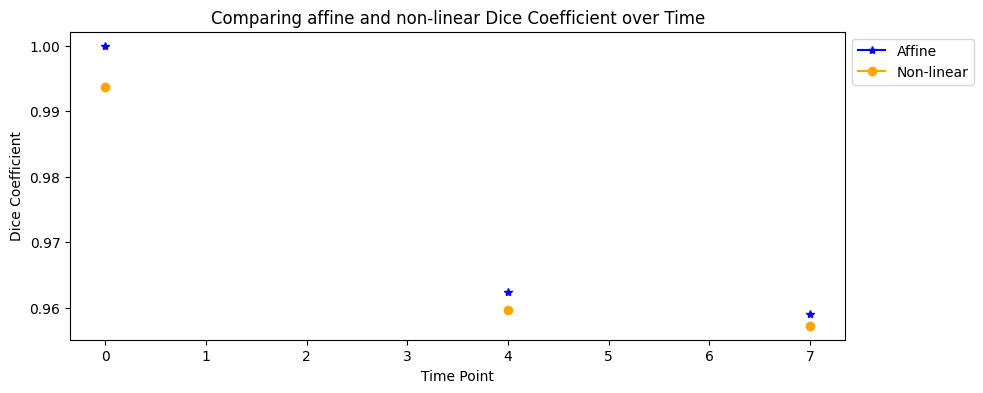

In [14]:
df = pd.read_csv(csv_file)
df_filtered = df[df['time'] != 0]
fig, ax = plt.subplots(figsize=(10, 4))

markers = ['*', 'o', 'x', '^', 's', 'D', 'p', '+']

for i, structure in enumerate(df_filtered['structure'].unique()):
    structure_data = df_filtered[df_filtered['structure'] == structure]
    ax.plot(structure_data["time"], structure_data['structure_mean_jac_det'],
            label=structure, marker=markers[i % len(markers)], linestyle='-')

ax.set_xlabel('Time Point')
ax.set_ylabel('Mean |J|')
ax.set_title('Mean |J| Over Time by Structure')

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

wandb.log({"Mean Jacobian Determinant Over time": wandb.Image(fig)})

fig, ax = plt.subplots(figsize=(10, 4))

affine_label_added = False
nonlinear_label_added = False

for time_point in df['time'].unique():
    time_point_data = df[df['time'] == time_point]
    # plot affine line
    ax.plot(time_point, time_point_data['total_dice_affine'].mean(),
            marker='*', linestyle='-', color='blue', label="Affine" if not affine_label_added else "")
    affine_label_added = True
    ax.plot(time_point, time_point_data['total_dice_target_predicted'].mean(),
            marker='o', linestyle='-', color='orange', label="Non-linear" if not nonlinear_label_added else "")
    nonlinear_label_added = True

ax.set_xlabel('Time Point')
ax.set_ylabel('Dice Coefficient')
ax.set_title('Comparing affine and non-linear Dice Coefficient over Time')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(result_path +"/dice_plot.png", dpi=300, bbox_inches='tight')
plt.show()
#log the figure to Weights and Biases
wandb.log({"Comparing affine and non-linear Dice Coefficient over Time": wandb.Image(fig)})

### JACOBIAN DETEMINANT OVER TIME

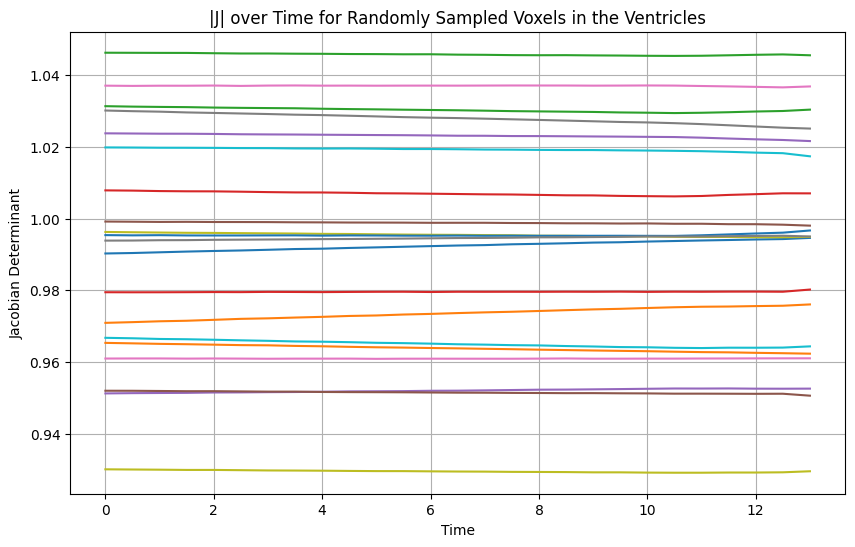

<Figure size 640x480 with 0 Axes>

In [15]:
I0_seg_np = I0_seg.cpu().numpy()

#voxel indices for the left and right ventricles
ventricle_indices = np.argwhere((I0_seg_np == 4) | (I0_seg_np == 43))

num_voxels = 20
sampled_indices = ventricle_indices[np.random.choice(len(ventricle_indices), num_voxels, replace=False)]

voxel_jacobian_values = {}

#get |J| for each time point
for t_idx, jac_det_map in enumerate(stack_total_jac_det):
    jac_det_np = jac_det_map.numpy()
    for i, (x, y, z) in enumerate(sampled_indices):
        if i not in voxel_jacobian_values:
            voxel_jacobian_values[i] = []
        voxel_jacobian_values[i].append(abs(jac_det_np[x, y, z]))

plt.figure(figsize=(10, 6))
for i, values in voxel_jacobian_values.items():
    plt.plot(time.cpu().detach().numpy(), values, label=f'Voxel {i}')

plt.xlabel('Time')
plt.ylabel('Jacobian Determinant')
plt.title('|J| over Time for Randomly Sampled Voxels in the Ventricles')
plt.grid(True)

plt.savefig(result_path+"/jac_det_over_time_ventricles.png", dpi=300, bbox_inches='tight')
plt.show()
wandb.log({"|J| over Time for Randomly Sampled Voxels in the Ventricles": wandb.Image(plt)})

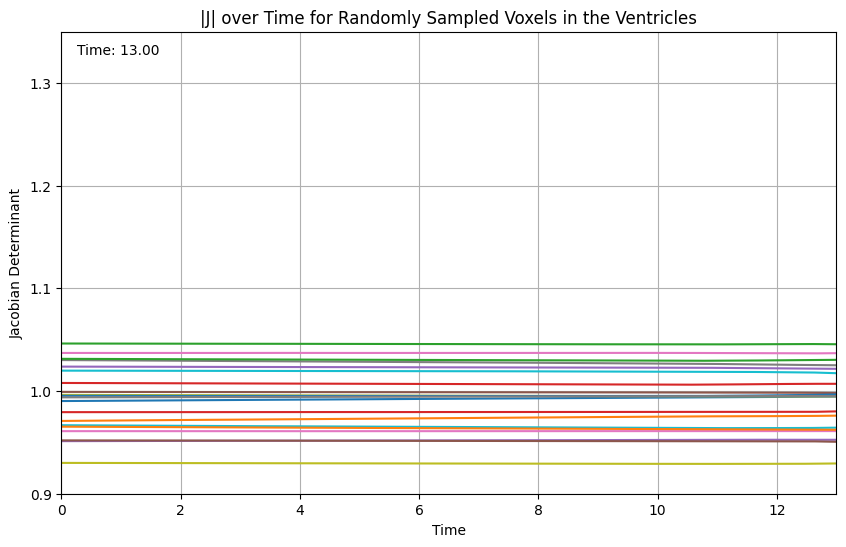

In [16]:
time_np = time.cpu().detach().numpy()

num_frames = len(time_np) * 30  # 30 fps
interpolated_time = np.linspace(time_np[0], time_np[-1], num_frames)
interpolated_voxel_values = {
    i: np.interp(interpolated_time, time_np, values)
    for i, values in voxel_jacobian_values.items()
}

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(time_np[0], time_np[-1])
# ax.set_ylim(0, max(max(values) for values in interpolated_voxel_values.values()) * 1.1)
ax.set_ylim(0.9, 1.35)
ax.set_xlabel('Time')
ax.set_ylabel('Jacobian Determinant')
ax.set_title('|J| over Time for Randomly Sampled Voxels in the Ventricles')
lines = {i: ax.plot([], [], label=f'Voxel {i}')[0] for i in voxel_jacobian_values.keys()}
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

ax.grid(True)


def update(frame):
    current_time = interpolated_time[frame]
    time_text.set_text(f'Time: {current_time:.2f}')
    for i, line in lines.items():
        line.set_data(interpolated_time[:frame + 1], interpolated_voxel_values[i][:frame + 1])
    return (*lines.values(), time_text)


ani = FuncAnimation(fig, update, frames=num_frames, blit=True, interval=1000 / 30)

ani.save(result_path +'/voxel_jacobian_animation.mp4', writer='ffmpeg', codec='mpeg4', fps=30, dpi=300)
wandb.log({"Voxel |J| Animation": wandb.Video(result_path+'/voxel_jacobian_animation.mp4')})
plt.show()

### Rate of Change of Jacobian Determinant for Brain Structures Over Time (d|J|/dt)

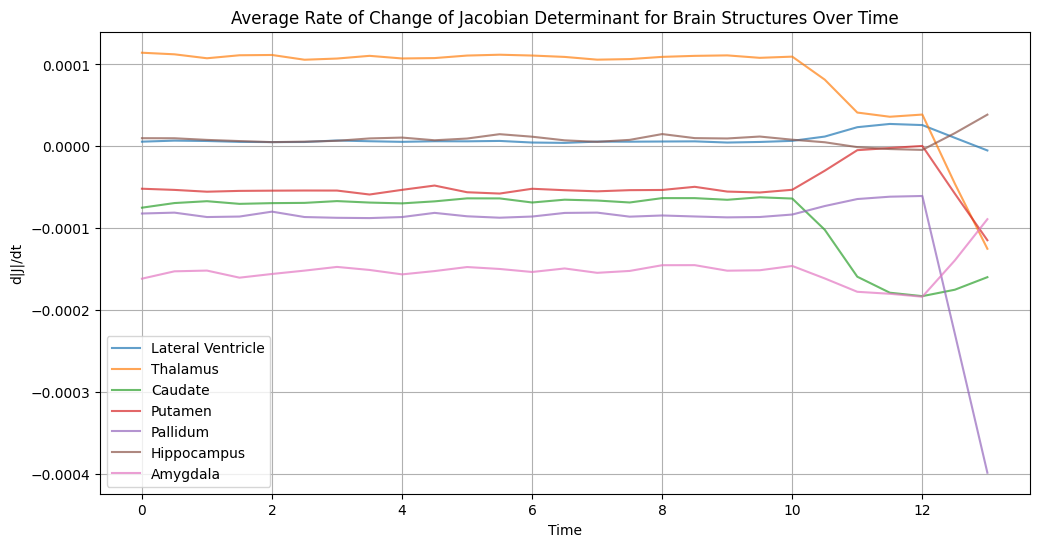

In [17]:
##Rate of Change of Jacobian Determinant for Brain Structures Over Time (d|J|/dt)
#numerical approx
jac_det_derivative = torch.stack(stack_total_jac_det, axis=0)
region_mask = I0_seg.cpu().numpy()
jac_det_derivative = torch.gradient(jac_det_derivative, spacing=(time.cpu().detach(),), dim=0)[0].cpu().numpy()

# analytic derived
# jac_det_derivative = torch.stack(stack_total_rate_of_change, axis=0).numpy()
paired_structures = {
    "Lateral Ventricle": (4, 43),
    "Thalamus": (10, 49),
    "Caudate": (11, 50),
    "Putamen": (12, 51),
    "Pallidum": (13, 52),
    "Hippocampus": (17, 53),
    "Amygdala": (18, 54)
}

structure_derivatives = {structure: [] for structure in paired_structures.keys()}

for t in range(jac_det_derivative.shape[0]):
    for structure, (left_id, right_id) in paired_structures.items():
        left_mask = region_mask == left_id
        right_mask = region_mask == right_id

        left_values = jac_det_derivative[t][left_mask]
        right_values = jac_det_derivative[t][right_mask]

        combined_mean = np.mean(np.concatenate([left_values, right_values]))
        structure_derivatives[structure].append(combined_mean)

plt.figure(figsize=(12, 6))
for structure, avg_derivative in structure_derivatives.items():
    plt.plot(time.cpu().detach().numpy(), avg_derivative, label=structure, alpha=0.7)

plt.xlabel('Time')
plt.ylabel(r'd|J|/dt')
plt.title('Average Rate of Change of Jacobian Determinant for Brain Structures Over Time')
plt.legend()
plt.grid()
wandb.log({"Average_Rate_of_Change": wandb.Image(plt)})
plt.savefig(result_path +"/average_rate_of_change.png", dpi=300, bbox_inches='tight')
plt.show()

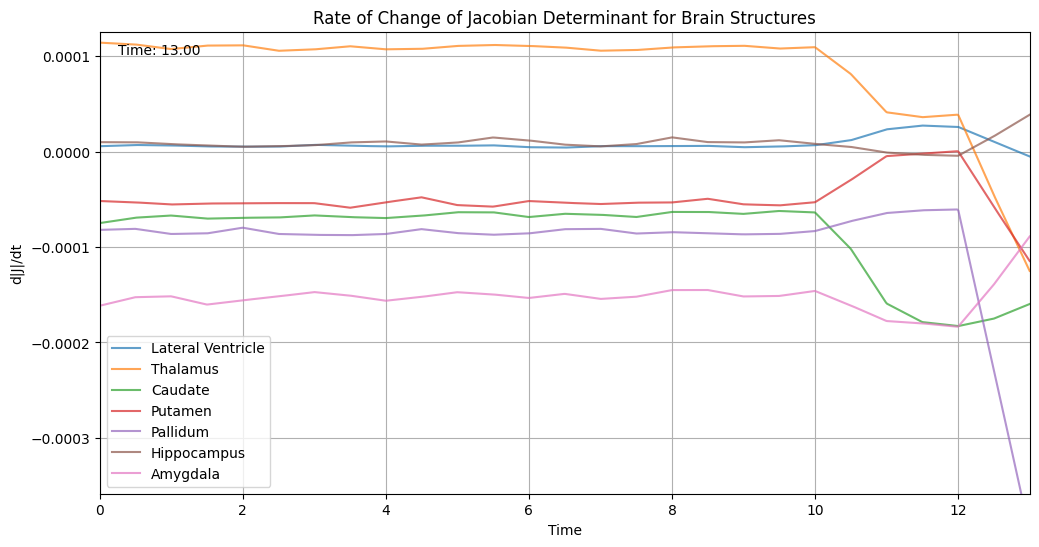

In [18]:
#interpolate structure derivatives for smooth animation
# time_np = time.cpu().numpy()
num_frames = len(time_np) * 30  #30 frames per second
interpolated_time = np.linspace(time_np[0], time_np[-1], num_frames)

# Interpolating derivative values over time
interpolated_structure_derivatives = {
    structure: np.interp(interpolated_time, time_np, derivatives)
    for structure, derivatives in structure_derivatives.items()
}

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlim(time_np[0], time_np[-1])
ax.set_ylim(
    min(min(values) for values in interpolated_structure_derivatives.values()) * 0.9,
    max(max(values) for values in interpolated_structure_derivatives.values()) * 1.1
)
ax.set_xlabel('Time')
ax.set_ylabel(r'd|J|/dt')
ax.set_title('Rate of Change of Jacobian Determinant for Brain Structures')
lines = {structure: ax.plot([], [], label=structure, alpha=0.7)[0] for structure in paired_structures.keys()}
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

ax.legend()
ax.grid(True)


def update(frame):
    current_time = interpolated_time[frame]
    time_text.set_text(f'Time: {current_time:.2f}')
    for structure, line in lines.items():
        line.set_data(interpolated_time[:frame + 1], interpolated_structure_derivatives[structure][:frame + 1])
    return (*lines.values(), time_text)


ani = FuncAnimation(fig, update, frames=num_frames, blit=True, interval=1000 / 30)

ani.save(result_path+'/rate_of_change_jacobian.mp4', writer='ffmpeg', codec='mpeg4', fps=30, dpi=300)

wandb.log({"Rate_of_Change_Animation": wandb.Video(result_path+'/rate_of_change_jacobian.mp4')})
plt.show()

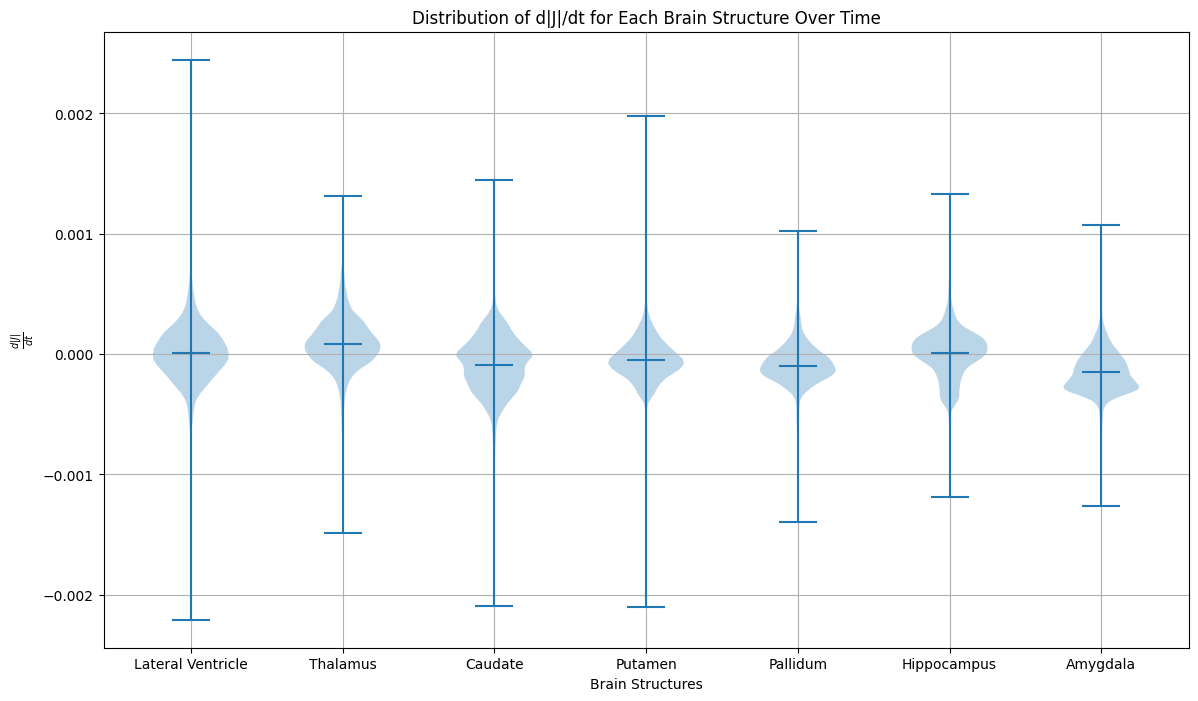

In [19]:
paired_structures = {
    "Lateral Ventricle": (4, 43),
    "Thalamus": (10, 49),
    "Caudate": (11, 50),
    "Putamen": (12, 51),
    "Pallidum": (13, 52),
    "Hippocampus": (17, 53),
    "Amygdala": (18, 54)
}

structure_derivatives = {structure: [] for structure in paired_structures.keys()}

for t in range(jac_det_derivative.shape[0]):
    for structure, (left_id, right_id) in paired_structures.items():
        left_mask = region_mask == left_id
        right_mask = region_mask == right_id

        left_values = jac_det_derivative[t][left_mask]
        right_values = jac_det_derivative[t][right_mask]

        # left_values_np = left_values.cpu().numpy() 
        # right_values_np = right_values.cpu().numpy()
        left_values_np = left_values
        right_values_np = right_values

        structure_derivatives[structure].append(np.concatenate([left_values_np, right_values_np]))

violin_data = []

#flatten each structure's list of voxelwise derivatives across time
for structure in paired_structures.keys():
    flattened_values = np.concatenate(structure_derivatives[structure])
    violin_data.append(flattened_values)

fig, ax = plt.subplots(figsize=(14, 8))
ax.violinplot(violin_data, showmeans=True)

ax.set_xticks(np.arange(1, len(paired_structures) + 1))
ax.set_xticklabels(paired_structures.keys())

ax.set_xlabel('Brain Structures')
ax.set_ylabel(r'$\frac{d|J|}{dt}$')
ax.set_title('Distribution of d|J|/dt for Each Brain Structure Over Time')

ax.grid(True)
plt.savefig(result_path +"/distribution_of_rate_of_change.png", dpi=300, bbox_inches='tight')
plt.show()


### Proportion of sign consistency

Lateral Ventricle: [0.4208753230912206, 0.36985321392613]
Thalamus: [0.287317620650954, 0.3518109165107975]
Caudate: [0.5680904522613065, 0.3010190749934675]
Putamen: [0.2676326443639463, 0.196139180171592]
Pallidum: [0.5545905707196029, 0.24724919093851133]
Hippocampus: [0.35209662716499546, 0.32534738859607093]
Amygdala: [0.6333949476278496, 0.38754907459338195]


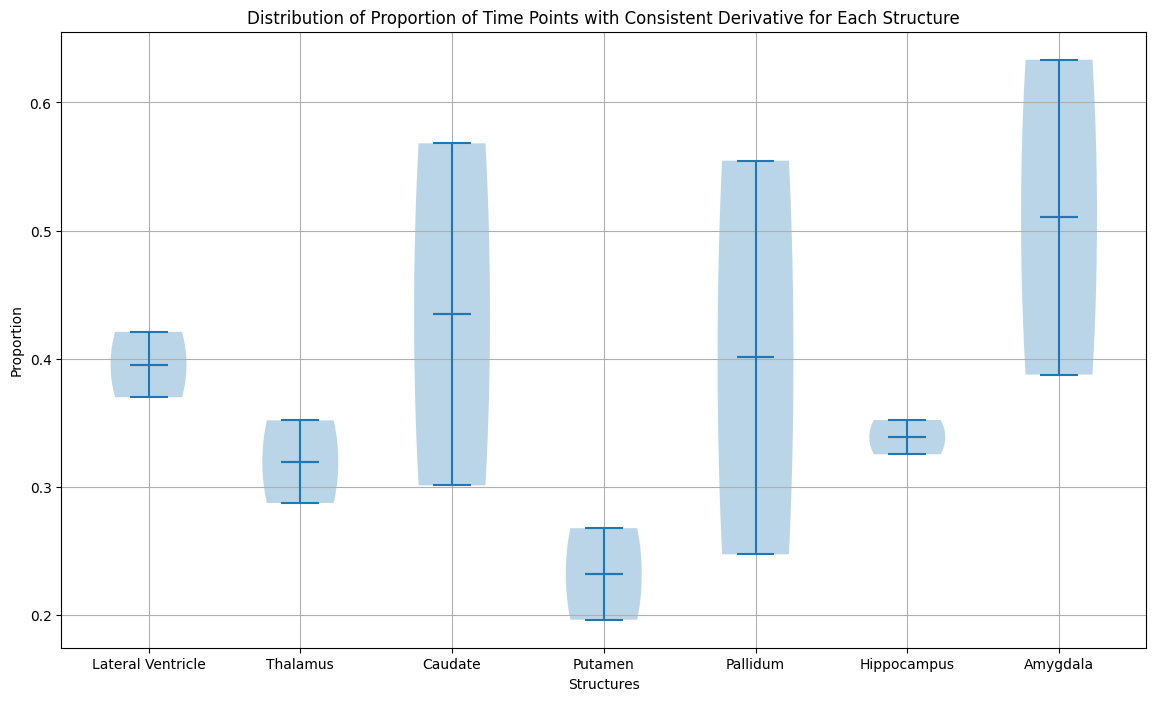

In [20]:
#### proportion of sign consistency, this is just a clearer plot that aggregates the mean for each left/right region of a structure
jac_det_derivative = torch.stack(stack_total_jac_det, axis=0)
region_mask = I0_seg.cpu().numpy()
jac_det_derivative = torch.gradient(jac_det_derivative, spacing=(time.cpu().detach(),), dim=0)[0]


# jac_det_derivative = torch.stack(stack_total_rate_of_change, axis=0) #using analytic derivative
structure_consistency = {structure: [] for structure in paired_structures.keys()}

for structure, (left_id, right_id) in paired_structures.items():
    left_mask = region_mask == left_id
    right_mask = region_mask == right_id

    left_voxel_signs = np.sign(jac_det_derivative[:, left_mask].cpu().numpy())
    right_voxel_signs = np.sign(jac_det_derivative[:, right_mask].cpu().numpy())

    if left_voxel_signs.shape[1] > 0:
        left_consistency = np.mean(np.all(left_voxel_signs == left_voxel_signs[0, :], axis=0)) #stricter and higher penalty
        # left_consistency = np.mean(left_voxel_signs == left_voxel_signs[0, :]) #less strict

        structure_consistency[structure].append(left_consistency)
    if right_voxel_signs.shape[1] > 0:
        right_consistency = np.mean(np.all(right_voxel_signs == right_voxel_signs[0, :], axis=0))
        structure_consistency[structure].append(right_consistency)

violin_data = []
for structure in paired_structures.keys():
    structure_data = structure_consistency[structure]
    print(f"{structure}: {structure_data}")
    violin_data.append(structure_data)

fig, ax = plt.subplots(figsize=(14, 8))

violins = ax.violinplot(violin_data, showmeans=True, showmedians=True)

ax.set_xticks(np.arange(1, len(paired_structures) + 1))
ax.set_xticklabels(paired_structures.keys())
ax.set_xlabel('Structures')
ax.set_ylabel('Proportion')
ax.set_title('Distribution of Proportion of Time Points with Consistent Derivative for Each Structure')
ax.grid(True)
wandb.log({"proportion": wandb.Image(plt)})
plt.savefig(result_path +"/proportion.png", dpi=300, bbox_inches='tight')
plt.show()

Lateral Ventricle: len, 72175 0.8481668783435324
Thalamus: len, 12118 0.8296748638389173
Caudate: len, 7807 0.8581519908534126
Putamen: len, 8889 0.8137689945542348
Pallidum: len, 3157 0.8592428348525909
Hippocampus: len, 8562 0.8166489311081696
Amygdala: len, 3406 0.9007851068919771


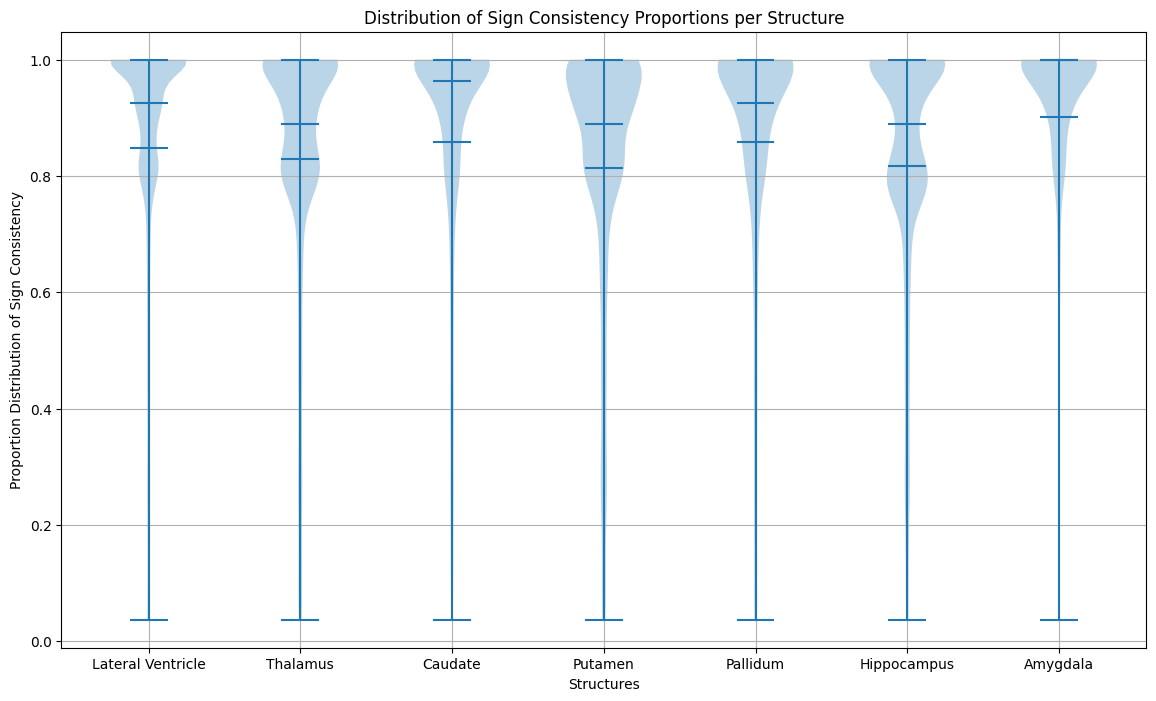

In [21]:
#violin plot
jac_det_derivative = torch.stack(stack_total_jac_det, axis=0)
jac_det_derivative = torch.gradient(jac_det_derivative, spacing=(time.cpu().detach(),), dim=0)[0]
region_mask = I0_seg.cpu().numpy() 
structure_sign_consistency = {structure: [] for structure in paired_structures.keys()}

for structure, (left_id, right_id) in paired_structures.items():
    structure_mask = (region_mask == left_id) | (region_mask == right_id)

    if np.any(structure_mask):
        structure_voxels = jac_det_derivative[:, structure_mask].cpu().numpy()
        voxel_signs = np.sign(structure_voxels) #get sign of each voxel
        #for each voxel, compute the proportion of time points with consistent sign
        # voxel_consistency = np.mean(voxel_signs[1:, :] == voxel_signs[:-1, :], axis=0)  #if doing local comparison, we compare the sign with previous time point sign
        voxel_consistency = np.mean(voxel_signs == voxel_signs[0, :], axis=0)  #compute proportion, compare with first time point sign, this is more global
        print(f"{structure}: len, {len(voxel_consistency)} {voxel_consistency.mean()}")
        structure_sign_consistency[structure].extend(voxel_consistency) 


violin_data = []
for structure in paired_structures.keys():
    structure_data = structure_sign_consistency[structure]
    # print(f"{structure}: {len(structure_data)} voxels processed, {structure_data}")
    violin_data.append(structure_data)

fig, ax = plt.subplots(figsize=(14, 8))
violins = ax.violinplot(violin_data, showmeans=True, showmedians=True)

ax.set_xticks(np.arange(1, len(paired_structures) + 1))
ax.set_xticklabels(paired_structures.keys())

ax.set_xlabel('Structures')
ax.set_ylabel('Proportion Distribution of Sign Consistency')
ax.set_title('Distribution of Sign Consistency Proportions per Structure')
ax.grid(True)

wandb.log({"sign_consistency_proportion": wandb.Image(plt)})

plt.savefig(result_path + "/sign_consistency_proportion.png", dpi=300, bbox_inches='tight')
plt.show()


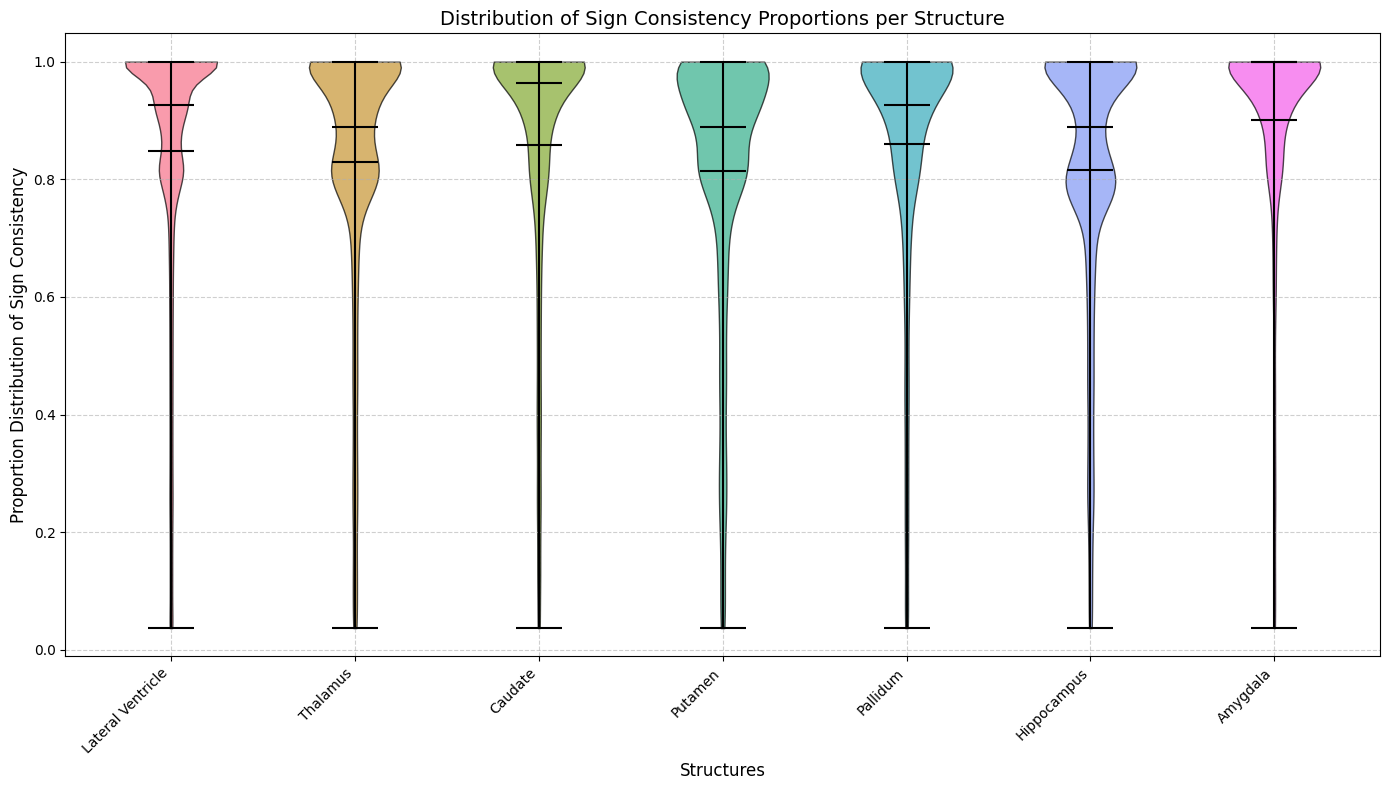

In [22]:
fig, ax = plt.subplots(figsize=(14, 8))
colors = sns.color_palette("husl", len(paired_structures))
violins = ax.violinplot(violin_data, showmeans=True, showmedians=True)

for i, body in enumerate(violins['bodies']):
    body.set_facecolor(colors[i])
    body.set_edgecolor('black')
    body.set_alpha(0.7)

for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians', 'cmeans'):
    vp = violins[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1.5)

ax.set_xticks(np.arange(1, len(paired_structures) + 1))
ax.set_xticklabels(paired_structures.keys(), rotation=45, ha='right', fontsize=10)
ax.set_xlabel('Structures', fontsize=12)
ax.set_ylabel('Proportion Distribution of Sign Consistency', fontsize=12)
ax.set_title('Distribution of Sign Consistency Proportions per Structure', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)

wandb.log({"sign_consistency_proportion_seaborn": wandb.Image(plt)})
plt.savefig(result_path + "/sign_consistency_proportion_seaborn.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


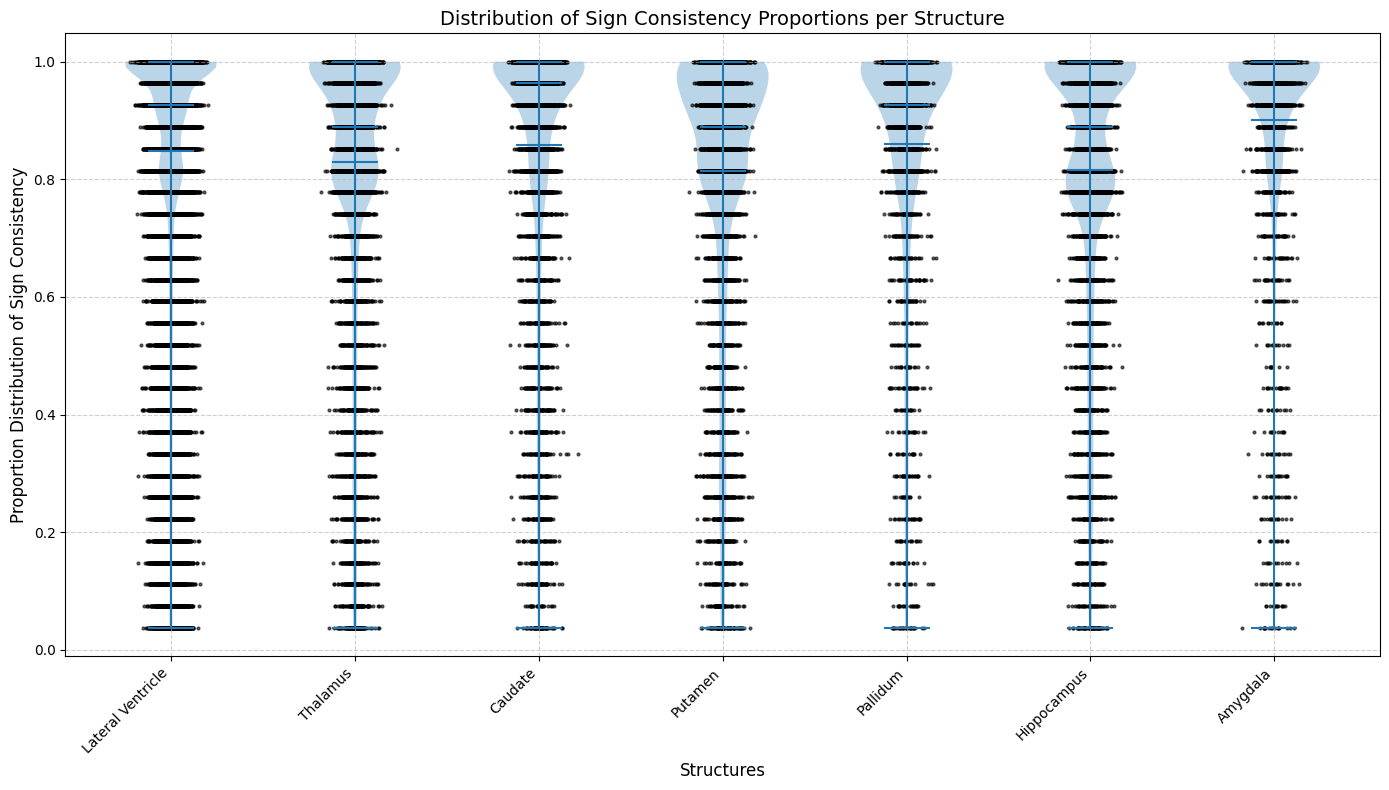

<Figure size 640x480 with 0 Axes>

In [23]:
structures = list(paired_structures.keys())
violin_data = [structure_sign_consistency[structure] for structure in structures]

fig, ax = plt.subplots(figsize=(14, 8))
violins = ax.violinplot(violin_data, vert=True, showmeans=True, showmedians=True)

for i, data in enumerate(violin_data):
    jitter = np.random.normal(0, 0.05, size=len(data))
    ax.scatter([i + 1 + j for j in jitter], data, color="black", alpha=0.6, s=4)

ax.set_xticks(range(1, len(structures) + 1))
ax.set_xticklabels(structures, rotation=45, ha='right', fontsize=10)
ax.set_xlabel('Structures', fontsize=12)
ax.set_ylabel('Proportion Distribution of Sign Consistency', fontsize=12)
ax.set_title('Distribution of Sign Consistency Proportions per Structure', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig(result_path + "/sign_consistency_with_points", dpi=300, bbox_inches='tight')
plt.show()
wandb.log({"sign_consistency_proportion_with_points": wandb.Image(plt)})


In [24]:
# #generating csv file for jac_det metrics and also monotononicity
csv_monotonicity_file = result_path + "/jacobian_metrics.csv"
subject_id = datapath.split("/")[7]
group = datapath.split("/")[6]

structure_sign_consistency = {structure: [] for structure in structures}
for time_idx in range(jac_det_derivative.shape[0]):  
    structure_averages = [] 


    for i, structure in enumerate(structures):
        structure_mask = (region_mask == left_structures[i]) | (region_mask == right_structures[i])
        # to compare sign with first time point's sign per structure
        avg_consistency = 0
        if np.any(structure_mask):  
            structure_voxel_signs = np.sign(jac_det_derivative[time_idx][structure_mask].cpu().numpy())
            #compute the proportion of voxels with the same sign as the first voxel's sign within a timepoint and strucyure
            avg_consistency = np.mean(structure_voxel_signs == structure_voxel_signs[0])

        # to compare sign with previous time point's sign per structure
        # if np.any(structure_mask):  
        #     current_voxel_signs = np.sign(jac_det_derivative[time_idx][structure_mask].cpu().numpy())
        #     if time_idx > 0:  #for first time point, we don't have a previous time point to compare with so leave as 0
        #         previous_voxel_signs = np.sign(jac_det_derivative[time_idx - 1][structure_mask].cpu().numpy())
        #         avg_consistency = np.mean(current_voxel_signs == previous_voxel_signs)

            # print(f"{structure}: len {len(current_voxel_signs)}, avg_consistency {avg_consistency}")

        structure_sign_consistency[structure].append(avg_consistency)


#for total proportion of sign consistency, for each structure this would be same across all time points
total_proportion_per_structure = {}
for i, (structure, (left_id, right_id)) in enumerate(paired_structures.items()):
    structure_mask = (region_mask == left_id) | (region_mask == right_id)
    if np.any(structure_mask):
        structure_voxels = jac_det_derivative[:, structure_mask].cpu().numpy()
        voxel_signs = np.sign(structure_voxels)
        voxel_consistency = np.mean(voxel_signs == voxel_signs[0, :], axis=0)
        total_proportion_per_structure[structure] = voxel_consistency.mean()



# computing jacobian metrics
def compute_jacobian_metrics(det, mask):
    jacobian_values = det[mask > 0]
    jac_det_mean = jacobian_values.mean().item()
    jac_det_min = jacobian_values.min().item()
    jac_det_max = jacobian_values.max().item()
    number_of_contractions = ((jacobian_values > 0) & (jacobian_values < 1)).sum().item()
    no_volume_change = (jacobian_values == 1).sum().item()
    folded_voxels = (jacobian_values < 0).sum().item()
    
    return jac_det_mean, jac_det_min, jac_det_max, number_of_contractions, no_volume_change, folded_voxels

def compute_derivative_metrics(jac_det_derivative, mask):
    derivative_values = jac_det_derivative[mask > 0]
    jac_det_derivative_mean = derivative_values.mean().item()
    jac_det_derivative_min = derivative_values.min().item()
    jac_det_derivative_max = derivative_values.max().item()
    
    return jac_det_derivative_mean, jac_det_derivative_min, jac_det_derivative_max

if not os.path.exists(csv_monotonicity_file):
    with open(csv_monotonicity_file, 'w') as f:
        writer = csv.writer(f)
        writer.writerow([
            "subjectID", "time_point", "structure", "structure_proportion_monotonicity",
            "total_proportion_monotonicity", "jac_det_mean",
            "jac_det_min", "jac_det_max", "number_of_contractions", "no_volume_change","folded_voxels",
            "jac_det_derivative_mean", "jac_det_derivative_min", "jac_det_derivative_max", "group"
        ])

with open(csv_monotonicity_file, 'a') as f:
    writer = csv.writer(f)

    for time_idx, tm in enumerate(time):
        for structure in structures:
            left_mask = region_mask == left_structures[structures.index(structure)]
            right_mask = region_mask == right_structures[structures.index(structure)]

            mask = left_mask | right_mask

            jac_det_mean, jac_det_min, jac_det_max, number_of_contractions, no_volume_change, folded_voxels = compute_jacobian_metrics(stack_total_jac_det[time_idx], mask)
            jac_det_derivative_mean, jac_det_derivative_min, jac_det_derivative_max = compute_derivative_metrics(jac_det_derivative[time_idx], mask)

            #saving prop consistency for the structure 
            avg_consistency = structure_sign_consistency[structure][time_idx]
            total_proportion = total_proportion_per_structure[structure] 

            writer.writerow([
                subject_id, tm.item(), structure, avg_consistency, total_proportion,
                jac_det_mean, jac_det_min, jac_det_max, number_of_contractions, no_volume_change, folded_voxels,
                jac_det_derivative_mean, jac_det_derivative_min, jac_det_derivative_max, group
            ])


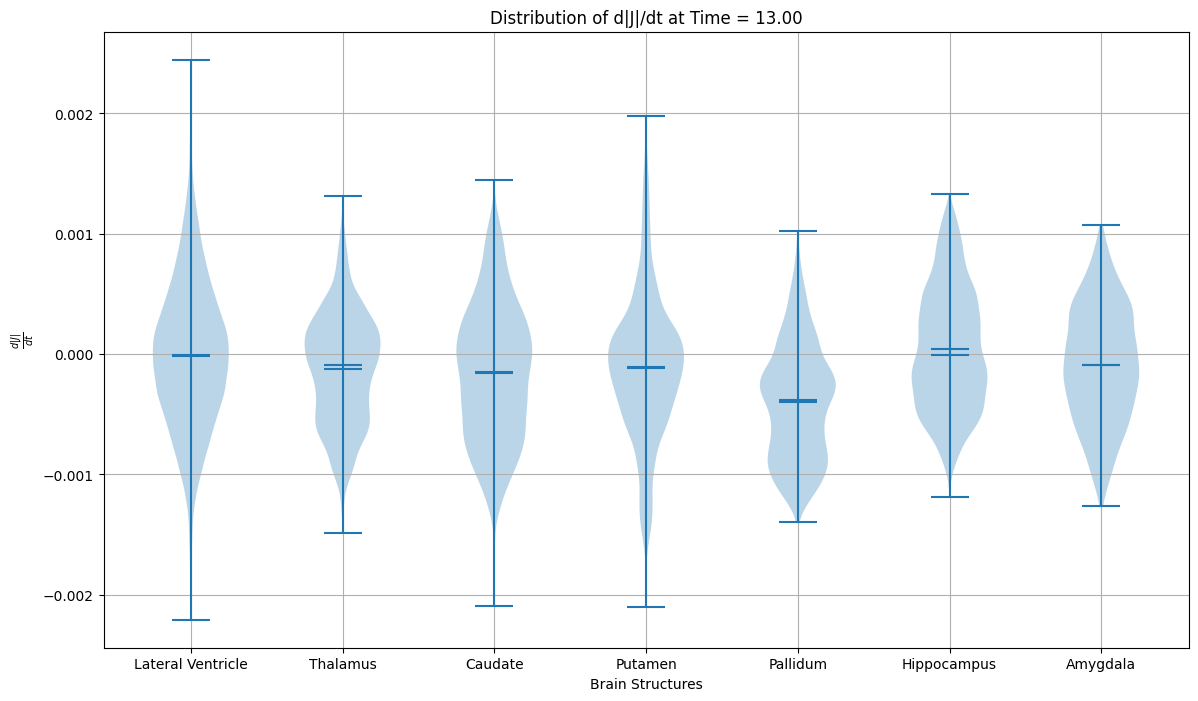

In [25]:
for t in range(jac_det_derivative.shape[0]):
    for structure, (left_id, right_id) in paired_structures.items():
        left_mask = region_mask == left_id
        right_mask = region_mask == right_id

        left_values = jac_det_derivative[t][left_mask]
        right_values = jac_det_derivative[t][right_mask]

        # left_values_np = left_values.cpu().numpy()  
        # right_values_np = right_values.cpu().numpy() 
        left_values_np = left_values
        right_values_np = right_values

        # if left_values_np.size > 0 and right_values_np.size > 0:
        #     structure_derivatives[structure].append(np.concatenate([left_values_np, right_values_np]))
        # else:
        #     structure_derivatives[structure].append([])

        structure_derivatives[structure].append(np.concatenate([left_values_np, right_values_np]))

all_values = []
for structure in structure_derivatives.keys():
    for timepoint_data in structure_derivatives[structure]:
        all_values.extend(timepoint_data)

min_val = np.min(all_values)
max_val = np.max(all_values)

fig, ax = plt.subplots(figsize=(14, 8))

ax.set_xlabel('Brain Structures')
ax.set_ylabel(r'$\frac{d|J|}{dt}$')
ax.set_title('Distribution of d|J|/dt for Each Brain Structure Over Time')
ax.grid(True)

ax.set_xticks(np.arange(1, len(paired_structures) + 1))
ax.set_xticklabels(paired_structures.keys())

# ax.set_ylim(min_val - 0.04, max_val + 0.04)
ax.set_ylim(0.005, 0.3)

violins = []

def update(frame):
    ax.clear()
    violin_data = []

    for structure in paired_structures.keys():
        data_for_timepoint = structure_derivatives[structure][frame]

        # if len(data_for_timepoint) > 0:#if list not empty
        violin_data.append(data_for_timepoint)

    # if len(violin_data) > 0:
    violins = ax.violinplot(violin_data, showmeans=True, showmedians=True)
    ax.set_xticks(np.arange(1, len(paired_structures) + 1))
    ax.set_xticklabels(paired_structures.keys())
    ax.set_xlabel('Brain Structures')
    ax.set_ylabel(r'$\frac{d|J|}{dt}$')
    ax.set_title(f'Distribution of d|J|/dt at Time = {time[frame]:.2f}')
    ax.grid(True)

    return violins


num_frames = len(time)
ani = FuncAnimation(fig, update, frames=num_frames, interval=1000 / 30, repeat=False)
ani.save(result_path +'/dJ_dt_distribution_animation.mp4', writer='ffmpeg', codec='mpeg4', fps=5, dpi=300)

wandb.log({"Voxel |J| Animation": wandb.Video(result_path+'/dJ_dt_distribution_animation.mp4')})

plt.show()

### Voxelwise d|J|/dt

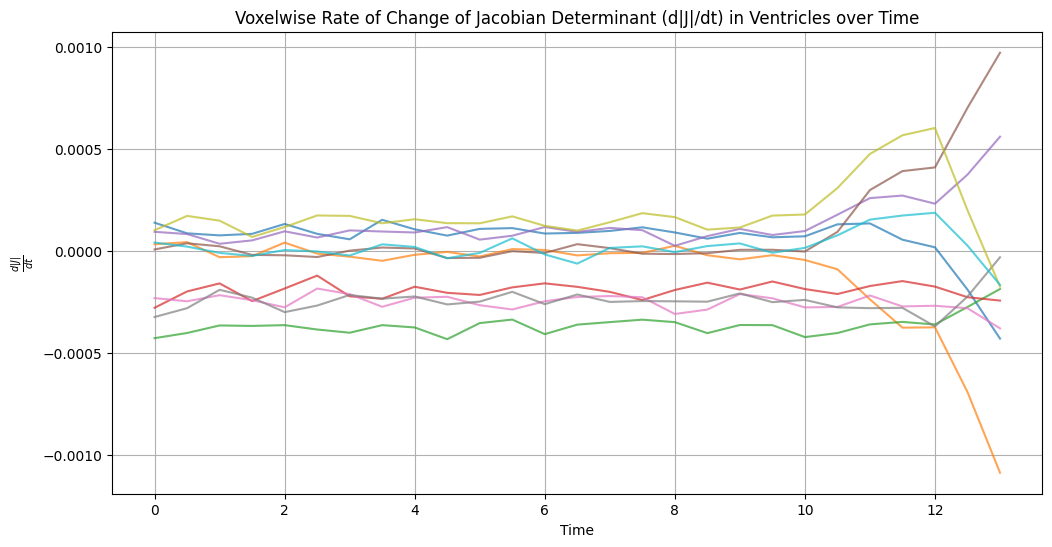

In [26]:
# dj = torch.stack(stack_total_jac_det, axis=0).to(device)
dj = torch.stack(stack_total_jac_det, axis=0)

jac_det_derivative = torch.gradient(dj, spacing=(time.cpu(),), dim=0)[0]
# jac_det_derivative_np = jac_det_derivative.cpu().numpy()
jac_det_derivative_np = jac_det_derivative

#mask to identify ventricle voxels
I0_seg_np = I0_seg.cpu().numpy()
ventricle_indices = np.argwhere((I0_seg_np == 4) | (I0_seg_np == 43))  #69680

num_voxels_to_plot = 10
sampled_indices = ventricle_indices[np.random.choice(len(ventricle_indices), size=num_voxels_to_plot, replace=False)]

plt.figure(figsize=(12, 6))

for voxel_idx in sampled_indices:
    x, y, z = voxel_idx
    plt.plot(
        # time.cpu().numpy(), 
        time.cpu().detach().numpy(),

        jac_det_derivative_np[:, x, y, z].cpu().detach().numpy(),
        # alpha=0.5, marker="*", label=f"Voxel ({x}, {y}, {z})"
        alpha=0.7, label=f"Voxel ({x}, {y}, {z})"

    )

plt.xlabel('Time')
plt.ylabel(r'$\frac{d|J|}{dt}$')
plt.title('Voxelwise Rate of Change of Jacobian Determinant (d|J|/dt) in Ventricles over Time')
plt.grid(True)
wandb.log({"Voxelwise Rate of Change of Jacobian Determinant in Ventricles (d|J|/dt) over Time": wandb.Image(plt)})
plt.savefig(result_path +"/voxelwise_rate_of_change_ventricles.png", dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_748110/935940688.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


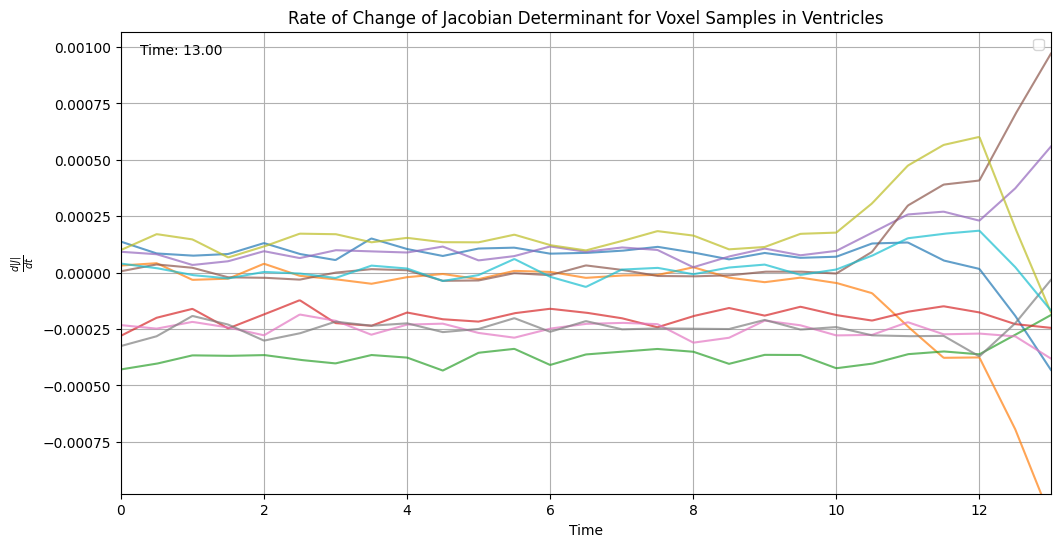

In [27]:
#interpolating time for smoother animation
time_np = time.cpu().detach().numpy()

num_frames = len(time_np) * 30  #30 frames per second
interpolated_time = np.linspace(time_np[0], time_np[-1], num_frames)

interpolated_voxel_derivatives = {
    i: np.interp(interpolated_time, time_np, jac_det_derivative_np[:, x, y, z].cpu().detach().numpy())
    for i, (x, y, z) in enumerate(sampled_indices)
}

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlim(time_np[0], time_np[-1])
ax.set_ylim(
    min(min(values) for values in interpolated_voxel_derivatives.values()) * 0.9,
    max(max(values) for values in interpolated_voxel_derivatives.values()) * 1.1
)
ax.set_xlabel('Time')
ax.set_ylabel(r'$\frac{d|J|}{dt}$')
ax.set_title('Rate of Change of Jacobian Determinant for Voxel Samples in Ventricles')
lines = {i: ax.plot([], [], alpha=0.7)[0] for i in interpolated_voxel_derivatives.keys()}
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

ax.legend()
ax.grid(True)


def update(frame):
    current_time = interpolated_time[frame]
    time_text.set_text(f'Time: {current_time:.2f}')
    for i, line in lines.items():
        line.set_data(interpolated_time[:frame + 1], interpolated_voxel_derivatives[i][:frame + 1])
    return (*lines.values(), time_text)


ani = FuncAnimation(fig, update, frames=num_frames, blit=True, interval=1000 / 30)

ani.save(result_path+'/rate_of_change_jacobian_voxels.mp4', writer='ffmpeg', codec='mpeg4', fps=30, dpi=300)
wandb.log({"Rate_of_Change_Animation_Voxels": wandb.Video(result_path +'/rate_of_change_jacobian_voxels.mp4')})

plt.show()

### Line plots for each voxel within a structure

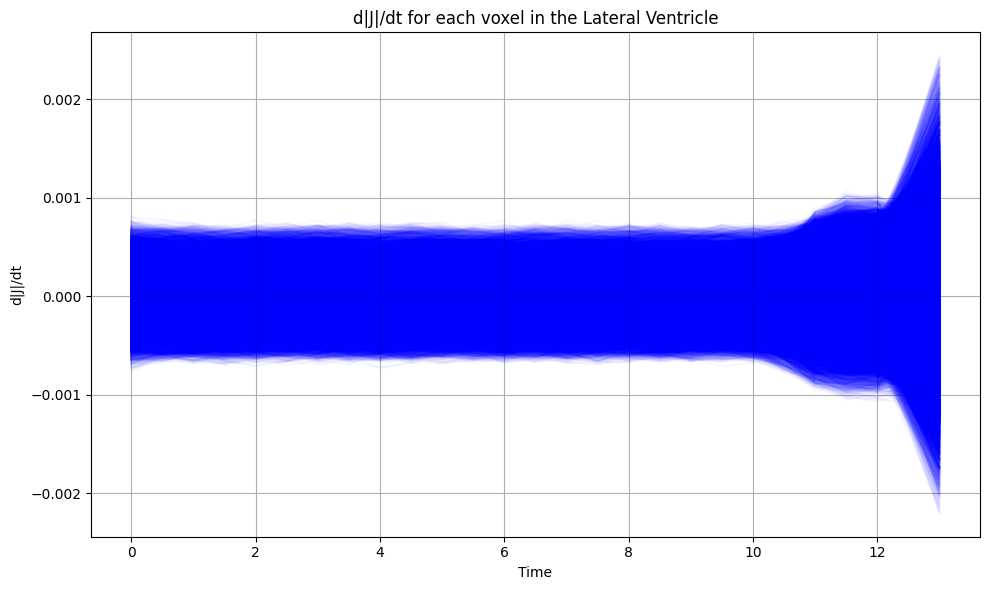

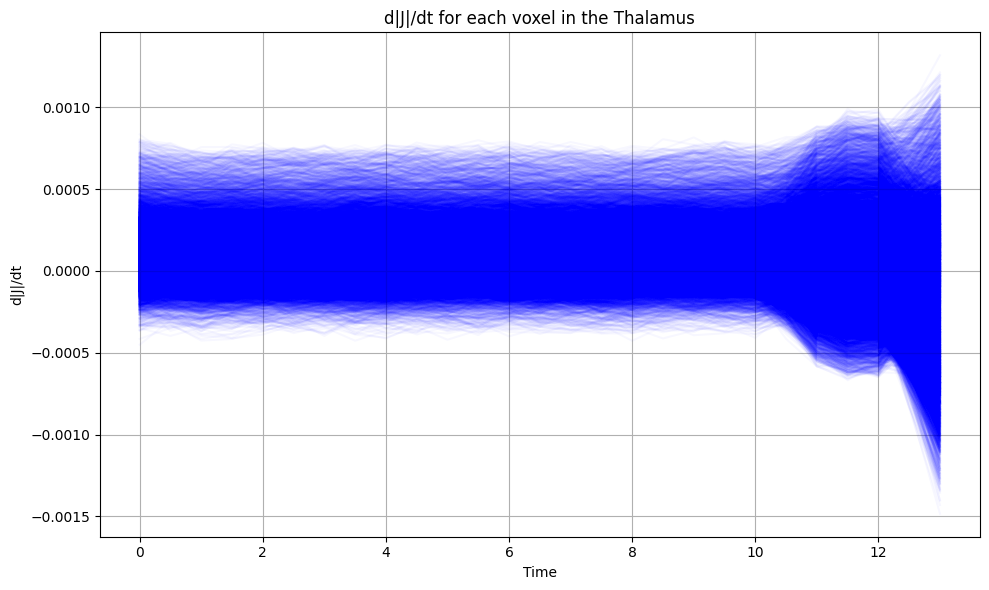

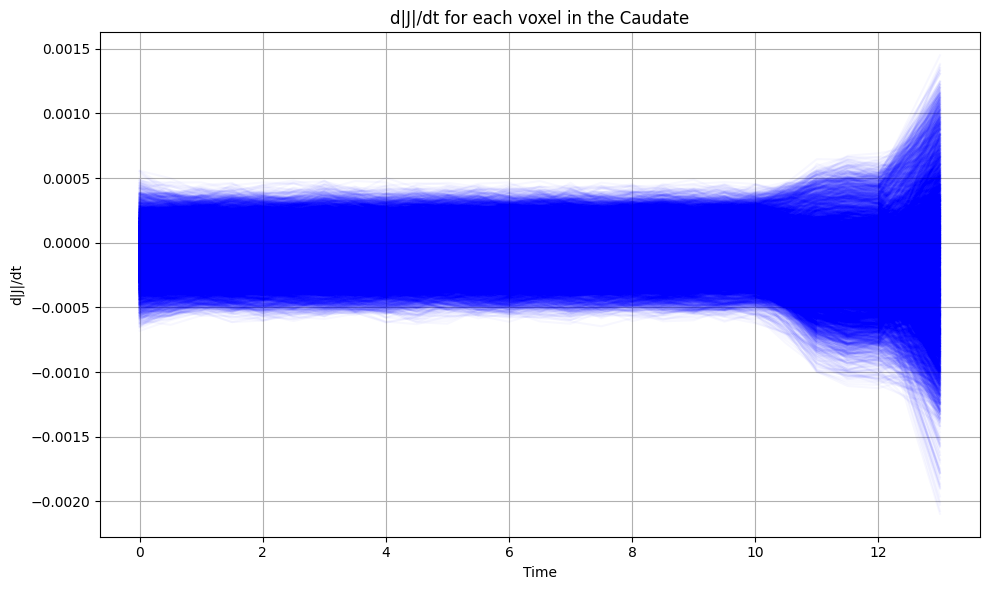

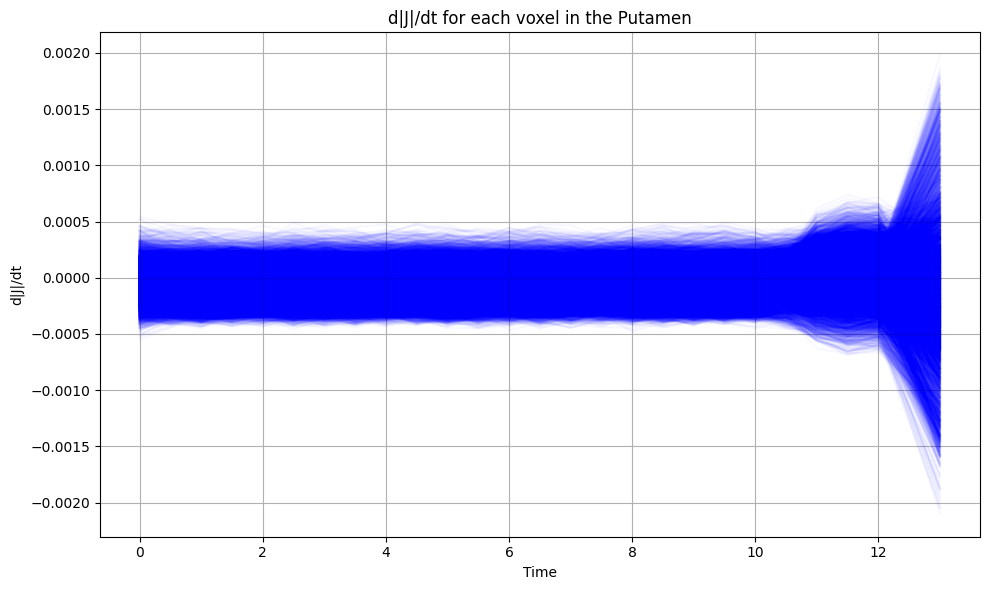

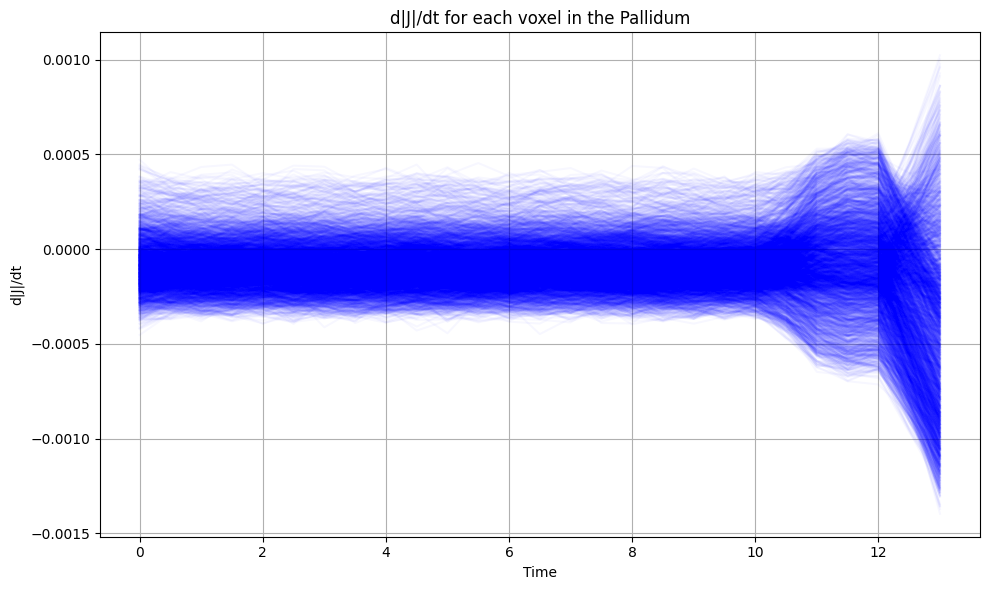

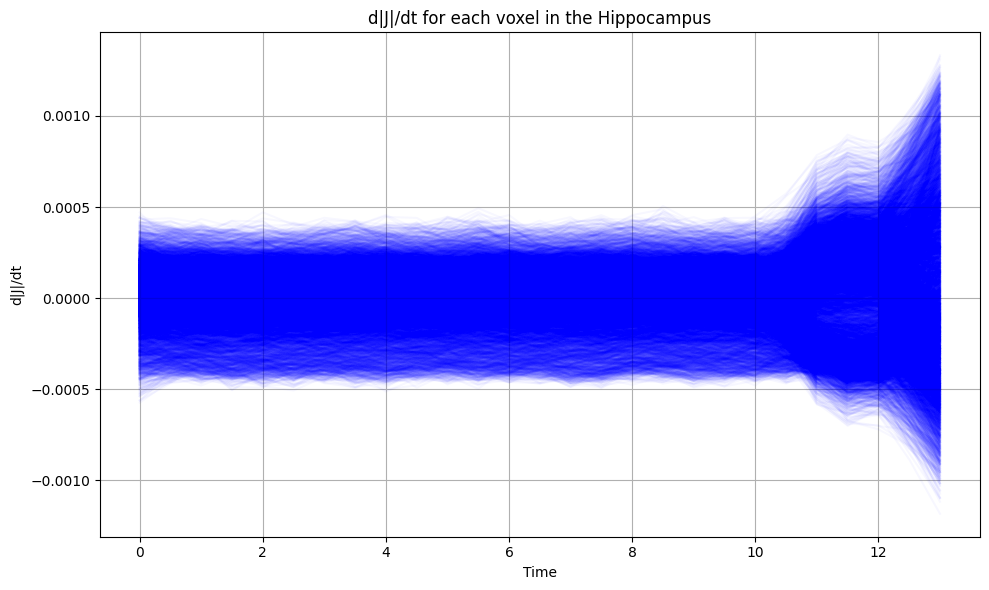

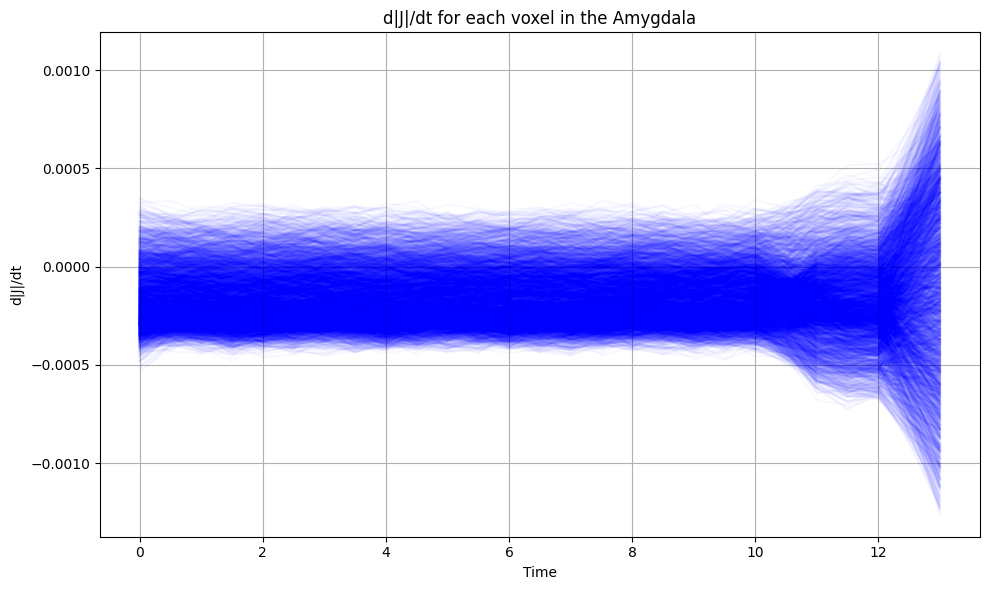

In [28]:
time_np = time.cpu().detach().numpy()

for structure, (left_id, right_id) in paired_structures.items():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    left_mask = region_mask == left_id
    right_mask = region_mask == right_id

    left_voxel_data = jac_det_derivative[:, left_mask].cpu().numpy()
    right_voxel_data = jac_det_derivative[:, right_mask].cpu().numpy()
    
    combined_data = np.concatenate([left_voxel_data, right_voxel_data], axis=1)
    
    for voxel_values in combined_data.T: 
        ax.plot(time_np, voxel_values, color='blue', alpha=0.03)
    
    ax.set_title(f'd|J|/dt for each voxel in the {structure}')
    ax.set_xlabel('Time')
    ax.set_ylabel(r'd|J|/dt')
    ax.grid(True)
    
    plt.tight_layout()
    save_path = result_path + f"/voxelwise_rate_of_change_{structure.replace(' ', '_').lower()}.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    wandb.log({f"Voxelwise Rate of Change of Jacobian Determinant in {structure} (d|J|/dt) over Time": wandb.Image(plt)})
    plt.show()


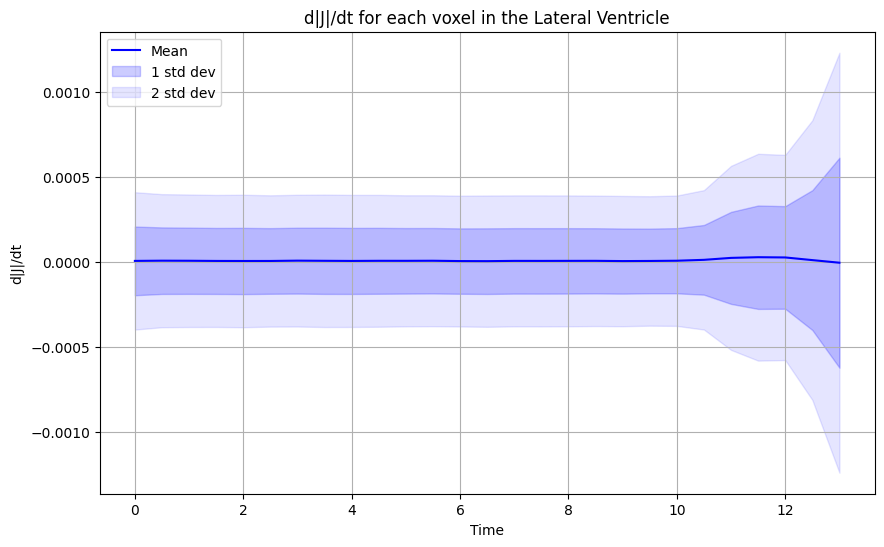

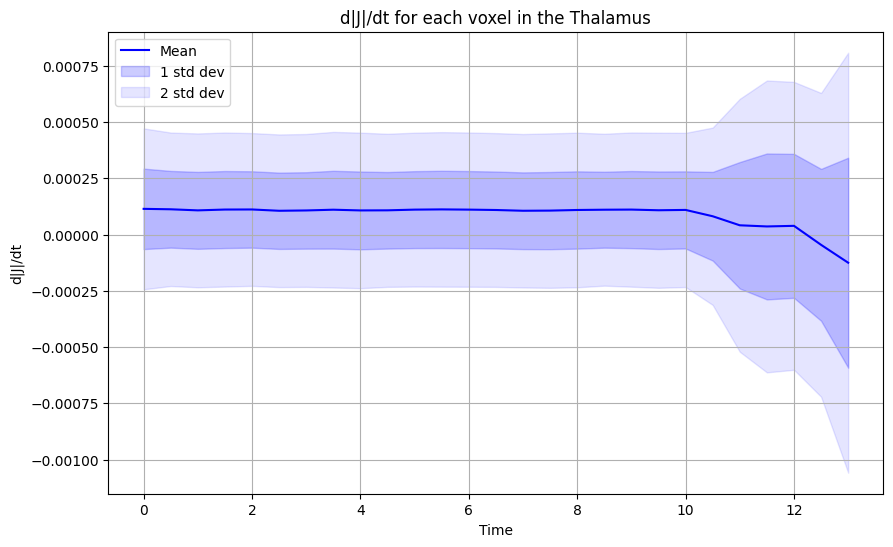

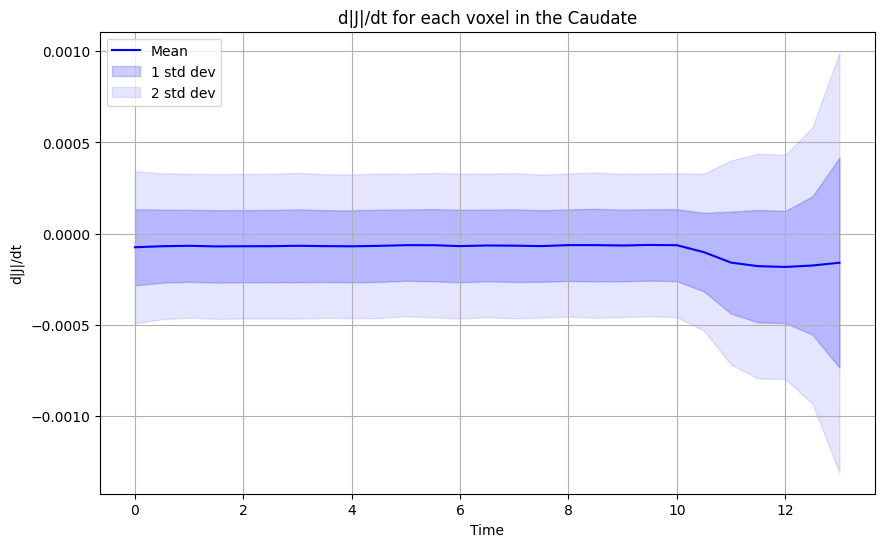

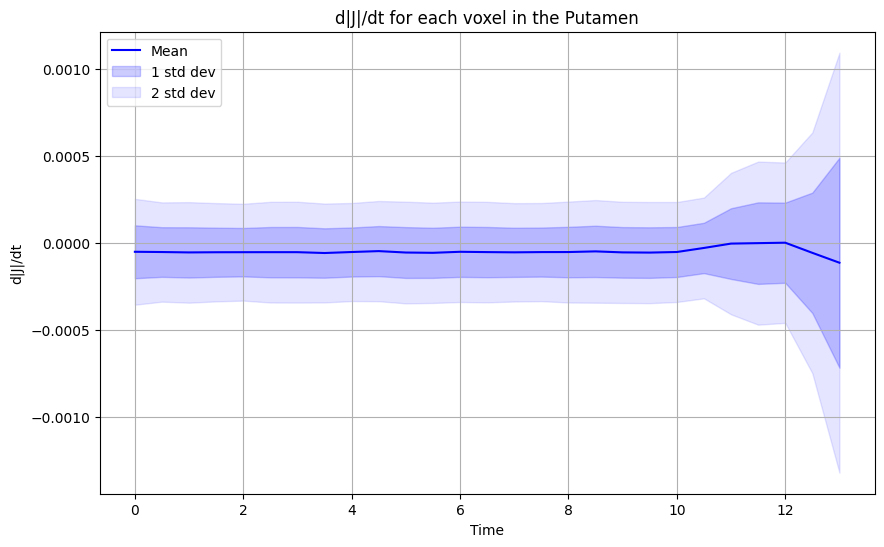

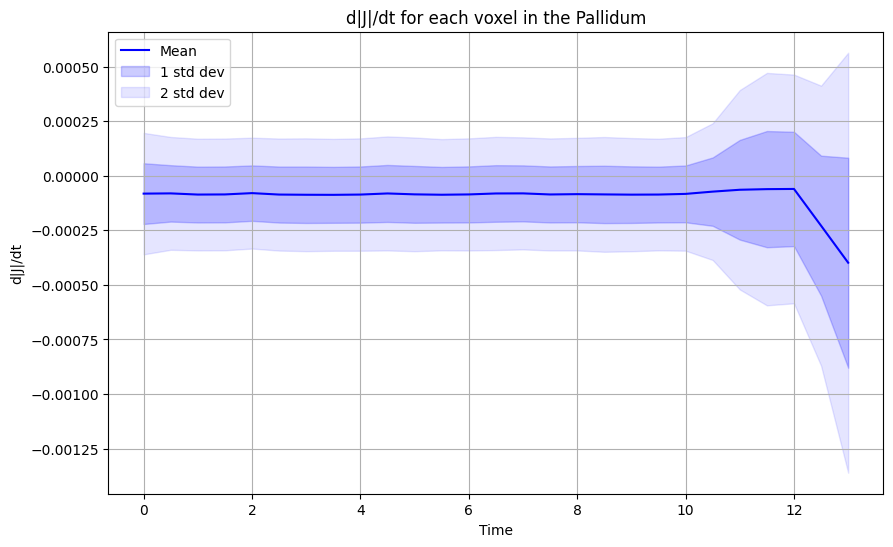

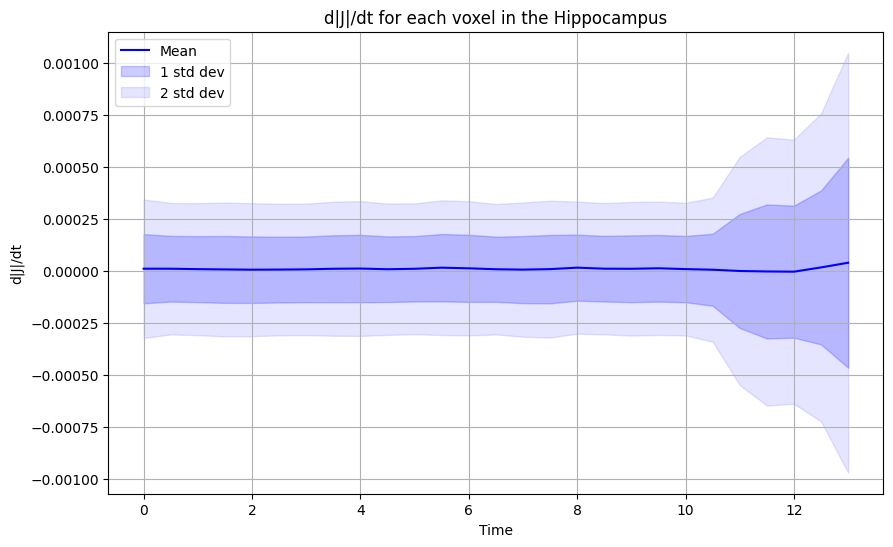

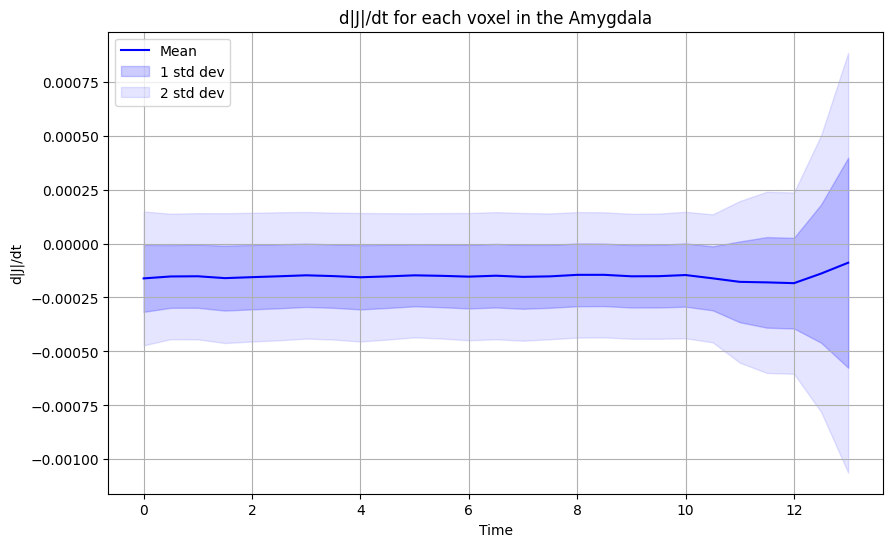

In [29]:
for structure, (left_id, right_id) in paired_structures.items():
    left_mask = (region_mask == left_id)
    right_mask = (region_mask == right_id)

    left_values = jac_det_derivative[:, left_mask]
    right_values = jac_det_derivative[:, right_mask]

    combined_values = np.concatenate([left_values, right_values], axis=1)

    #calculate mean and standard deviation for each time point
    mean_values = np.mean(combined_values, axis=1)
    std_values = np.std(combined_values, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(time_np, mean_values, color="blue", label="Mean")
    # one standard dev from mean plot, this is range from mean-std to mean+std. this shows where approximately
    # 68% of the voxels' values lie for each time point.
    plt.fill_between(
        time_np,
        mean_values - std_values,
        mean_values + std_values,
        color="blue",
        alpha=0.2,
        label="1 std dev",
    )
    # one standard dev from mean plot, this is range from mean-2std to mean+2std. this shows where approximately
    # 95% of the voxels' values lie for each time point.
    plt.fill_between(
        time_np,
        mean_values - 2 * std_values,
        mean_values + 2 * std_values,
        color="blue",
        alpha=0.1,
        label="2 std dev",
    )
    plt.title(f"d|J|/dt for each voxel in the {structure}")
    plt.xlabel("Time")
    plt.ylabel(r"d|J|/dt")
    plt.grid(True)
    plt.legend()

    save_path = f"{result_path}/dJ_dt_{structure.replace(' ', '_').lower()}.png"
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    wandb.log({f"d|J|/dt in {structure} Over Time": wandb.Image(save_path)})
    plt.show()


### GENERATING JACOBIAN MAP VIDEO

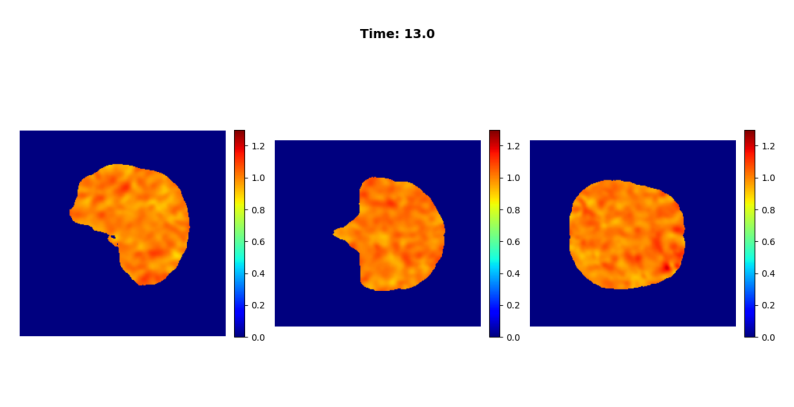

In [30]:
fig, ax = plt.subplots(figsize=(10, 7))

def init():
    ax.clear()
    ax.axis('off')
    return []

def update(frame):
    ax.clear() 
    ax.axis('off')

    fig = video_jacobian_maps[frame]
    canvas = FigureCanvas(fig)
    canvas.draw()

    buf, (width, height) = canvas.print_to_buffer() 

    img = np.frombuffer(buf, dtype=np.uint8).reshape((height, width, 4))

    img_rgb = img[..., :3]  

    ax.imshow(img_rgb)
    return []

ani = FuncAnimation(fig, update, frames=len(video_jacobian_maps), init_func=init, blit=True, interval=1000)

video_filename = result_path + '/jacobian_maps.mp4'
ani.save(video_filename, writer='ffmpeg', fps=3, codec='mpeg4', dpi=300)

wandb.log({"Jacobian Maps Video": wandb.Video(video_filename, format="mp4")})
plt.show()
plt.close(fig)


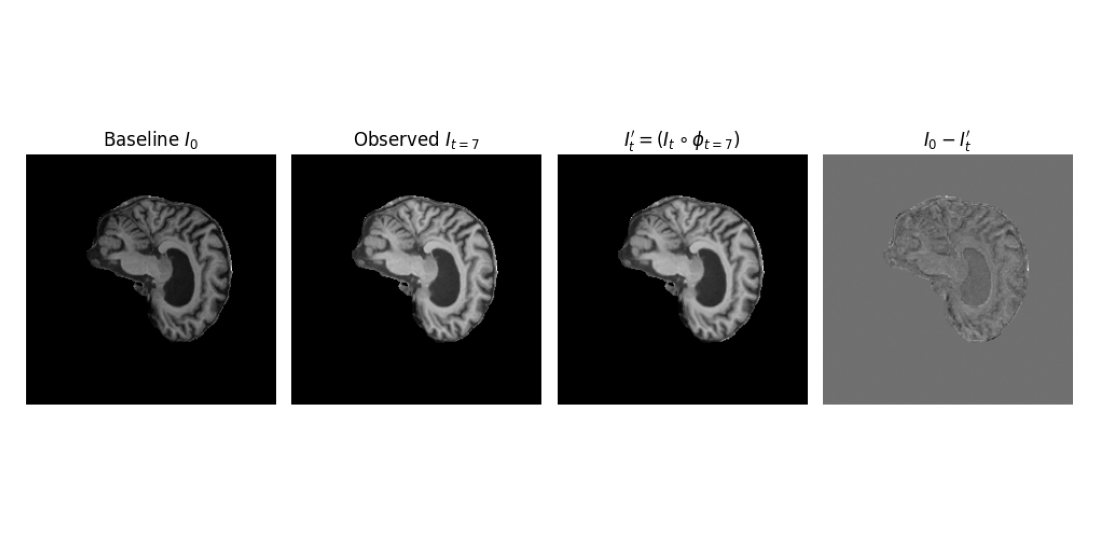

In [31]:
# numberr of time points and images per time point
num_time_points = len(video_images)
num_images = len(video_images[0])
#init a list to hold the composite images
composite_images = []

#create individual figures for each time point and store them
for t in range(num_time_points):
    fig, axs = plt.subplots(1, num_images, figsize=(10, 5))

    for i in range(num_images):
        axs[i].imshow(video_images[t][i], cmap='gray')
        axs[i].set_title(video_titles[t][i])
        axs[i].axis('off')

    plt.tight_layout()

    #render the figure to a canvas and convert to a numpy array using print_to_buffer
    canvas = FigureCanvas(fig)
    canvas.draw()
    #get buffer and dims
    buf, (width, height) = canvas.print_to_buffer()
    img = np.frombuffer(buf, dtype=np.uint8).reshape((height, width, 4))  # RGBA format
    img_rgb = img[..., :3]  #convert from RGBA to RGB

    composite_images.append(img_rgb)
    plt.close(fig)

#creating anim figure
fig, ax = plt.subplots(figsize=(15, 7))

def init():
    ax.clear()
    ax.axis('off')
    return []

def update(frame):
    ax.clear()
    ax.axis('off')
    ax.imshow(composite_images[frame])
    return []

ani = FuncAnimation(fig, update, frames=len(composite_images), init_func=init, blit=True, interval=1000)
video_filename = result_path + '/residual.mp4'
ani.save(video_filename, writer='ffmpeg', fps=1, dpi=300, codec='mpeg4')
wandb.log({"Time Lapse Transition Video": wandb.Video(video_filename, format="mp4")})

plt.show()
plt.close(fig)
